<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/Norway/DNB/DNB_1D_High.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "dnb.ol"
data_resample = '1D'
data_label = 'High'
data_label_name = 'y'
start_date = '1 Jan 2009'
finish_date = '1 Jan 2019'
is_duka = False
is_yahoo = True
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

[*********************100%***********************]  1 of 1 downloaded


Open    High     Low   Close  Adj Close    Volume
Date                                                           
2009-01-02   26.07   27.06   25.92   27.06      19.00   1596916
2009-01-05   27.54   27.73   25.31   25.64      18.00   4045796
2009-01-06   25.45   25.59   24.12   24.21      17.00  10930892
2009-01-07   24.36   24.78   23.74   24.50      17.20   8012013
2009-01-08   24.21   25.69   23.74   25.69      18.03   7219663
...            ...     ...     ...     ...        ...       ...
2018-12-19  144.25  145.20  142.85  143.65     136.50   1689322
2018-12-20  141.50  142.40  139.65  139.65     132.69   2609371
2018-12-21  139.00  139.60  136.80  138.50     131.60   4492011
2018-12-27  140.00  140.00  135.50  136.40     129.61   2380658
2018-12-28  137.80  139.30  136.60  138.15     131.27   1871025

[2511 rows x 6 columns]

Open         High          Low        Close    Adj Close        Volume
count  2511.000000  2511.000000  2511.000000  2511.000000  2511.000000  2.511000e+03
mean     99.328248   100.338375    98.237806    99.323712    81.950191  3.374181e+06
std      35.537827    35.588108    35.490705    35.536804    36.148386  2.442291e+06
min      15.760000    18.420000    14.150000    15.860000    11.130000  0.000000e+00
25%      69.800000    70.650000    69.000000    69.800000    52.000000  1.873061e+06
50%      98.150000    98.950000    96.950000    98.000000    81.390000  2.689587e+06
75%     126.750000   127.900000   125.600000   126.650000   104.825000  4.150978e+06
max     173.500000   174.200000   172.100000   173.150000   164.530000  3.512639e+07

7

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open    High     Low   Close  Adj Close    Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear        mama        fama      SAREXT      DEMA_8       EMA_8      KAMA_8  MIDPOINT_8  MIDPRICE_8    SAR_0.08      SMA_8      TEMA_8   TRIMA_8       WMA_8     MA_8_0    MAVP_8_0      T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5      MA_8_1    MAVP_8_1      T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
2009-03-13   24.40   25.59   24.17   24.88      17.46   6616458   13          4         72             31             0               0               0                 0      3        1    11        4             0          11   22.671692   22.249426   20.315400   23.921173   23.142484   22.378327      22.650      22.885   20.571600   22.54750   24.488672   22.2515   23.165000   22.54750   24.356667   22.152606               25.673340                 22.54750               19.421660               27.236260                 22.54750               17.858740               28.799180                 22.54750               16.295820               30.362100                 22.54750               14.732900   23.142484   24.153622   22.147650               26.268324                23.142484               20.016644               27.831244                23.142484               18.453724               29.394164                23.142484               16.890804               30.957084   
2009-03-16   25.16   25.59   24.93   25.50      17.90   5104008   16          0         75             31             0               0               0                 0      3        1    12        0             1          12   22.813107   22.263518   20.526384   24.679495   23.666377   22.693716      22.960      22.885   20.973072   22.96875   25.303218   22.9445   23.821111   22.96875   25.190000   22.263862               26.620126                 22.96875               19.317374               28.445813                 22.96875               17.491687               30.271501                 22.96875               15.665999               32.097189                 22.96875               13.840311   23.666377   25.164532   22.288148               27.317752                23.666377               20.015001               29.143440                23.666377               18.189313               30.969128                23.666377               16.363625               32.794816   
2009-03-17   25.45   26.59   25.16   26.59      18.66   51

Open         High          Low        Close    Adj Close        Volume          day    dayofweek    dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2461.000000  2461.000000  2461.000000  2461.000000  2461.000000  2.461000e+03  2461.000000  2461.000000  2461.000000    2461.000000   2461.000000     2461.000000     2461.000000       2461.000000  2461.000000  2461.000000  2461.000000  2461.000000   2461.000000  2461.000000  2461.000000  2461.000000  2461.000000  2461.000000  2461.000000  2461.000000  2461.000000  2461.000000  2461.000000  2461.000000  2461.000000  2461.000000  2461.000000  2461.000000  2461.000000  2461.000000             2461.000000              2461.000000             2461.000000             2461.000000              2461.000000             2461.000000             2461.000000              2461.000000             2461.000000             2461.000000              2461.000000             2461.000000  2461.000000  2461.000000  2461.000000             2461.000000              2461.000000             2461.000000             2461.000000              2461.000000             2461.000000             2461.000000   
mean    100.890041   101.904604    99.798005   100.887956    83.296701  3.270255e+06    15.734254     2.000813   186.229175      30.457538      0.031694        0.027631        0.008533          0.007720     6.626168     2.542462    27.087769     2.000813      2.001219    27.087769   100.725744   100.290676     2.862108   100.893016   100.719971   100.703185   100.676390   100.530666   100.047739   100.722101   100.889905   100.722985   100.778324   100.722101   100.856948   100.370770              103.958037               100.722101               97.486166              105.576004               100.722101               95.868198              107.193972               100.722101               94.250231              108.811940               100.722101               92.632263   100.719971   100.855141   100.424135              103.955906               100.719971               97.484035              105.573874               100.719971               95.866068              107.191841   
std      34.145854    34.189239    34.099405    34.139094    35.243634  2.212197e+06     8.726937     1.408453   103.708172       0.789878      0.175221        0.163947        0.091999          0.087544     3.401104     1.109606    14.830931     1.408453      1.409174    14.830931    34.132257    34.140939   105.793154    34.154322    34.163873    34.331959    34.171175    34.125871    34.273116    34.186484    34.146776    34.196679    34.161752    34.186484    34.144644    34.283536               34.391272                34.186484               34.064360               34.524229                34.186484               34.034598               34.677260                34.186484               34.025790               34.850101                34.186484               34.037951    34.163873    34.138878    34.269727               34.372383                34.163873               34.038046               34.507199                34.163873               34.006449               34.662084   
min      24.400000    25.590000    24.

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close  Adj Close    Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
2009-03-13  0.000000  0.000000  0.000000  0.000000   0.000000   6616458   13          4         72             31             0               0               0                 0      3        1    11        4             0          11  0.000000  0.000000  0.566482  0.000000  0.000000  0.000000    0.000000    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000                0.000000                 0.000000                0.000695                0.000000                 0.000000                0.002504                0.000000                 0.000000                0.005663                0.000000                 0.000000                0.008757  0.000000  0.000000  0.000000                0.000000                 0.000000                0.000011                0.000000                 0.000000                0.001894                0.000000                 0.000000                0.005073                0.000000                 0.000000   
2009-03-16  0.005097  0.000000  0.005138  0.004182   0.002992   5104008   16          0         75             31             0               0               0                 0      3        1    12        0             1          12  0.000950  0.000095  0.567097  0.005096  0.003524  0.002112    0.002083    0.000000  0.002613  0.002825  0.005475  0.004626  0.004408  0.002825  0.005618  0.000748                0.006330                 0.002825                0.000000                0.008034                 0.002825                0.000075                0.009715                 0.002825                0.001537                0.011374                 0.002825                0.002970  0.003524  0.006803  0.000944                0.007043                 0.003524                0.000000                0.008761                 0.003524                0.000135                0.010461                 0.003524                0.001604                0.012144                 0.003524   
2009-03-17  0.007042  0.006729  0.006692  0.0115

140184

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpijc7pu1h
  JVM stdout: /tmp/tmpijc7pu1h/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpijc7pu1h/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 17 days
H2O cluster name:           H2O_from_python_unknownUser_hr3pyy
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc    logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190905_205444_mod...  0.513660   0.696520              0.486141  0.500855  0.250856
1  DeepLearning_grid_1_AutoML_20190905_205444_mod...  0.509682  15.743235              0.486605  0.679491  0.461707
2  DeepLearning_grid_1_AutoML_20190905_205444_mod...  0.509615  15.853190              0.486605  0.683726  0.467481
3              DeepLearning_1_AutoML_20190905_205444  0.502056  15.772218              0.490915  0.680623  0.463247
4  DeepLearning_grid_1_AutoML_20190905_205444_mod...  0.502056  15.696083              0.490915  0.687186  0.472225
5  DeepLearning_grid_1_AutoML_20190905_205444_mod...  0.500000   0.695701              0.495225  0.500849  0.250850
6  DeepLearning_grid_1_AutoML_20190905_205444_mod...  0.489092  17.917183              0.500000  0.726692  0.528081
7  DeepLearning_grid_1_AutoML_20190905_205444_mod...  0.488859  16.601781              0.500000  0.721435  0.520469
8  DeepLearning_grid_1_AutoML_20190905_205444_mod...  0.487898  17.792461              0.500000  0.726860  0.528326
9  DeepLearning_grid_1_AutoML_20190905_205444_mod...  0.487069  15.999931              0.500000  0.718415  0.516121

variable  relative_importance  scaled_importance  percentage
0                          BOP             1.000000           1.000000    0.009465
1           CDLCLOSINGMARUBOZU             0.557344           0.557344    0.005275
2                          SUB             0.502815           0.502815    0.004759
3                  CDLLONGLINE             0.420962           0.420962    0.003984
4                          DIV             0.381170           0.381170    0.003608
...                        ...                  ...                ...         ...
1036   BBANDS_upperband_12_7_2             0.077871           0.077871    0.000737
1037   BBANDS_lowerband_12_0_3             0.077772           0.077772    0.000736
1038  BBANDS_middleband_20_1_2             0.077544           0.077544    0.000734
1039                   MA_20_2             0.076997           0.076997    0.000729
1040       CDLGAPSIDESIDEWHITE             0.074628           0.074628    0.000706

[1041 rows x 4 columns]

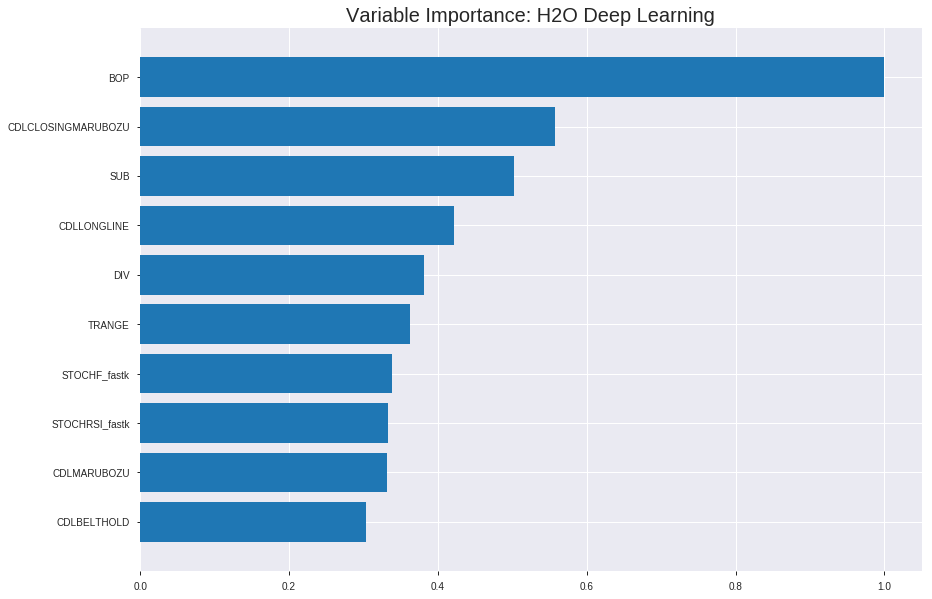

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190905_205444_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.209102800287081
RMSE: 0.45727759652871797
LogLoss: 0.6039433385597746
Mean Per-Class Error: 0.3086915982568157
AUC: 0.7613209013209012
pr_auc: 0.7625429775551995
Gini: 0.5226418026418025
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4892010631511048: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      363  462   0.56     (462.0/825.0)
1      102  795   0.1137   (102.0/897.0)
Total  465  1257  0.3275   (564.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.489201     0.738162  201
max f2                       0.2596       0.859177  308
max f0point5                 0.543376     0.715862  153
max accuracy                 0.542627     0.693961  154
max precision                0.925271     1         0
max recall                   0.0343969    1         393
max specificity              0.925271     1         0
max absolute_mcc             0.543376     0.38919   153
max min_per_class_accuracy   0.542627     0.627879  154
max mean_per_class_accuracy  0.542627     0.691308  154

Gains/Lift Table: Avg response rate: 52.09 %, avg score: 49.75 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.814309           1.70643   1.70643            0.888889         0.849686  0.888889                    0.849686            0.0178372       0.0178372                  70.6429   70.6429
    2        0.0203252                   0.764548           1.80681   1.75518            0.941176         0.794991  0.914286                    0.82312             0.0178372       0.0356745                  80.6807   75.5184
    3        0.0301974                   0.728137           1.91973   1.80898            1                0.747262  0.942308                    0.79832             0.0189521       0.0546265                  91.9732   80.8979
    4        0.0400697                   0.706418           1.80681   1.80844            0.941176         0.715321  0.942029                    0.777871            0.0178372       0.0724638                  80.6807   80.8444
    5        0.0505226                   0.691993           1.70643   1.78734            0.888889         0.700379  0.931034                    0.761838            0.0178372       0.090301                   70.6429   78.7337
    6        0.100465                    0.626841           1.5849    1.6867             0.825581         0.658696  0.878613                    0.710565            0.0791527       0.169454                   58.4895   68.6701
    7        0.150407                    0.59442            1.38399   1.58619            0.72093          0.608275  0.826255                    0.6766              0.0691193       0.238573                   38.3993   58.6188
    8        0.200348                    0.578384           1.47328   1.55804            0.767442         0.584999  0.811594                    0.653766            0.0735786       0.312152                   47.3283   55.8044
    9        0.300232                    0.55793            1.32819   1.48157            0.69186          0.567356  0.77176                     0.625019            0.132664        0.444816                   32.8187   48.1573
    10       0.570848                    0.542626           1.14525   1.32214            0.596567         0.545175  0.688708                    0.587168            0.309922        0.754738                   14.5248   32.2135
    11       0.599884                    0.539191           0.767893  1.29531            0.4              0.54079   0.674734                    0.584923            0.0222965       0.777035                   -23.2107  29.5308
    12       0.699768                    0.507669           0.848254  1.2315             0.44186          0.527469  0.641494                    0.576722            0.0847269       0.861761                   -15.1746  23.1496
    13       0.799652                    0.416462           0.658513  1.15993            0.343023         0.467213  0.604212                    0.563044            0.0657748       0.927536                   -34.1487  15.9925
    14       0.899535                    0.243052           0.546901  1.09186            0.284884         0.342391  0.568754                    0.538542            0.0546265       0.982163                   -45.3099  9.18556
    15       1                           0.0128973          0.177548  1                  0.0924855        0.13051   0.520906                    0.49755             0.0178372       1                          -82.2452  0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.225480087024701
RMSE: 0.47484743552503367
LogLoss: 0.6515918657653366
Mean Per-Class Error: 0.3551773896601482
AUC: 0.6907747424988804
pr_auc: 0.7148338215290769
Gini: 0.38154948499776076
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5346272882171627: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      92   139  0.6017   (139.0/231.0)
1      31   230  0.1188   (31.0/261.0)
Total  123  369  0.3455   (170.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.534627     0.730159  137
max f2                       0.234813     0.858653  238
max f0point5                 0.53779      0.665689  129
max accuracy                 0.53779      0.658537  129
max precision                0.878285     1         0
max recall                   0.000142284  1         260
max specificity              0.878285     1         0
max absolute_mcc             0.53779      0.327042  129
max min_per_class_accuracy   0.542626     0.445887  113
max mean_per_class_accuracy  0.53779      0.644823  129

Gains/Lift Table: Avg response rate: 53.05 %, avg score: 52.00 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.750006           1.88506   1.88506            1                0.808634  1                           0.808634            0.0191571       0.0191571                  88.5057   88.5057
    2        0.0203252                   0.725015           1.88506   1.88506            1                0.738983  1                           0.773809            0.0191571       0.0383142                  88.5057   88.5057
    3        0.0304878                   0.711684           1.88506   1.88506            1                0.716728  1                           0.754782            0.0191571       0.0574713                  88.5057   88.5057
    4        0.0406504                   0.669938           1.50805   1.7908             0.8              0.696865  0.95                        0.740303            0.0153257       0.0727969                  50.8046   79.0805
    5        0.050813                    0.64675            1.13103   1.65885            0.6              0.654591  0.88                        0.72316             0.0114943       0.0842912                  13.1034   65.8851
    6        0.101626                    0.596008           1.35724   1.50805            0.72             0.619056  0.8                         0.671108            0.0689655       0.153257                   35.7241   50.8046
    7        0.150407                    0.570027           1.41379   1.47748            0.75             0.583306  0.783784                    0.642632            0.0689655       0.222222                   41.3793   47.7477
    8        0.20122                     0.550695           1.13103   1.38999            0.6              0.561009  0.737374                    0.62202             0.0574713       0.279693                   13.1034   38.9992
    9        0.70122                     0.542626           1.10345   1.18567            0.585366         0.542827  0.628986                    0.565552            0.551724        0.831418                   10.3448   18.5674
    10       0.79878                     0.519639           0.706897  1.1272             0.375            0.533598  0.597964                    0.561649            0.0689655       0.900383                   -29.3103  12.7197
    11       0.898374                    0.430141           0.730941  1.08327            0.387755         0.483294  0.574661                    0.552963            0.0727969       0.97318                    -26.9059  8.32683
    12       1                           0.000142284        0.263908  1                  0.14             0.228732  0.530488                    0.520012            0.0268199       1                          -73.6092  0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-05 21:16:42  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-05 21:16:44  3 min 47.099 sec  245 obs/sec       0.311847  1             537        0.675056         2.39397             -0.825997      0.490761        0.512601           1.17317          0.479094                         0.635967           5.64516               -0.623856        0.527168          0.560968             1.13103            0.469512
    2019-09-05 21:17:20  4 min 22.406 sec  341 obs/sec       6.78513   21            11684      0.499616         0.69238             -0.000212597   0.537165        0.497193           0.533259         0.457027                         0.499677           0.692512              -0.00243678      0.485197          0.469745             0.377011           0.469512
    2019-09-05 21:17:54  4 min 56.773 sec  376 obs/sec       14.2375   44            24517      0.487136         0.666151            0.0491299      0.69816         0.699875           1.70643          0.400116                         0.492878           0.678826              0.0246604        0.628626          0.657252             1.88506            0.384146
    2019-09-05 21:18:28  5 min 30.227 sec  379 obs/sec       21.0151   65            36188      0.466731         0.625432            0.127121       0.753812        0.747721           1.70643          0.329849                         0.480358           0.658063              0.0735785        0.656483          0.697933             1.88506            0.382114
    2019-09-05 21:19:02  6 min  4.512 sec  379 obs/sec       27.8107   86            47890      0.457278         0.603943            0.162124       0.761321        0.762543           1.70643          0.327526                         0.474847           0.651592              0.0947138        0.690775          0.714834             1.88506            0.345528
    2019-09-05 21:19:36  6 min 38.832 sec  383 obs/sec       35.0087   108           60285      0.446507         0.581252            0.20113        0.783814        0.787873           1.81308          0.293844                         0.546169           5.2473                -0.197654        0.626885          0.677274             1.88506            0.469512
    2019-09-05 21:20:10  7 min 12.841 sec  385 obs/sec       42.115    130           72522      0.456088         0.60172             0.166477       0.781266        0.792117           1.91973          0.307201                         0.550577           5.35643               -0.217065        0.619562          0.67085              1.88506            0.469512
    2019-09-05 21:20:14  7 min 16.367 sec  385 obs/sec       42.115    130           72522      0.457278         0.603943            0.162124       0.761321        0.762543           1.70643          0.327526                         0.474847           0.651592              0.0947138        0.690775          0.714834             1.88506            0.345528

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
BOP                       1.0                    1.0                  0.009464638643787446
CDLCLOSINGMARUBOZU        0.5573444366455078     0.5573444366455078   0.005275063692975017
SUB                       0.502814769744873      0.502814769744873    0.004758960100394412
CDLLONGLINE               0.4209621548652649     0.4209621548652649   0.003984254678509822
DIV                       0.38116997480392456    0.38116997480392456  0.0036076360733807112
---                       ---                    ---                  ---
BBANDS_upperband_12_7_2   0.0778713971376419     0.0778713971376419   0.0007370246345946447
BBANDS_lowerband_12_0_3   0.07777152955532074    0.07777152955532074  0.0007360794240157462
BBANDS_middleband_20_1_2  0.07754366099834442    0.07754366099834442  0.000733922730465684
MA_20_2                   0.0769968032836914     0.0769968032836914   0.0007287469198069258
CDLGAPSIDESIDEWHITE       0.07462834566831589    0.07462834566831589  0.00070633032433427


See the whole table with table.as_data_frame()


('accuracy', 0.540650406504065)

('F1', 0.6937669376693767)

('auc', 0.5136604774535809)

('logloss', 0.6965196389082337)

('mean_per_class_error', 0.4861405835543766)

('rmse', 0.5008554721428045)

('mse', 0.2508562039753916)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


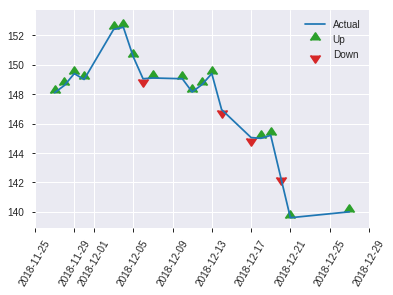


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2508562039753916
RMSE: 0.5008554721428045
LogLoss: 0.6965196389082337
Mean Per-Class Error: 0.4861405835543766
AUC: 0.5136604774535809
pr_auc: 0.008133752746781965
Gini: 0.0273209549071618
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5426260120761726: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      5    111  0.9569   (111.0/116.0)
1      2    128  0.0154   (2.0/130.0)
Total  7    239  0.4593   (113.0/246.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.542626     0.693767   0
max f2                       0.11279      0.848564   7
max f0point5                 0.542626     0.589319   0
max accuracy                 0.542626     0.54065    0
max precision                0.542626     0.535565   0
max recall                   0.11279      1          7
max specificity              0.542626     0.0431034  0
max absolute_mcc             0.542626     0.08322    0
max min_per_class_accuracy   0.542626     0.0431034  0
max mean_per_class_accuracy  0.542626     0.513859   0

Gains/Lift Table: Avg response rate: 52.85 %, avg score: 53.91 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.971545                    0.542626           1.01345   1.01345            0.535565         0.542626  0.535565                    0.542626            0.984615        0.984615                   1.34535   1.34535
    2        1                           0.11279            0.540659  1                  0.285714         0.41989   0.528455                    0.539134            0.0153846       1                          -45.9341  0

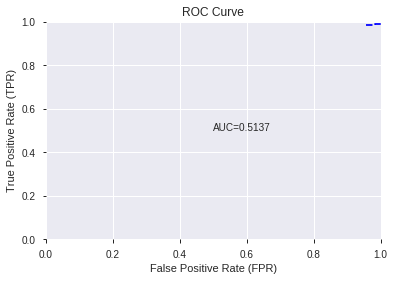

This function is available for GLM models only


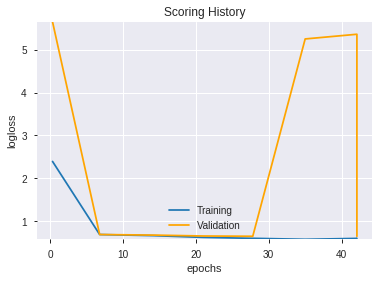

--2019-09-05 21:26:32--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.95.19
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.95.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  20.4MB/s    in 19s     

2019-09-05 21:26:52 (18.8 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: Unkno

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190905_205444_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190905_205444_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_8e55',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190905_212703_model_8  0.737997  0.606602              0.334483  0.457433  0.209245
1  DeepLearning_grid_1_AutoML_20190905_212703_model_9  0.737268  0.603453              0.297679  0.455754  0.207712
2  DeepLearning_grid_1_AutoML_20190905_212703_model_6  0.737003  0.595057              0.328647  0.450441  0.202897
3  DeepLearning_grid_1_AutoML_20190905_212703_model_5  0.732759  0.621339              0.315849  0.458324  0.210061
4  DeepLearning_grid_1_AutoML_20190905_212703_model_7  0.722414  0.659451              0.332162  0.470579  0.221444
5               DeepLearning_1_AutoML_20190905_212703  0.711804  0.701026              0.341247  0.488143  0.238284
6  DeepLearning_grid_1_AutoML_20190905_212703_model_3  0.688196  0.717921              0.393767  0.484651  0.234886
7  DeepLearning_grid_1_AutoML_20190905_212703_model_4  0.675663  0.833084              0.387599  0.518196  0.268527
8  DeepLearning_grid_1_AutoML_20190905_212703_model_2  0.664854  0.800203              0.373740  0.505835  0.255869
9  DeepLearning_grid_1_AutoML_20190905_212703_model_1  0.646618  0.960157              0.380040  0.533790  0.284932

variable  relative_importance  scaled_importance  percentage
0                  BOP             1.000000           1.000000    0.040203
1   CDLCLOSINGMARUBOZU             0.706492           0.706492    0.028403
2                  SUB             0.644263           0.644263    0.025901
3          CDLLONGLINE             0.543009           0.543009    0.021830
4       STOCHRSI_fastk             0.536038           0.536038    0.021550
5                  day             0.534029           0.534029    0.021469
6               ULTOSC             0.532620           0.532620    0.021413
7          AROONOSC_30             0.520054           0.520054    0.020908
8          STOCH_slowd             0.519882           0.519882    0.020901
9         CDLSHORTLINE             0.516583           0.516583    0.020768
10                 DIV             0.516428           0.516428    0.020762
11              MFI_12             0.516294           0.516294    0.020756
12              TRANGE             0.515543           0.515543    0.020726
13           dayofyear             0.514223           0.514223    0.020673
14               month             0.513894           0.513894    0.020660
15             BETA_20             0.513143           0.513143    0.020630
16                 SIN             0.511960           0.511960    0.020582
17             CDLDOJI             0.499981           0.499981    0.020101
18           CDLTAKURI             0.499463           0.499463    0.020080
19             BETA_12             0.492384           0.492384    0.019795
20           CORREL_20             0.487718           0.487718    0.019608
21        weekday_name             0.487402           0.487402    0.019595
22        HT_TRENDMODE             0.483412           0.483412    0.019434
23           CORREL_14             0.482369           0.482369    0.019392
24           dayofweek             0.480555           0.480555    0.019320
25         HT_DCPERIOD             0.479889           0.479889    0.019293
26                DX_8             0.476800           0.476800    0.019169
27          aroonup_30             0.471583           0.471583    0.018959
28               DX_12             0.471097           0.471097    0.018939
29   CDLLONGLEGGEDDOJI             0.461757           0.461757    0.018564
30               DX_14             0.461087           0.461087    0.018537
31        STOCHF_fastk             0.459308           0.459308    0.018465
32         CDL3OUTSIDE             0.456315           0.456315    0.018345
33        CDLENGULFING             0.455916           0.455916    0.018329
34             WILLR_8             0.455835           0.455835    0.018326
35         CDLMARUBOZU             0.455271           0.455271    0.018303
36        STOCHF_fastd             0.453969           0.453969    0.018251
37         STOCH_slowk             0.452954           0.452954    0.018210
38             BETA_14             0.452627           0.452627    0.018197
39      STOCHRSI_fastd             0.451166           0.451166    0.018138
40            WILLR_20             0.451016           0.451016    0.018132
41            WILLR_14             0.445758           0.445758    0.017921
42           CDLHAMMER             0.445275           0.445275    0.017901
43            WILLR_12             0.444963           0.444963    0.017889
44          CDLHIKKAKE             0.444828           0.444828    0.017883
45    CDLDRAGONFLYDOJI             0.444266           0.444266    0.017861
46      CDLSPINNINGTOP             0.435016           0.435016    0.017489
47            WILLR_24             0.430548           0.430548    0.017309
48             BETA_24             0.430202           0.430202    0.017295
49         CDLBELTHOLD             0.418804           0.418804    0.016837

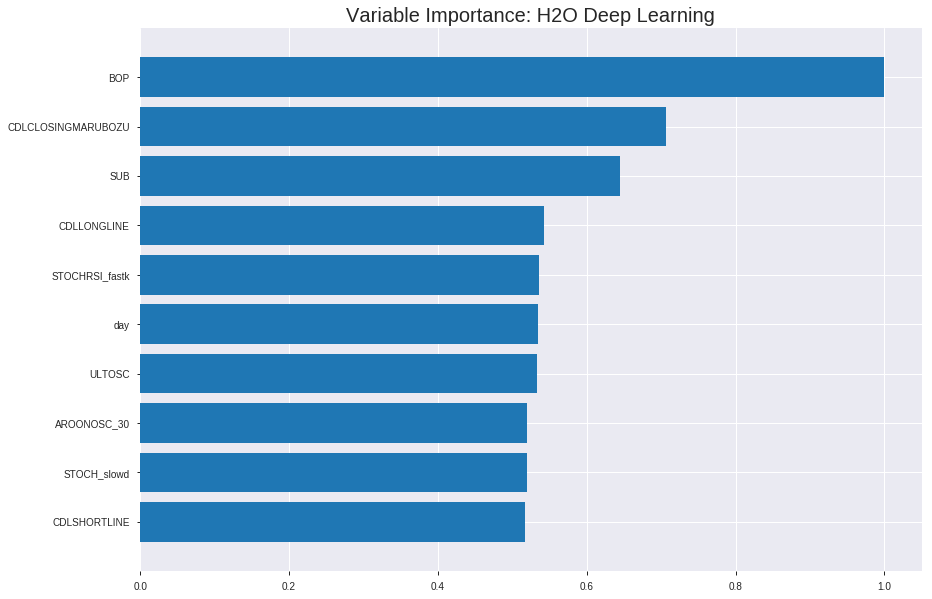

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190905_212703_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19678592653766447
RMSE: 0.4436055979557342
LogLoss: 0.5752451645054959
Mean Per-Class Error: 0.28424647815952164
AUC: 0.780862133036046
pr_auc: 0.7801294234990198
Gini: 0.561724266072092
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5474072352915883: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      451  374   0.4533   (374.0/825.0)
1      137  760   0.1527   (137.0/897.0)
Total  588  1134  0.2967   (511.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.547407     0.7484    217
max f2                       0.235874     0.85986   343
max f0point5                 0.656574     0.736856  152
max accuracy                 0.637136     0.714866  167
max precision                0.96224      1         0
max recall                   0.133508     1         377
max specificity              0.96224      1         0
max absolute_mcc             0.64997      0.431699  157
max min_per_class_accuracy   0.631441     0.707915  171
max mean_per_class_accuracy  0.637136     0.715754  167

Gains/Lift Table: Avg response rate: 52.09 %, avg score: 58.52 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.945461           1.91973   1.91973            1                0.952479  1                           0.952479            0.0200669       0.0200669                  91.9732   91.9732
    2        0.0203252                   0.925858           1.80681   1.86488            0.941176         0.931603  0.971429                    0.942339            0.0178372       0.0379041                  80.6807   86.4883
    3        0.0301974                   0.914476           1.69388   1.80898            0.882353         0.920963  0.942308                    0.935351            0.0167224       0.0546265                  69.3882   80.8979
    4        0.0400697                   0.902118           1.69388   1.78062            0.882353         0.906478  0.927536                    0.928237            0.0167224       0.0713489                  69.3882   78.0621
    5        0.0505226                   0.890329           1.70643   1.76527            0.888889         0.897805  0.91954                     0.921941            0.0178372       0.0891862                  70.6429   76.5271
    6        0.100465                    0.83945            1.65186   1.70889            0.860465         0.866265  0.890173                    0.894264            0.0824972       0.171683                   65.1863   70.8895
    7        0.150407                    0.794084           1.49561   1.63807            0.77907          0.816006  0.853282                    0.868279            0.0746934       0.246377                   49.5606   63.8073
    8        0.200348                    0.757673           1.40632   1.5803             0.732558         0.776646  0.823188                    0.845437            0.0702341       0.316611                   40.6316   58.0301
    9        0.300232                    0.709008           1.4398    1.53356            0.75             0.733288  0.798839                    0.808126            0.143813        0.460424                   43.9799   53.3558
    10       0.400116                    0.668891           1.32819   1.48229            0.69186          0.688574  0.772134                    0.778282            0.132664        0.593088                   32.8187   48.229
    11       0.5                         0.63182            1.11612   1.40914            0.581395         0.649469  0.73403                     0.752549            0.111483        0.704571                   11.6124   40.9142
    12       0.599884                    0.587052           0.892899  1.32318            0.465116         0.609932  0.689255                    0.728802            0.0891862       0.793757                   -10.7101  32.3184
    13       0.699768                    0.500533           0.792448  1.24743            0.412791         0.549797  0.649793                    0.703251            0.0791527       0.87291                    -20.7552  24.7428
    14       0.799652                    0.38891            0.613868  1.16829            0.319767         0.446105  0.608569                    0.671131            0.0613155       0.934225                   -38.6132  16.829
    15       0.899535                    0.241778           0.479933  1.09186            0.25             0.320035  0.568754                    0.632146            0.0479376       0.982163                   -52.0067  9.18556
    16       1                           0.0535417          0.177548  1                  0.0924855        0.164632  0.520906                    0.585177           



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2044105839706481
RMSE: 0.45211788724916435
LogLoss: 0.6025635944854496
Mean Per-Class Error: 0.29885057471264376
AUC: 0.756920601748188
pr_auc: 0.739668400763865
Gini: 0.513841203496376
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5062079211598653: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      106  125  0.5411   (125.0/231.0)
1      29   232  0.1111   (29.0/261.0)
Total  135  357  0.313    (154.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.506208     0.750809  275
max f2                       0.318049     0.866035  342
max f0point5                 0.61928      0.718025  204
max accuracy                 0.600565     0.705285  218
max precision                0.968156     1         0
max recall                   0.00887717   1         399
max specificity              0.968156     1         0
max absolute_mcc             0.600565     0.406879  218
max min_per_class_accuracy   0.634932     0.688312  192
max mean_per_class_accuracy  0.61928      0.701149  204

Gains/Lift Table: Avg response rate: 53.05 %, avg score: 59.44 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.950762           1.50805   1.50805            0.8              0.96085   0.8                         0.96085             0.0153257       0.0153257                  50.8046   50.8046
    2        0.0203252                   0.939921           1.88506   1.69655            1                0.945289  0.9                         0.95307             0.0191571       0.0344828                  88.5057   69.6552
    3        0.0304878                   0.918958           1.13103   1.50805            0.6              0.928615  0.8                         0.944918            0.0114943       0.045977                   13.1034   50.8046
    4        0.0406504                   0.905821           1.50805   1.50805            0.8              0.912675  0.8                         0.936857            0.0153257       0.0613027                  50.8046   50.8046
    5        0.050813                    0.893884           1.50805   1.50805            0.8              0.899988  0.8                         0.929483            0.0153257       0.0766284                  50.8046   50.8046
    6        0.101626                    0.83666            1.50805   1.50805            0.8              0.86105   0.8                         0.895267            0.0766284       0.153257                   50.8046   50.8046
    7        0.150407                    0.796491           1.41379   1.47748            0.75             0.812801  0.783784                    0.868521            0.0689655       0.222222                   41.3793   47.7477
    8        0.20122                     0.752171           1.65885   1.52328            0.88             0.7744    0.808081                    0.844753            0.0842912       0.306513                   65.8851   52.3279
    9        0.300813                    0.702237           1.34647   1.46474            0.714286         0.722198  0.777027                    0.804178            0.1341          0.440613                   34.647    46.4741
    10       0.400407                    0.668767           1.15412   1.38748            0.612245         0.686372  0.736041                    0.774876            0.114943        0.555556                   15.4117   38.7479
    11       0.5                         0.639924           1.23106   1.35632            0.653061         0.652875  0.719512                    0.750575            0.122605        0.678161                   23.1058   35.6322
    12       0.599593                    0.594434           1.07718   1.30996            0.571429         0.616958  0.694915                    0.728381            0.10728         0.785441                   7.71757   30.9955
    13       0.699187                    0.517967           0.769411  1.23296            0.408163         0.559673  0.65407                     0.70435             0.0766284       0.862069                   -23.0589  23.2959
    14       0.79878                     0.428852           0.615529  1.15598            0.326531         0.47995   0.613232                    0.676371            0.0613027       0.923372                   -38.4471  15.5977
    15       0.898374                    0.284579           0.615529  1.09606            0.326531         0.36348   0.581448                    0.641684            0.0613027       0.984674                   -38.4471  9.60628
    16       1                           0.00887717         0.150805  1                  0.08             0.176823  0.530488                    0.594442         


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-05 21:33:35  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-05 21:33:37  1 min 26.449 sec  607 obs/sec       0.720093  1             1240       0.481449         0.656182            0.0712055      0.706842        0.693826           1.81308          0.361789                         0.483804           0.662665              0.0602421        0.680143          0.667754             1.50805            0.363821
    2019-09-05 21:33:52  1 min 41.327 sec  957 obs/sec       8.64983   12            14895      0.443606         0.575245            0.211478       0.780862        0.780129           1.91973          0.296748                         0.452118           0.602564              0.179306         0.756921          0.739668             1.50805            0.313008
    2019-09-05 21:34:06  1 min 55.045 sec  1065 obs/sec      17.2793   24            29755      0.435317         0.55987             0.240667       0.804344        0.806051           1.81308          0.289199                         0.452998           0.608102              0.176107         0.755643          0.738486             1.50805            0.300813
    2019-09-05 21:34:20  2 min  9.053 sec  1103 obs/sec      26.0116   36            44792      0.426713         0.543539            0.270388       0.827763        0.83498            1.91973          0.25842                          0.459245           0.618472              0.153226         0.741636          0.721393             1.50805            0.317073
    2019-09-05 21:34:33  2 min 22.501 sec  1156 obs/sec      35.378    49            60921      0.402411         0.489698            0.351127       0.861203        0.870483           1.91973          0.243902                         0.460298           0.629871              0.149339         0.730059          0.701563             1.50805            0.313008
    2019-09-05 21:34:47  2 min 36.661 sec  1194 obs/sec      45.399    63            78177      0.382931         0.442256            0.412429       0.88192         0.889823           1.91973          0.230546                         0.474872           0.701554              0.0946212        0.699068          0.67531              1.50805            0.345528
    2019-09-05 21:34:49  2 min 38.223 sec  1192 obs/sec      45.399    63            78177      0.443606         0.575245            0.211478       0.780862        0.780129           1.91973          0.296748                         0.452118           0.602564              0.179306         0.756921          0.739668             1.50805            0.313008

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.04020263800074244
CDLCLOSINGMARUBOZU  0.7064924240112305     0.7064924240112305   0.028402859172790534
SUB                 0.6442630290985107     0.6442630290985107   0.02590107333610922
CDLLONGLINE         0.5430094599723816     0.5430094599723816   0.0218304127502483
STOCHRSI_fastk      0.5360381007194519     0.5360381007194519   0.021550145717829643
---                 ---                    ---                  ---
CDLDRAGONFLYDOJI    0.44426608085632324    0.44426608085632324  0.017860668424675336
CDLSPINNINGTOP      0.4350164532661438     0.4350164532661438   0.01748880899502567
WILLR_24            0.43054822087287903    0.43054822087287903  0.017309174265616057
BETA_24             0.4302017092704773     0.4302017092704773   0.017295243585101643
CDLBELTHOLD         0.4188038110733032     0.4188038110733032   0.016837018009911338


See the whole table with table.as_data_frame()


('accuracy', 0.6869918699186992)

('F1', 0.7476038338658147)

('auc', 0.737997347480106)

('logloss', 0.6066018500085273)

('mean_per_class_error', 0.30928381962864715)

('rmse', 0.45743252109780186)

('mse', 0.20924451135789096)

deeplearning prediction progress: |███████████████████████████████████████| 100%


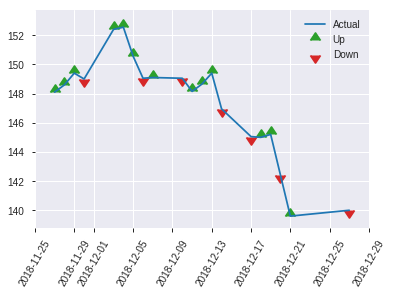


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.20924451135789096
RMSE: 0.45743252109780186
LogLoss: 0.6066018500085273
Mean Per-Class Error: 0.30928381962864715
AUC: 0.737997347480106
pr_auc: 0.7343911345256675
Gini: 0.4759946949602121
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4810290940992002: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      50   66   0.569    (66.0/116.0)
1      13   117  0.1      (13.0/130.0)
Total  63   183  0.3211   (79.0/246.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.481029     0.747604  182
max f2                       0.119302     0.855263  239
max f0point5                 0.654176     0.722892  91
max accuracy                 0.524253     0.686992  170
max precision                0.857391     0.9375    15
max recall                   0.119302     1         239
max specificity              0.938037     0.991379  0
max absolute_mcc             0.654176     0.393517  91
max min_per_class_accuracy   0.620975     0.646552  125
max mean_per_class_accuracy  0.654176     0.690716  91

Gains/Lift Table: Avg response rate: 52.85 %, avg score: 57.29 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121951                   0.917726           1.26154   1.26154            0.666667         0.931817  0.666667                    0.931817            0.0153846       0.0153846                  26.1538   26.1538
    2        0.0203252                   0.911368           1.89231   1.51385            1                0.913803  0.8                         0.924612            0.0153846       0.0307692                  89.2308   51.3846
    3        0.0325203                   0.905182           1.89231   1.65577            1                0.908791  0.875                       0.918679            0.0230769       0.0538462                  89.2308   65.5769
    4        0.0406504                   0.890455           1.89231   1.70308            1                0.899759  0.9                         0.914895            0.0153846       0.0692308                  89.2308   70.3077
    5        0.0528455                   0.882049           1.89231   1.74675            1                0.885783  0.923077                    0.908177            0.0230769       0.0923077                  89.2308   74.6746
    6        0.101626                    0.786033           1.41923   1.58954            0.75             0.831412  0.84                        0.87133             0.0692308       0.161538                   41.9231   58.9538
    7        0.150407                    0.749633           1.41923   1.5343             0.75             0.771292  0.810811                    0.838885            0.0692308       0.230769                   41.9231   53.4304
    8        0.203252                    0.718988           1.31006   1.476              0.692308         0.735502  0.78                        0.812005            0.0692308       0.3                        31.0059   47.6
    9        0.300813                    0.681027           1.34038   1.43202            0.708333         0.696575  0.756757                    0.774568            0.130769        0.430769                   34.0385   43.2017
    10       0.402439                    0.650107           1.36246   1.41445            0.72             0.661396  0.747475                    0.745989            0.138462        0.569231                   36.2462   41.4452
    11       0.5                         0.623729           0.709615  1.27692            0.375            0.635978  0.674797                    0.724524            0.0692308       0.638462                   -29.0385  27.6923
    12       0.601626                    0.570528           1.05969   1.24023            0.56             0.599368  0.655405                    0.703383            0.107692        0.746154                   5.96923   24.0229
    13       0.699187                    0.518864           1.18269   1.2322             0.625            0.547155  0.651163                    0.681583            0.115385        0.861538                   18.2692   23.22
    14       0.800813                    0.400768           0.756923  1.17189            0.4              0.461958  0.619289                    0.653712            0.0769231       0.938462                   -24.3077  17.1886
    15       0.898374                    0.247529           0.236538  1.07031            0.125            0.334191  0.565611                    0.619013            0.0230769       0.961538                   -76.3462  7.03098
    16       1                           0.05057            0.378462  1                  0.2              0.165575  0.528455                    0.572932            0.

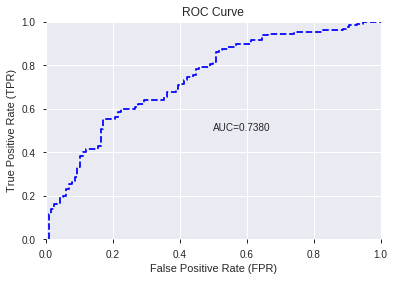

This function is available for GLM models only


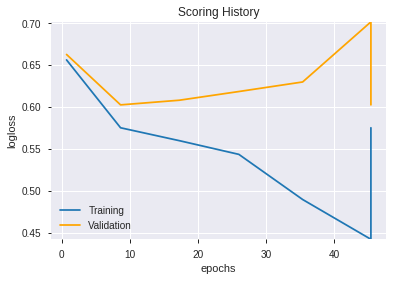

--2019-09-05 21:36:26--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.114.219
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.114.219|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190905_212703_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190905_212703_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_8e55',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'SUB',
 'CDLLONGLINE',
 'STOCHRSI_fastk',
 'day',
 'ULTOSC',
 'AROONOSC_30',
 'STOCH_slowd',
 'CDLSHORTLINE',
 'DIV',
 'MFI_12',
 'TRANGE',
 'dayofyear',
 'month',
 'BETA_20',
 'SIN',
 'CDLDOJI',
 'CDLTAKURI',
 'BETA_12',
 'CORREL_20',
 'weekday_name',
 'HT_TRENDMODE',
 'CORREL_14',
 'dayofweek',
 'HT_DCPERIOD',
 'DX_8',
 'aroonup_30',
 'DX_12',
 'CDLLONGLEGGEDDOJI',
 'DX_14',
 'STOCHF_fastk',
 'CDL3OUTSIDE',
 'CDLENGULFING',
 'WILLR_8',
 'CDLMARUBOZU',
 'STOCHF_fastd',
 'STOCH_slowk',
 'BETA_14',
 'STOCHRSI_fastd',
 'WILLR_20',
 'WILLR_14',
 'CDLHAMMER',
 'WILLR_12',
 'CDLHIKKAKE',
 'CDLDRAGONFLYDOJI',
 'CDLSPINNINGTOP',
 'WILLR_24',
 'BETA_24',
 'CDLBELTHOLD']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190905_213635_model_1  0.739721  0.607544                0.3063  0.455841  0.207791

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.442859           1.000000    0.146547
1   CDLCLOSINGMARUBOZU             0.190357           0.429837    0.062991
2                  SUB             0.184324           0.416213    0.060995
3            CDLHAMMER             0.107795           0.243408    0.035671
4               TRANGE             0.096626           0.218187    0.031975
5       STOCHRSI_fastk             0.094359           0.213067    0.031224
6            CDLTAKURI             0.090399           0.204125    0.029914
7               ULTOSC             0.089339           0.201733    0.029563
8               MFI_12             0.087932           0.198554    0.029098
9           CDLHIKKAKE             0.084930           0.191778    0.028104
10        STOCHF_fastd             0.080586           0.181966    0.026667
11         STOCH_slowk             0.080091           0.180849    0.026503
12         STOCH_slowd             0.076511           0.172767    0.025318
13        STOCHF_fastk             0.074619           0.168495    0.024692
14         CDLLONGLINE             0.071681           0.161860    0.023720
15        CDLENGULFING             0.070856           0.159996    0.023447
16                DX_8             0.070391           0.158946    0.023293
17         CDL3OUTSIDE             0.062268           0.140605    0.020605
18                 SIN             0.061672           0.139258    0.020408
19            WILLR_24             0.057016           0.128744    0.018867
20        weekday_name             0.054528           0.123127    0.018044
21         AROONOSC_30             0.053667           0.121183    0.017759
22             BETA_12             0.052275           0.118040    0.017298
23             BETA_14             0.049394           0.111534    0.016345
24    CDLDRAGONFLYDOJI             0.046403           0.104781    0.015355
25             WILLR_8             0.045233           0.102140    0.014968
26           CORREL_14             0.037173           0.083939    0.012301
27        HT_TRENDMODE             0.035556           0.080287    0.011766
28            WILLR_20             0.034796           0.078571    0.011514
29          aroonup_30             0.034570           0.078060    0.011439
30      CDLSPINNINGTOP             0.034556           0.078028    0.011435
31             BETA_24             0.034059           0.076908    0.011271
32        CDLSHORTLINE             0.032513           0.073416    0.010759
33           CORREL_20             0.032399           0.073159    0.010721
34         CDLMARUBOZU             0.031948           0.072141    0.010572
35         HT_DCPERIOD             0.028980           0.065439    0.009590
36            WILLR_14             0.026583           0.060026    0.008797
37             BETA_20             0.023712           0.053543    0.007847
38            WILLR_12             0.023095           0.052150    0.007642
39               month             0.022995           0.051925    0.007609
40           dayofyear             0.022577           0.050980    0.007471
41         CDLBELTHOLD             0.020197           0.045606    0.006683
42                 day             0.017454           0.039412    0.005776
43               DX_12             0.014334           0.032367    0.004743
44      STOCHRSI_fastd             0.013001           0.029357    0.004302
45           dayofweek             0.012035           0.027175    0.003982
46                 DIV             0.005248           0.011851    0.001737
47               DX_14             0.004074           0.009200    0.001348
48             CDLDOJI             0.002006           0.004530    0.000664
49   CDLLONGLEGGEDDOJI             0.001986           0.004484    0.000657

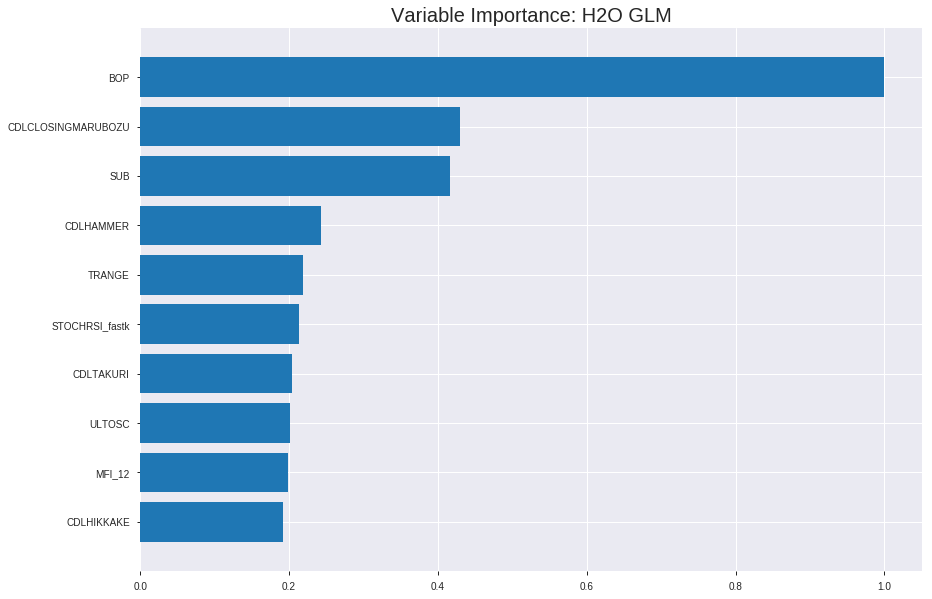

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190905_213635_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.1962685177876877
RMSE: 0.4430220285580478
LogLoss: 0.5766959918481988
Null degrees of freedom: 1721
Residual degrees of freedom: 1671
Null deviance: 2384.1875591118605
Residual deviance: 1986.1409959251966
AIC: 2088.140995925197
AUC: 0.7685084963345833
pr_auc: 0.7648489382847811
Gini: 0.5370169926691666
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4239030734944027: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      430  395   0.4788   (395.0/825.0)
1      134  763   0.1494   (134.0/897.0)
Total  564  1158  0.3072   (529.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.423903     0.742579  252
max f2                       0.220562     0.854344  348
max f0point5                 0.562311     0.726223  180
max accuracy                 0.544083     0.707898  189
max precision                0.955884     1         0
max recall                   0.111938     1         388
max specificity              0.955884     1         0
max absolute_mcc             0.544083     0.417426  189
max min_per_class_accuracy   0.529382     0.70303   197
max mean_per_class_accuracy  0.544083     0.708821  189

Gains/Lift Table: Avg response rate: 52.09 %, avg score: 52.09 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.877693           1.70643   1.70643            0.888889         0.898638  0.888889                    0.898638            0.0178372       0.0178372                  70.6429   70.6429
    2        0.0203252                   0.865818           1.58096   1.64548            0.823529         0.871918  0.857143                    0.88566             0.0156076       0.0334448                  58.0956   64.5485
    3        0.0301974                   0.853493           1.91973   1.73514            1                0.8591    0.903846                    0.876977            0.0189521       0.0523969                  91.9732   73.5143
    4        0.0400697                   0.84422            1.69388   1.72498            0.882353         0.849086  0.898551                    0.870105            0.0167224       0.0691193                  69.3882   72.4977
    5        0.0505226                   0.832632           1.81308   1.74321            0.944444         0.837613  0.908046                    0.863383            0.0189521       0.0880713                  81.3081   74.3205
    6        0.100465                    0.781725           1.62954   1.6867             0.848837         0.804549  0.878613                    0.834136            0.0813824       0.169454                   62.954    68.6701
    7        0.150407                    0.742123           1.49561   1.62325            0.77907          0.762118  0.84556                     0.810223            0.0746934       0.244147                   49.5606   62.3249
    8        0.200348                    0.703075           1.2947    1.54135            0.674419         0.723548  0.802899                    0.788617            0.06466         0.308807                   29.4703   54.135
    9        0.300232                    0.656484           1.40632   1.49643            0.732558         0.679328  0.779497                    0.752257            0.140468        0.449275                   40.6316   49.6426
    10       0.400116                    0.599015           1.32819   1.45443            0.69186          0.627434  0.75762                     0.721097            0.132664        0.58194                    32.8187   45.4427
    11       0.5                         0.532735           1.13845   1.3913             0.593023         0.567536  0.724739                    0.69042             0.113712        0.695652                   13.8446   39.1304
    12       0.599884                    0.469965           0.982189  1.32318            0.511628         0.502558  0.689255                    0.65914             0.0981048       0.793757                   -1.78113  32.3184
    13       0.699768                    0.406967           0.72548   1.23787            0.377907         0.438066  0.644813                    0.627584            0.0724638       0.866221                   -27.452   23.7869
    14       0.799652                    0.334714           0.63619   1.16271            0.331395         0.369249  0.605664                    0.595316            0.0635452       0.929766                   -36.381   16.2714
    15       0.899535                    0.230251           0.479933  1.0869             0.25             0.285949  0.566172                    0.560964            0.0479376       0.977703                   -52.0067  8.68982
    16       1                           0.0407692          0.221934  1                  0.115607         0.162235  0.520906                    0.520906          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.19916628986461662
RMSE: 0.4462805058084171
LogLoss: 0.5927651236783388
Null degrees of freedom: 491
Residual degrees of freedom: 441
Null deviance: 680.4075335465611
Residual deviance: 583.2808816994855
AIC: 685.2808816994855
AUC: 0.7596987941815528
pr_auc: 0.7370370943317194
Gini: 0.5193975883631057
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40034970740728454: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      112  119  0.5152   (119.0/231.0)
1      26   235  0.0996   (26.0/261.0)
Total  138  354  0.2947   (145.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.40035      0.764228  284
max f2                       0.265017     0.866168  339
max f0point5                 0.459791     0.717172  244
max accuracy                 0.459791     0.713415  244
max precision                0.93705      1         0
max recall                   0.000867056  1         399
max specificity              0.93705      1         0
max absolute_mcc             0.40035      0.427964  284
max min_per_class_accuracy   0.530112     0.688312  199
max mean_per_class_accuracy  0.459791     0.706747  244

Gains/Lift Table: Avg response rate: 53.05 %, avg score: 51.81 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.89626            1.50805   1.50805            0.8              0.924048  0.8                         0.924048            0.0153257       0.0153257                  50.8046   50.8046
    2        0.0203252                   0.873559           1.13103   1.31954            0.6              0.883727  0.7                         0.903887            0.0114943       0.0268199                  13.1034   31.954
    3        0.0304878                   0.848833           1.88506   1.50805            1                0.863893  0.8                         0.890556            0.0191571       0.045977                   88.5057   50.8046
    4        0.0406504                   0.828129           1.50805   1.50805            0.8              0.840308  0.8                         0.877994            0.0153257       0.0613027                  50.8046   50.8046
    5        0.050813                    0.819886           1.13103   1.43264            0.6              0.825078  0.76                        0.867411            0.0114943       0.0727969                  13.1034   43.2644
    6        0.101626                    0.766786           1.65885   1.54575            0.88             0.786984  0.82                        0.827197            0.0842912       0.157088                   65.8851   54.5747
    7        0.150407                    0.723767           1.57088   1.5539             0.833333         0.748474  0.824324                    0.801666            0.0766284       0.233716                   57.0881   55.3899
    8        0.20122                     0.689532           1.50805   1.54232            0.8              0.708077  0.818182                    0.778032            0.0766284       0.310345                   50.8046   54.232
    9        0.300813                    0.640632           1.308     1.46474            0.693878         0.660854  0.777027                    0.739237            0.130268        0.440613                   30.7999   46.4741
    10       0.400407                    0.59547            1.15412   1.38748            0.612245         0.619581  0.736041                    0.709475            0.114943        0.555556                   15.4117   38.7479
    11       0.5                         0.535647           1.19259   1.34866            0.632653         0.571016  0.715447                    0.681896            0.118774        0.67433                    19.2587   34.8659
    12       0.599593                    0.478273           1.11565   1.30996            0.591837         0.509149  0.694915                    0.653202            0.111111        0.785441                   11.5646   30.9955
    13       0.699187                    0.414762           0.961764  1.26036            0.510204         0.445947  0.668605                    0.62368             0.0957854       0.881226                   -3.8236   26.0358
    14       0.79878                     0.339577           0.538588  1.17037            0.285714         0.380691  0.620865                    0.593384            0.0536398       0.934866                   -46.1412  17.0366
    15       0.898374                    0.222422           0.500117  1.09606            0.265306         0.291527  0.581448                    0.55992             0.0498084       0.984674                   -49.9883  9.60628
    16       1                           0.000867056        0.150805  1                  0.08             0.148582  0.530488                    0.518118           


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-09-05 21:36:35  0.000 sec   2            21        51            1.36555           1.36491
    2019-09-05 21:36:35  0.068 sec   4            13        51            1.35589           1.35566
    2019-09-05 21:36:35  0.136 sec   6            8.1       51            1.34255           1.34282
    2019-09-05 21:36:35  0.207 sec   8            5         51            1.32524           1.32602
    2019-09-05 21:36:35  0.247 sec   10           3.1       51            1.30424           1.30545
    2019-09-05 21:36:35  0.283 sec   12           1.9       51            1.28045           1.28206
    2019-09-05 21:36:35  0.304 sec   14           1.2       51            1.25541           1.25761
    2019-09-05 21:36:35  0.321 sec   16           0.75      51            1.23085           1.23428
    2019-09-05 21:36:36  0.337 sec   18           0.46      51            1.20853           1.21439
    2019-09-05 21:36:36  0.355 sec   20           0.29      51            1.18959           1.19951
    2019-09-05 21:36:36  0.379 sec   22           0.18      51            1.17437           1.19017
    2019-09-05 21:36:36  0.415 sec   24           0.11      51            1.16251           1.18585
    2019-09-05 21:36:36  0.437 sec   26           0.069     51            1.15339           1.18553
    2019-09-05 21:36:36  0.453 sec   28           0.043     51            1.14641           1.18809
    2019-09-05 21:36:36  0.468 sec   30           0.027     51            1.14112           1.19252
    2019-09-05 21:36:36  0.487 sec   32           0.017     51            1.13722           1.19806
    2019-09-05 21:36:36  0.508 sec   34           0.01      51            1.13443           1.20394
    2019-09-05 21:36:36  0.531 sec   36           0.0064    51            1.13252           1.20958

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7032520325203252)

('F1', 0.7542087542087542)

('auc', 0.7397214854111406)

('logloss', 0.6075440323700345)

('mean_per_class_error', 0.30629973474801053)

('rmse', 0.4558407459017049)

('mse', 0.2077907856242227)

glm prediction progress: |████████████████████████████████████████████████| 100%


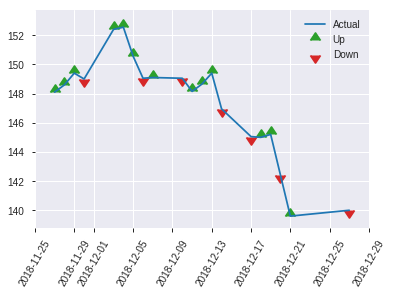


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2077907856242227
RMSE: 0.4558407459017049
LogLoss: 0.6075440323700345
Null degrees of freedom: 245
Residual degrees of freedom: 195
Null deviance: 340.2874392490048
Residual deviance: 298.911663926057
AIC: 400.911663926057
AUC: 0.7397214854111406
pr_auc: 0.7391209837044123
Gini: 0.47944297082228116
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4013689378934738: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      61   55   0.4741   (55.0/116.0)
1      18   112  0.1385   (18.0/130.0)
Total  79   167  0.2967   (73.0/246.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.401369     0.754209  166
max f2                       0.256655     0.851648  207
max f0point5                 0.401369     0.701754  166
max accuracy                 0.401369     0.703252  166
max precision                0.884581     1         0
max recall                   0.028147     1         245
max specificity              0.884581     1         0
max absolute_mcc             0.401369     0.41418   166
max min_per_class_accuracy   0.502791     0.669231  124
max mean_per_class_accuracy  0.401369     0.6937    166

Gains/Lift Table: Avg response rate: 52.85 %, avg score: 48.25 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121951                   0.859113           1.26154   1.26154            0.666667         0.874333  0.666667                    0.874333            0.0153846       0.0153846                  26.1538   26.1538
    2        0.0203252                   0.841681           1.89231   1.51385            1                0.84653   0.8                         0.863212            0.0153846       0.0307692                  89.2308   51.3846
    3        0.0325203                   0.824793           1.89231   1.65577            1                0.837481  0.875                       0.853563            0.0230769       0.0538462                  89.2308   65.5769
    4        0.0406504                   0.803176           1.89231   1.70308            1                0.809256  0.9                         0.844702            0.0153846       0.0692308                  89.2308   70.3077
    5        0.0528455                   0.789997           1.89231   1.74675            1                0.797073  0.923077                    0.83371             0.0230769       0.0923077                  89.2308   74.6746
    6        0.101626                    0.710807           1.73462   1.74092            0.916667         0.75013   0.92                        0.793592            0.0846154       0.176923                   73.4615   74.0923
    7        0.150407                    0.691642           1.41923   1.63659            0.75             0.701443  0.864865                    0.763706            0.0692308       0.246154                   41.9231   63.659
    8        0.203252                    0.657582           1.01893   1.476              0.538462         0.675329  0.78                        0.740728            0.0538462       0.3                        1.89349   47.6
    9        0.300813                    0.593252           1.34038   1.43202            0.708333         0.628933  0.756757                    0.70447             0.130769        0.430769                   34.0385   43.2017
    10       0.402439                    0.552849           1.28677   1.39534            0.68             0.570447  0.737374                    0.670626            0.130769        0.561538                   28.6769   39.5338
    11       0.5                         0.505982           0.946154  1.30769            0.5              0.528767  0.691057                    0.642946            0.0923077       0.653846                   -5.38462  30.7692
    12       0.601626                    0.453695           1.05969   1.2658             0.56             0.478835  0.668919                    0.615225            0.107692        0.761538                   5.96923   26.58
    13       0.699187                    0.379488           1.10385   1.2432             0.583333         0.417052  0.656977                    0.587573            0.107692        0.869231                   10.3846   24.3202
    14       0.800813                    0.288004           0.681231  1.17189            0.36             0.333147  0.619289                    0.555285            0.0692308       0.938462                   -31.8769  17.1886
    15       0.898374                    0.199696           0.236538  1.07031            0.125            0.24507   0.565611                    0.521597            0.0230769       0.961538                   -76.3462  7.03098
    16       1                           0.028147           0.378462  1                  0.2              0.136989  0.528455                    0.482511            0.0

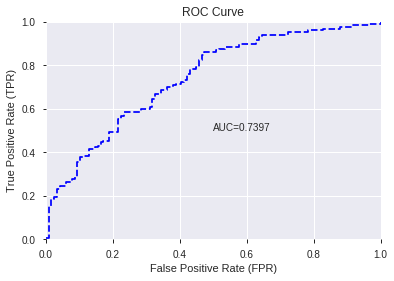

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


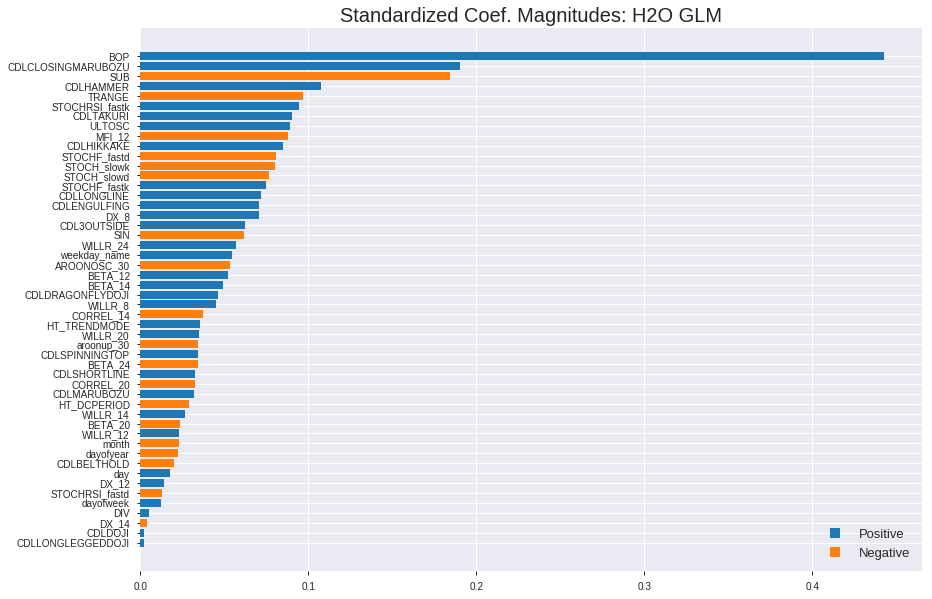

'log_likelihood'
--2019-09-05 21:36:40--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.85.27
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.85.27|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190905_213635_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190905_213635_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_8e55',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['BOP',
 'CDLCLOSINGMARUBOZU',
 'SUB',
 'CDLHAMMER',
 'TRANGE',
 'STOCHRSI_fastk',
 'CDLTAKURI',
 'ULTOSC',
 'MFI_12',
 'CDLHIKKAKE',
 'STOCHF_fastd',
 'STOCH_slowk',
 'STOCH_slowd',
 'STOCHF_fastk',
 'CDLLONGLINE',
 'CDLENGULFING',
 'DX_8',
 'CDL3OUTSIDE',
 'SIN',
 'WILLR_24',
 'weekday_name',
 'AROONOSC_30',
 'BETA_12',
 'BETA_14',
 'CDLDRAGONFLYDOJI',
 'WILLR_8',
 'CORREL_14',
 'HT_TRENDMODE',
 'WILLR_20',
 'aroonup_30',
 'CDLSPINNINGTOP',
 'BETA_24',
 'CDLSHORTLINE',
 'CORREL_20',
 'CDLMARUBOZU',
 'HT_DCPERIOD',
 'WILLR_14',
 'BETA_20',
 'WILLR_12',
 'month',
 'dayofyear',
 'CDLBELTHOLD',
 'day',
 'DX_12',
 'STOCHRSI_fastd',
 'dayofweek',
 'DIV',
 'DX_14',
 'CDLDOJI',
 'CDLLONGLEGGEDDOJI']

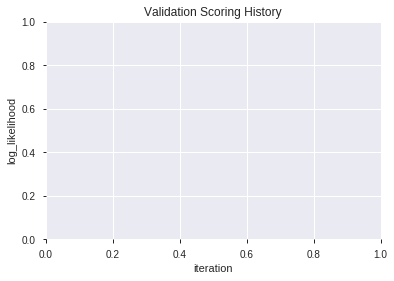

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_2_AutoML_20190905_213648  0.747082  0.596032              0.359284  0.453107  0.205306
1  XGBoost_grid_1_AutoML_20190905_213648_model_6  0.740517  0.599263              0.354509  0.455385  0.207376
2  XGBoost_grid_1_AutoML_20190905_213648_model_3  0.729111  0.607299              0.311538  0.459009  0.210690
3  XGBoost_grid_1_AutoML_20190905_213648_model_4  0.724867  0.610097              0.344960  0.459942  0.211547
4  XGBoost_grid_1_AutoML_20190905_213648_model_7  0.723740  0.617736              0.320159  0.463084  0.214447
5  XGBoost_grid_1_AutoML_20190905_213648_model_1  0.722745  0.611418              0.326923  0.461308  0.212805
6  XGBoost_grid_1_AutoML_20190905_213648_model_5  0.722082  0.626042              0.326923  0.467703  0.218746
7               XGBoost_3_AutoML_20190905_213648  0.721154  0.615781              0.310610  0.462131  0.213565
8  XGBoost_grid_1_AutoML_20190905_213648_model_2  0.717772  0.616528              0.357891  0.463579  0.214905
9               XGBoost_1_AutoML_20190905_213648  0.716247  0.621642              0.319231  0.465454  0.216648

variable  relative_importance  scaled_importance  percentage
0                  BOP          1941.208374           1.000000    0.287737
1                  SUB           312.607208           0.161037    0.046336
2         STOCHF_fastk           297.505035           0.153258    0.044098
3                DX_14           271.826294           0.140029    0.040292
4                  SIN           245.894257           0.126671    0.036448
5          STOCH_slowk           227.811386           0.117355    0.033768
6                 DX_8           211.273865           0.108836    0.031316
7               TRANGE           201.008881           0.103548    0.029795
8       STOCHRSI_fastk           192.640289           0.099237    0.028554
9          STOCH_slowd           172.656540           0.088943    0.025592
10             WILLR_8           160.094910           0.082472    0.023730
11              ULTOSC           159.189606           0.082005    0.023596
12             BETA_14           152.438919           0.078528    0.022595
13             BETA_20           150.939774           0.077756    0.022373
14           CORREL_20           149.250687           0.076885    0.022123
15                 DIV           143.490250           0.073918    0.021269
16              MFI_12           133.932373           0.068994    0.019852
17           dayofyear           131.005402           0.067487    0.019418
18             BETA_24           127.817444           0.065844    0.018946
19         HT_DCPERIOD           125.666016           0.064736    0.018627
20               DX_12           111.648018           0.057515    0.016549
21            WILLR_24           102.141121           0.052617    0.015140
22            WILLR_14            95.762459           0.049331    0.014194
23           CORREL_14            92.862358           0.047837    0.013765
24  CDLCLOSINGMARUBOZU            87.308472           0.044976    0.012941
25        STOCHF_fastd            82.319099           0.042406    0.012202
26                 day            81.358665           0.041911    0.012059
27             BETA_12            77.546043           0.039947    0.011494
28            WILLR_20            76.805382           0.039566    0.011385
29            WILLR_12            74.732193           0.038498    0.011077
30          aroonup_30            70.537460           0.036337    0.010455
31         AROONOSC_30            60.714211           0.031277    0.008999
32      STOCHRSI_fastd            55.221592           0.028447    0.008185
33        weekday_name            38.672508           0.019922    0.005732
34           dayofweek            37.532894           0.019335    0.005563
35               month            24.056469           0.012393    0.003566
36      CDLSPINNINGTOP            22.810394           0.011751    0.003381
37         CDLLONGLINE            22.689232           0.011688    0.003363
38         CDLBELTHOLD            15.917310           0.008200    0.002359
39        HT_TRENDMODE             7.572731           0.003901    0.001122

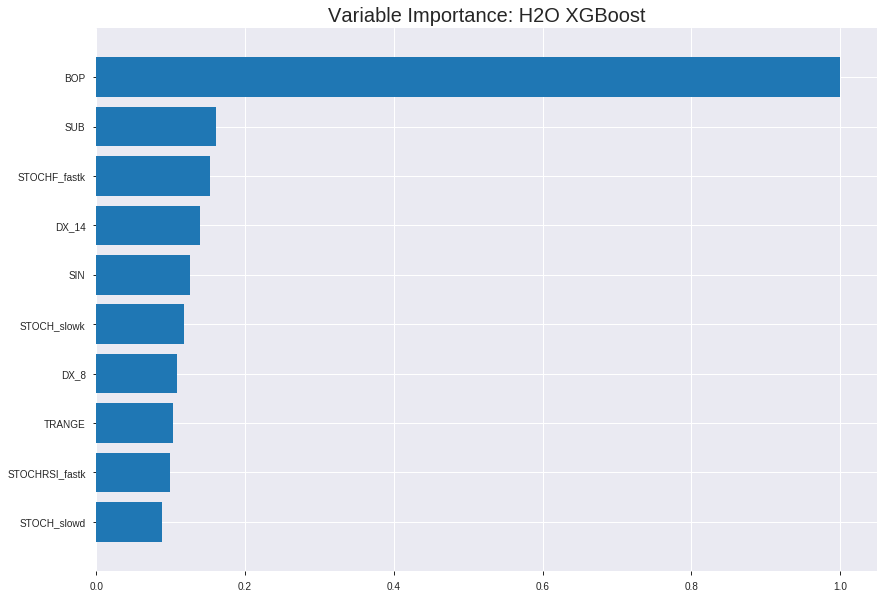

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_2_AutoML_20190905_213648


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.14934816122229738
RMSE: 0.3864558981595408
LogLoss: 0.46996639525024037
Mean Per-Class Error: 0.19342454646802476
AUC: 0.8886503834329922
pr_auc: 0.8990838750630228
Gini: 0.7773007668659844
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4869251549243927: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      614  211  0.2558   (211.0/825.0)
1      126  771  0.1405   (126.0/897.0)
Total  740  982  0.1957   (337.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.486925     0.820649  212
max f2                       0.267401     0.885009  317
max f0point5                 0.617728     0.838603  144
max accuracy                 0.538006     0.806039  185
max precision                0.905024     1         0
max recall                   0.180127     1         358
max specificity              0.905024     1         0
max absolute_mcc             0.538006     0.612615  185
max min_per_class_accuracy   0.531381     0.802424  189
max mean_per_class_accuracy  0.538006     0.806575  185

Gains/Lift Table: Avg response rate: 52.09 %, avg score: 51.84 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.86237            1.91973    1.91973            1                0.883673  1                           0.883673            0.0200669       0.0200669                  91.9732   91.9732
    2        0.0203252                   0.847952           1.91973    1.91973            1                0.854073  1                           0.869296            0.0189521       0.039019                   91.9732   91.9732
    3        0.0301974                   0.841724           1.91973    1.91973            1                0.843854  1                           0.860978            0.0189521       0.057971                   91.9732   91.9732
    4        0.0400697                   0.834774           1.91973    1.91973            1                0.837501  1                           0.855194            0.0189521       0.0769231                  91.9732   91.9732
    5        0.0505226                   0.828632           1.91973    1.91973            1                0.831856  1                           0.850366            0.0200669       0.09699                    91.9732   91.9732
    6        0.100465                    0.802815           1.87509    1.89754            0.976744         0.816233  0.988439                    0.833398            0.0936455       0.190635                   87.5088   89.7539
    7        0.150407                    0.77669            1.85277    1.88267            0.965116         0.790123  0.980695                    0.819029            0.0925307       0.283166                   85.2765   88.2672
    8        0.200348                    0.749318           1.74115    1.84739            0.906977         0.762535  0.962319                    0.804946            0.0869565       0.370123                   74.1153   84.7395
    9        0.300232                    0.691389           1.66302    1.78606            0.866279         0.722647  0.930368                    0.777566            0.166109        0.536232                   66.3024   78.6057
    10       0.400116                    0.615649           1.47328    1.70798            0.767442         0.651987  0.889695                    0.746217            0.147157        0.683389                   47.3283   70.7977
    11       0.5                         0.537398           1.10496    1.58751            0.575581         0.578237  0.826945                    0.71266             0.110368        0.793757                   10.4962   58.7514
    12       0.599884                    0.459594           0.837093   1.46256            0.436047         0.502386  0.761859                    0.677648            0.083612        0.877369                   -16.2907  46.2565
    13       0.699768                    0.365656           0.546901   1.33186            0.284884         0.415266  0.693776                    0.640196            0.0546265       0.931996                   -45.3099  33.1864
    14       0.799652                    0.278372           0.446449   1.22127            0.232558         0.323847  0.636166                    0.600681            0.0445931       0.976589                   -55.3551  22.1268
    15       0.899535                    0.192901           0.189741   1.10673            0.0988372        0.235924  0.576501                    0.560179            0.0189521       0.995541                   -81.0259  10.6728
    16       1                           0.0761582          0.0443869  1                  0.0231214        0.144405  0.520906                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.20269051165029506
RMSE: 0.4502116298478917
LogLoss: 0.5906915205711888
Mean Per-Class Error: 0.3004926108374384
AUC: 0.740533412947206
pr_auc: 0.7376873017679977
Gini: 0.48106682589441196
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34960609674453735: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      104  127  0.5498   (127.0/231.0)
1      25   236  0.0958   (25.0/261.0)
Total  129  363  0.3089   (152.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.349606     0.75641   286
max f2                       0.167981     0.863333  367
max f0point5                 0.479672     0.712773  224
max accuracy                 0.431734     0.707317  245
max precision                0.908062     1         0
max recall                   0.119826     1         389
max specificity              0.908062     1         0
max absolute_mcc             0.431734     0.414929  245
max min_per_class_accuracy   0.546644     0.675325  196
max mean_per_class_accuracy  0.431734     0.699507  245

Gains/Lift Table: Avg response rate: 53.05 %, avg score: 51.78 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.839008           1.88506   1.88506            1                0.866862  1                           0.866862            0.0191571       0.0191571                  88.5057   88.5057
    2        0.0203252                   0.825337           1.88506   1.88506            1                0.831956  1                           0.849409            0.0191571       0.0383142                  88.5057   88.5057
    3        0.0304878                   0.818667           1.88506   1.88506            1                0.823692  1                           0.840837            0.0191571       0.0574713                  88.5057   88.5057
    4        0.0406504                   0.803153           1.88506   1.88506            1                0.811754  1                           0.833566            0.0191571       0.0766284                  88.5057   88.5057
    5        0.050813                    0.800981           1.13103   1.73425            0.6              0.801749  0.92                        0.827203            0.0114943       0.0881226                  13.1034   73.4253
    6        0.101626                    0.769388           1.50805   1.62115            0.8              0.783551  0.86                        0.805377            0.0766284       0.164751                   50.8046   62.1149
    7        0.150407                    0.740136           1.02107   1.42653            0.541667         0.752194  0.756757                    0.788128            0.0498084       0.214559                   2.10728   42.653
    8        0.20122                     0.717818           1.05563   1.33287            0.56             0.727612  0.707071                    0.772846            0.0536398       0.268199                   5.56322   33.2869
    9        0.300813                    0.682316           1.42341   1.36285            0.755102         0.697851  0.722973                    0.748017            0.141762        0.409962                   42.3411   36.2846
    10       0.400407                    0.635374           1.34647   1.35877            0.714286         0.657654  0.720812                    0.725541            0.1341          0.544061                   34.647    35.8772
    11       0.5                         0.556958           1.15412   1.31801            0.612245         0.603255  0.699187                    0.701183            0.114943        0.659004                   15.4117   31.8008
    12       0.599593                    0.474426           1.23106   1.30357            0.653061         0.510569  0.691525                    0.669522            0.122605        0.781609                   23.1058   30.3565
    13       0.699187                    0.385329           0.884823  1.24392            0.469388         0.428305  0.659884                    0.635163            0.0881226       0.869732                   -11.5177  24.3919
    14       0.79878                     0.295827           0.69247   1.17516            0.367347         0.336823  0.62341                     0.597965            0.0689655       0.938697                   -30.753   17.5163
    15       0.898374                    0.203628           0.384706  1.08753            0.204082         0.250617  0.576923                    0.559458            0.0383142       0.977011                   -61.5294  8.75332
    16       1                           0.0876887          0.226207  1                  0.12             0.14955   0.530488                    0.517801          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-05 21:36:59  0.003 sec   0                  0.5              0.693147            0.5             0                  1                0.479094                         0.5                0.693147              0.5               0                    1                  0.469512
    2019-09-05 21:36:59  0.095 sec   5                  0.47591          0.64586             0.811282        0.820186           1.91973          0.28223                          0.482138           0.657869              0.736578          0.728061             1.88506            0.29878
    2019-09-05 21:36:59  0.140 sec   10                 0.458394         0.612106            0.832019        0.843472           1.91973          0.261905                         0.470364           0.634729              0.742731          0.727235             1.50805            0.306911
    2019-09-05 21:36:59  0.214 sec   15                 0.444549         0.585479            0.841713        0.851641           1.91973          0.245645                         0.463454           0.620812              0.742524          0.740475             1.88506            0.321138
    2019-09-05 21:36:59  0.287 sec   20                 0.433152         0.563139            0.847652        0.859978           1.91973          0.251452                         0.457504           0.608467              0.74254           0.741819             1.88506            0.323171
    2019-09-05 21:36:59  0.338 sec   25                 0.424841         0.54662             0.852389        0.863809           1.91973          0.24971                          0.454083           0.601006              0.740956          0.742559             1.88506            0.315041
    2019-09-05 21:36:59  0.405 sec   30                 0.417019         0.530856            0.856866        0.868385           1.91973          0.243322                         0.452353           0.596826              0.739041          0.737667             1.88506            0.313008
    2019-09-05 21:36:59  0.481 sec   35                 0.410501         0.517654            0.861224        0.873842           1.91973          0.232869                         0.453112           0.598015              0.734488          0.731137             1.88506            0.323171
    2019-09-05 21:36:59  0.556 sec   40                 0.404756         0.506129            0.867494        0.880011           1.91973          0.224739                         0.451713           0.594612              0.738585          0.739305             1.88506            0.288618
    2019-09-05 21:36:59  0.634 sec   45                 0.39937          0.495426            0.873979        0.886341           1.91973          0.218351                         0.450815           0.59251               0.738618          0.73483              1.88506            0.302846
    2019-09-05 21:37:00  0.698 sec   50                 0.395206         0.486751            0.877447        0.890669           1.91973          0.218931                         0.450602           0.591503              0.738709          0.735277             1.88506            0.313008
    2019-09-05 21:37:00  0.753 sec   55                 0.390761         0.478175            0.883283        0.893769           1.91973          0.203833                         0.450478           0.591072              0.738842          0.

Variable Importances: 


variable        relative_importance    scaled_importance     percentage
--------------  ---------------------  --------------------  ---------------------
BOP             1941.2083740234375     1.0                   0.2877370670565389
SUB             312.6072082519531      0.1610374303115276    0.046336437884160725
STOCHF_fastk    297.5050354003906      0.15325765094644014   0.04409790698730348
DX_14           271.8262939453125      0.14002942578591543   0.040291656277250586
SIN             245.89425659179688     0.12667071700404073   0.036447860592691526
---             ---                    ---                   ---
month           24.056468963623047     0.012392522763417976  0.003565788153377283
CDLSPINNINGTOP  22.810394287109375     0.011750616055622873  0.003381087799952401
CDLLONGLINE     22.689231872558594     0.011688200080000608  0.0033631284101893785
CDLBELTHOLD     15.917309761047363     0.008199691477765685  0.0023593551765807956
HT_TRENDMODE    7.572731018066406      0.003901039743801855  0.0011224737343525377


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6951219512195121)

('F1', 0.746987951807229)

('auc', 0.7470822281167109)

('logloss', 0.5960315870745704)

('mean_per_class_error', 0.30948275862068964)

('rmse', 0.4531065597097359)

('mse', 0.20530555445199244)

xgboost prediction progress: |████████████████████████████████████████████| 100%


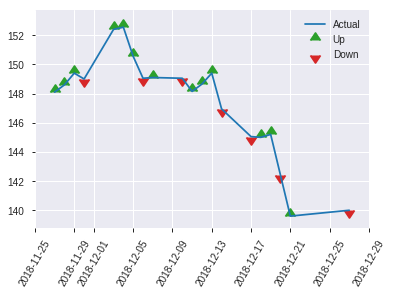


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.20530555445199244
RMSE: 0.4531065597097359
LogLoss: 0.5960315870745704
Mean Per-Class Error: 0.30948275862068964
AUC: 0.7470822281167109
pr_auc: 0.7593248158687287
Gini: 0.49416445623342176
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2485848218202591: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      38   78   0.6724   (78.0/116.0)
1      6    124  0.0462   (6.0/130.0)
Total  44   202  0.3415   (84.0/246.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.248585     0.746988  201
max f2                       0.248585     0.858726  201
max f0point5                 0.50635      0.708723  127
max accuracy                 0.395497     0.695122  156
max precision                0.868085     1         0
max recall                   0.121475     1         240
max specificity              0.868085     1         0
max absolute_mcc             0.395497     0.390329  156
max min_per_class_accuracy   0.512225     0.681034  125
max mean_per_class_accuracy  0.50635      0.690517  127

Gains/Lift Table: Avg response rate: 52.85 %, avg score: 49.02 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121951                   0.836667           1.89231   1.89231            1                0.853311  1                           0.853311            0.0230769       0.0230769                  89.2308   89.2308
    2        0.0203252                   0.828517           1.89231   1.89231            1                0.833557  1                           0.84541             0.0153846       0.0384615                  89.2308   89.2308
    3        0.0325203                   0.821465           1.89231   1.89231            1                0.825205  1                           0.837833            0.0230769       0.0615385                  89.2308   89.2308
    4        0.0406504                   0.806244           1.89231   1.89231            1                0.815107  1                           0.833288            0.0153846       0.0769231                  89.2308   89.2308
    5        0.0528455                   0.797952           1.26154   1.74675            0.666667         0.801129  0.923077                    0.825866            0.0153846       0.0923077                  26.1538   74.6746
    6        0.101626                    0.773513           1.41923   1.58954            0.75             0.786147  0.84                        0.806801            0.0692308       0.161538                   41.9231   58.9538
    7        0.150407                    0.731007           1.73462   1.63659            0.916667         0.756828  0.864865                    0.790594            0.0846154       0.246154                   73.4615   63.659
    8        0.203252                    0.693797           1.31006   1.55169            0.692308         0.712369  0.82                        0.770255            0.0692308       0.315385                   31.0059   55.1692
    9        0.300813                    0.646612           1.26154   1.45759            0.666667         0.673702  0.77027                     0.738941            0.123077        0.438462                   26.1538   45.7588
    10       0.402439                    0.592219           1.13538   1.37622            0.6              0.615759  0.727273                    0.707834            0.115385        0.553846                   13.5385   37.6224
    11       0.5                         0.517966           1.10385   1.32308            0.583333         0.556709  0.699187                    0.678346            0.107692        0.661538                   10.3846   32.3077
    12       0.601626                    0.415675           1.05969   1.27859            0.56             0.467252  0.675676                    0.642689            0.107692        0.769231                   5.96923   27.8586
    13       0.699187                    0.342101           0.946154  1.2322             0.5              0.379089  0.651163                    0.605907            0.0923077       0.861538                   -5.38462  23.22
    14       0.800813                    0.255884           0.681231  1.16228            0.36             0.291545  0.614213                    0.566014            0.0692308       0.930769                   -31.8769  16.228
    15       0.898374                    0.190075           0.394231  1.07887            0.208333         0.229352  0.570136                    0.529453            0.0384615       0.969231                   -60.5769  7.88723
    16       1                           0.10206            0.302769  1                  0.16             0.143654  0.528455                    0.490246            0

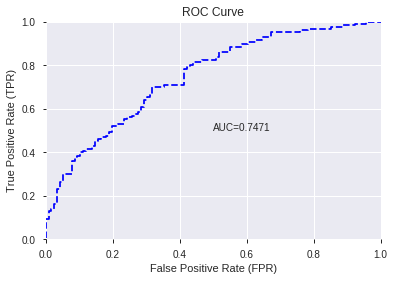

This function is available for GLM models only


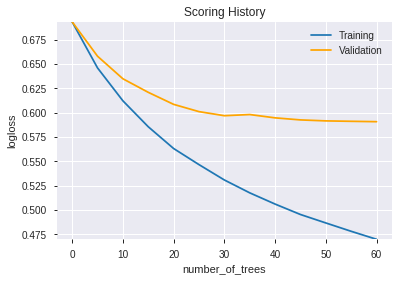

--2019-09-05 21:37:17--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.9.35
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.9.35|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip


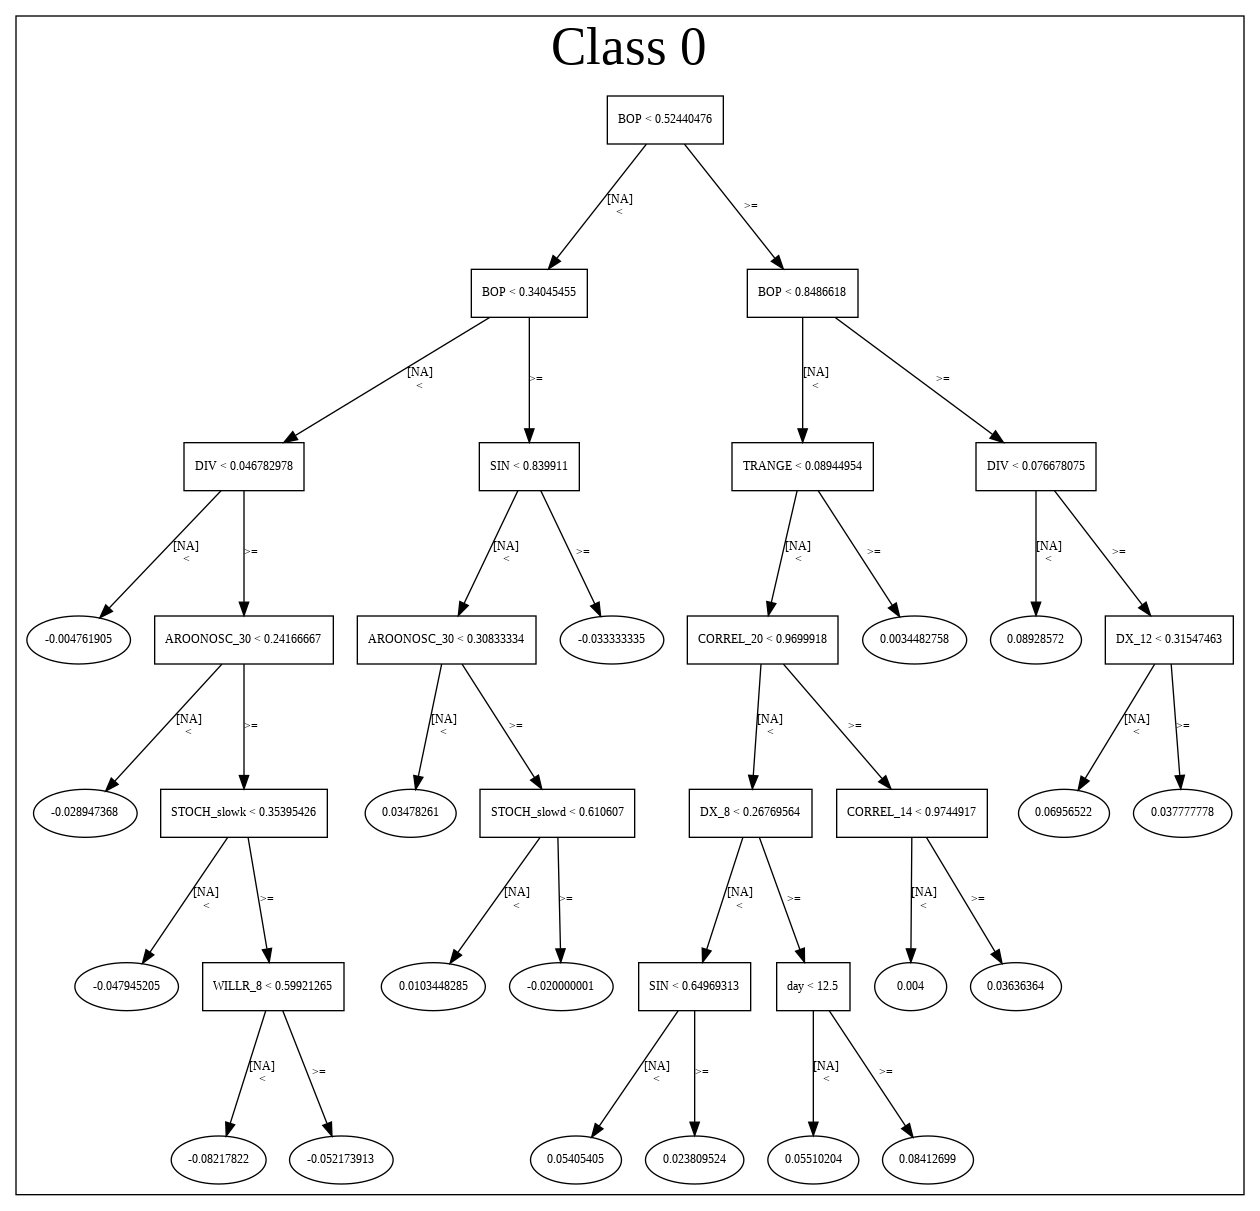

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_2_AutoML_20190905_213648',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_2_AutoML_20190905_213648',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_8e55',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_26_sid_8e55',
   'type

['BOP',
 'SUB',
 'STOCHF_fastk',
 'DX_14',
 'SIN',
 'STOCH_slowk',
 'DX_8',
 'TRANGE',
 'STOCHRSI_fastk',
 'STOCH_slowd',
 'WILLR_8',
 'ULTOSC',
 'BETA_14',
 'BETA_20',
 'CORREL_20',
 'DIV',
 'MFI_12',
 'dayofyear',
 'BETA_24',
 'HT_DCPERIOD',
 'DX_12',
 'WILLR_24',
 'WILLR_14',
 'CORREL_14',
 'CDLCLOSINGMARUBOZU',
 'STOCHF_fastd',
 'day',
 'BETA_12',
 'WILLR_20',
 'WILLR_12',
 'aroonup_30',
 'AROONOSC_30',
 'STOCHRSI_fastd',
 'weekday_name',
 'dayofweek',
 'month',
 'CDLSPINNINGTOP',
 'CDLLONGLINE',
 'CDLBELTHOLD',
 'HT_TRENDMODE']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc    logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190905_213727_model_1  0.487401  17.106331                   0.5  0.722427  0.521901

variable  relative_importance  scaled_importance  percentage
0                         BOP             0.009291           1.000000    0.026842
1          CDLCLOSINGMARUBOZU             0.006304           0.678492    0.018212
2                 CDLLONGLINE             0.005861           0.630764    0.016931
3              STOCHRSI_fastk             0.005556           0.597951    0.016050
4                STOCHF_fastk             0.005455           0.587077    0.015758
...                       ...                  ...                ...         ...
1036  BBANDS_lowerband_12_0_4             0.000002           0.000168    0.000005
1037                      Low             0.000001           0.000127    0.000003
1038             HT_TRENDMODE             0.000000           0.000000    0.000000
1039         CDLCOUNTERATTACK             0.000000           0.000000    0.000000
1040      CDLGAPSIDESIDEWHITE             0.000000           0.000000    0.000000

[1041 rows x 4 columns]

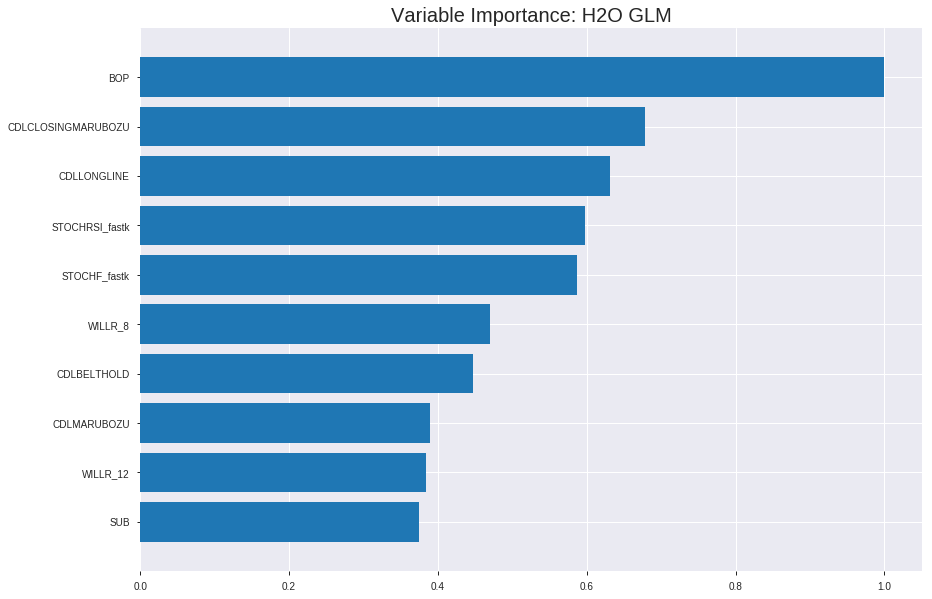

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190905_213727_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24277302342557242
RMSE: 0.4927200253953277
LogLoss: 0.6786143957239151
Null degrees of freedom: 1721
Residual degrees of freedom: 683
Null deviance: 2384.1875591118605
Residual deviance: 2337.1479788731635
AIC: 4415.147978873163
AUC: 0.6273301577649404
pr_auc: 0.6381534869499054
Gini: 0.2546603155298808
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4734266740599164: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      135  690   0.8364   (690.0/825.0)
1      58   839   0.0647   (58.0/897.0)
Total  193  1529  0.4344   (748.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.473427     0.691674  325
max f2                       0.418048     0.844792  398
max f0point5                 0.505041     0.613624  241
max accuracy                 0.51586      0.595819  211
max precision                0.637997     1         0
max recall                   0.418048     1         398
max specificity              0.637997     1         0
max absolute_mcc             0.51586      0.18755   211
max min_per_class_accuracy   0.523392     0.584242  188
max mean_per_class_accuracy  0.51586      0.592679  211

Gains/Lift Table: Avg response rate: 52.09 %, avg score: 52.09 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.595305           1.59978   1.59978            0.833333         0.608636  0.833333                    0.608636            0.0167224       0.0167224                  59.9777   59.9777
    2        0.0203252                   0.585018           1.35511   1.48094            0.705882         0.58975   0.771429                    0.599463            0.0133779       0.0301003                  35.5105   48.0936
    3        0.0301974                   0.580108           1.35511   1.4398             0.705882         0.582747  0.75                        0.593998            0.0133779       0.0434783                  35.5105   43.9799
    4        0.0400697                   0.576453           1.58096   1.47458            0.823529         0.577956  0.768116                    0.590046            0.0156076       0.0590858                  58.0956   47.4577
    5        0.0505226                   0.573244           1.38647   1.45635            0.722222         0.574827  0.758621                    0.586897            0.0144928       0.0735786                  38.6473   45.6349
    6        0.100465                    0.564411           1.42864   1.44257            0.744186         0.568153  0.751445                    0.577579            0.0713489       0.144928                   42.8638   44.2574
    7        0.150407                    0.55786            1.16077   1.349              0.604651         0.561128  0.702703                    0.572117            0.057971        0.202899                   16.0768   34.9001
    8        0.200348                    0.551499           1.11612   1.29095            0.581395         0.554604  0.672464                    0.567751            0.0557414       0.25864                    11.6124   29.0951
    9        0.300232                    0.542586           1.13845   1.24021            0.593023         0.547057  0.646035                    0.560866            0.113712        0.372352                   13.8446   24.0214
    10       0.400116                    0.533845           1.06032   1.19531            0.552326         0.538572  0.622642                    0.555301            0.105909        0.478261                   6.03173   19.5305
    11       0.5                         0.524009           1.03799   1.16388            0.540698         0.528838  0.606272                    0.550014            0.103679        0.58194                    3.79949   16.388
    12       0.599884                    0.513622           1.04916   1.14478            0.546512         0.518611  0.596321                    0.544786            0.104794        0.686734                   4.91561   14.4778
    13       0.699768                    0.502475           0.948705  1.11679            0.494186         0.507985  0.581743                    0.539533            0.0947603       0.781494                   -5.1295   11.679
    14       0.799652                    0.489291           0.848254  1.08325            0.44186          0.496161  0.56427                     0.534115            0.0847269       0.866221                   -15.1746  8.32477
    15       0.899535                    0.470887           0.736642  1.04476            0.383721         0.480658  0.544222                    0.528179            0.0735786       0.939799                   -26.3358  4.47608
    16       1                           0.413944           0.599223  1                  0.312139         0.455782  0.520906                    0.520906           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.3202119150702049
RMSE: 0.5658727021779765
LogLoss: 4.97944652992142
Null degrees of freedom: 491
Residual degrees of freedom: -547
Null deviance: 680.4075335465611
Residual deviance: 72413.55574287781
AIC: 74491.55574287781
AUC: 0.5705329153605017
pr_auc: 0.604788616666947
Gini: 0.14106583072100332
Confusion Matrix (Act/Pred) for max f1 @ threshold = 1.6994468644093692e-50: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    231  1        (231.0/231.0)
1      0    261  0        (0.0/261.0)
Total  0    492  0.4695   (231.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       1.69945e-50  0.693227  384
max f2                       1.69945e-50  0.849609  384
max f0point5                 0.456273     0.598905  299
max accuracy                 0.456305     0.571138  297
max precision                0.554987     1         0
max recall                   1.69945e-50  1         384
max specificity              0.554987     1         0
max absolute_mcc             0.503508     0.184496  112
max min_per_class_accuracy   0.471501     0.558442  247
max mean_per_class_accuracy  0.503508     0.577748  112

Gains/Lift Table: Avg response rate: 53.05 %, avg score: 34.93 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0101626                   0.539675           1.50805   1.50805            0.8              0.54668     0.8                         0.54668             0.0153257       0.0153257                  50.8046    50.8046
    2        0.0203252                   0.536091           1.50805   1.50805            0.8              0.537776    0.8                         0.542228            0.0153257       0.0306513                  50.8046    50.8046
    3        0.0304878                   0.531692           0.754023  1.2567             0.4              0.534613    0.666667                    0.539689            0.00766284      0.0383142                  -24.5977   25.6705
    4        0.0406504                   0.528317           1.50805   1.31954            0.8              0.529348    0.7                         0.537104            0.0153257       0.0536398                  50.8046    31.954
    5        0.050813                    0.526371           0.754023  1.20644            0.4              0.527732    0.64                        0.53523             0.00766284      0.0613027                  -24.5977   20.6437
    6        0.101626                    0.519872           1.28184   1.24414            0.68             0.523326    0.66                        0.529278            0.0651341       0.126437                   28.1839    24.4138
    7        0.150407                    0.513234           1.2567    1.24821            0.666667         0.516437    0.662162                    0.525113            0.0613027       0.187739                   25.6705    24.8214
    8        0.20122                     0.50726            1.43264   1.29479            0.76             0.510086    0.686869                    0.521318            0.0727969       0.260536                   43.2644    29.4787
    9        0.300813                    0.49431            1.00023   1.19727            0.530612         0.500762    0.635135                    0.514513            0.0996169       0.360153                   0.0234577  19.7266
    10       0.400407                    0.483033           0.961764  1.13869            0.510204         0.488737    0.604061                    0.508101            0.0957854       0.455939                   -3.8236    13.869
    11       0.5                         0.471867           1.00023   1.11111            0.530612         0.477511    0.589431                    0.502008            0.0996169       0.555556                   0.0234577  11.1111
    12       0.599593                    0.457062           1.00023   1.09269            0.530612         0.465514    0.579661                    0.495947            0.0996169       0.655172                   0.0234577  9.26943
    13       0.699187                    0.388577           0.577058  1.01925            0.306122         0.439321    0.540698                    0.487881            0.0574713       0.712644                   -42.2942   1.92462
    14       0.79878                     7.91462e-119       0.961764  1.01208            0.510204         0.0816498   0.536896                    0.437231            0.0957854       0.808429                   -3.8236    1.20792
    15       1                           0                  0.952049  1                  0.505051         5.368e-146  0.530488                    0.349252            0.191571        1                          -4.79508   0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-09-05 21:37:30  0.000 sec   2            21        1039          1.35723           147.182
    2019-09-05 21:37:32  1.984 sec   4            15        1040          1.35042           151.32
    2019-09-05 21:37:34  3.965 sec   6            11        1040          1.34199           155.585
    2019-09-05 21:37:36  5.965 sec   8            8.1       1040          1.33188           159.312
    2019-09-05 21:37:38  7.900 sec   10           5.9       1042          1.31994           163.857

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5284552845528455)

('F1', 0.6914893617021277)

('auc', 0.4874005305039788)

('logloss', 17.10633131815842)

('mean_per_class_error', 0.49615384615384617)

('rmse', 0.722427124192534)

('mse', 0.5219009497690948)

glm prediction progress: |████████████████████████████████████████████████| 100%


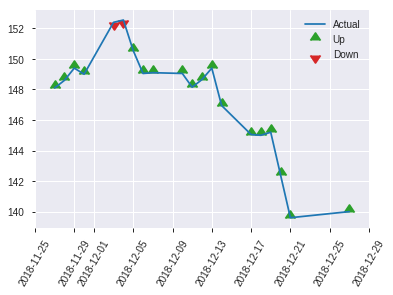


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.5219009497690948
RMSE: 0.722427124192534
LogLoss: 17.10633131815842
Null degrees of freedom: 245
Residual degrees of freedom: -793
Null deviance: 340.2874392490048
Residual deviance: 152635.38107883002
AIC: 154713.38107883002
AUC: 0.4874005305039788
pr_auc: 0.4970491724684106
Gini: -0.025198938992042397
Confusion Matrix (Act/Pred) for max f1 @ threshold = 7.485956817345195e-51: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    116  1        (116.0/116.0)
1      0    130  0        (0.0/130.0)
Total  0    246  0.4715   (116.0/246.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       7.48596e-51  0.691489   35
max f2                       7.48596e-51  0.848564   35
max f0point5                 7.48596e-51  0.583483   35
max accuracy                 7.48596e-51  0.528455   35
max precision                0.421036     1          0
max recall                   7.48596e-51  1          35
max specificity              0.421036     1          0
max absolute_mcc             0.00285473   0.0843031  13
max min_per_class_accuracy   7.61001e-40  0.130769   32
max mean_per_class_accuracy  0.421036     0.503846   0

Gains/Lift Table: Avg response rate: 52.85 %, avg score:  1.25 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score         cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ------------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121951                   0.39883            0.630769  0.630769           0.333333         0.415659      0.333333                    0.415659            0.00769231      0.00769231                 -36.9231  -36.9231
    2        0.0203252                   0.347547           0.946154  0.756923           0.5              0.371749      0.4                         0.398095            0.00769231      0.0153846                  -5.38462  -24.3077
    3        0.0325203                   0.171625           1.26154   0.946154           0.666667         0.27251       0.5                         0.351001            0.0153846       0.0307692                  26.1538   -5.38462
    4        0.0406504                   0.0563107          0         0.756923           0                0.0794403     0.4                         0.296689            0               0.0307692                  -100      -24.3077
    5        0.0528455                   0.00303352         0.630769  0.727811           0.333333         0.0360995     0.384615                    0.236553            0.00769231      0.0384615                  -36.9231  -27.2189
    6        0.101626                    1.04852e-14        1.10385   0.908308           0.583333         0.000349686   0.48                        0.123175            0.0538462       0.0923077                  10.3846   -9.16923
    7        0.150407                    1.49628e-51        0.946154  0.920582           0.5              2.95059e-16   0.486486                    0.0832266           0.0461538       0.138462                   -5.38462  -7.94179
    8        0.203252                    2.89943e-167       1.01893   0.946154           0.538462         1.1703e-62    0.5                         0.0615877           0.0538462       0.192308                   1.89349   -5.38462
    9        1                           0                  1.01374   1                  0.535714         5.15133e-178  0.528455                    0.0125178           0.807692        1                          1.37363   0

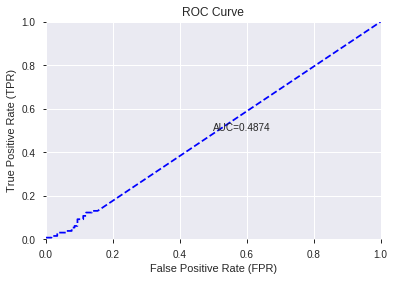

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


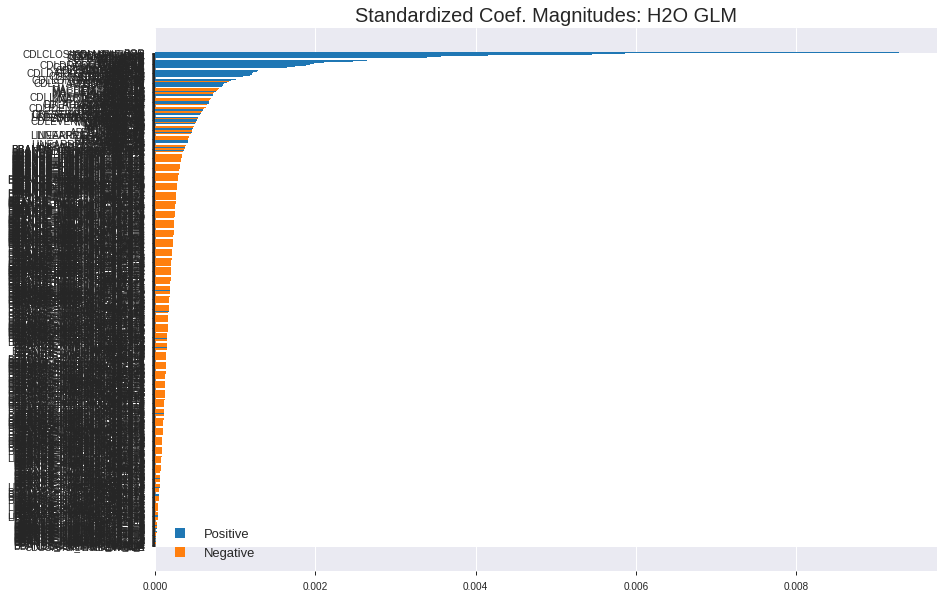

'log_likelihood'
--2019-09-05 21:37:59--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.106.124
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.106.124|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


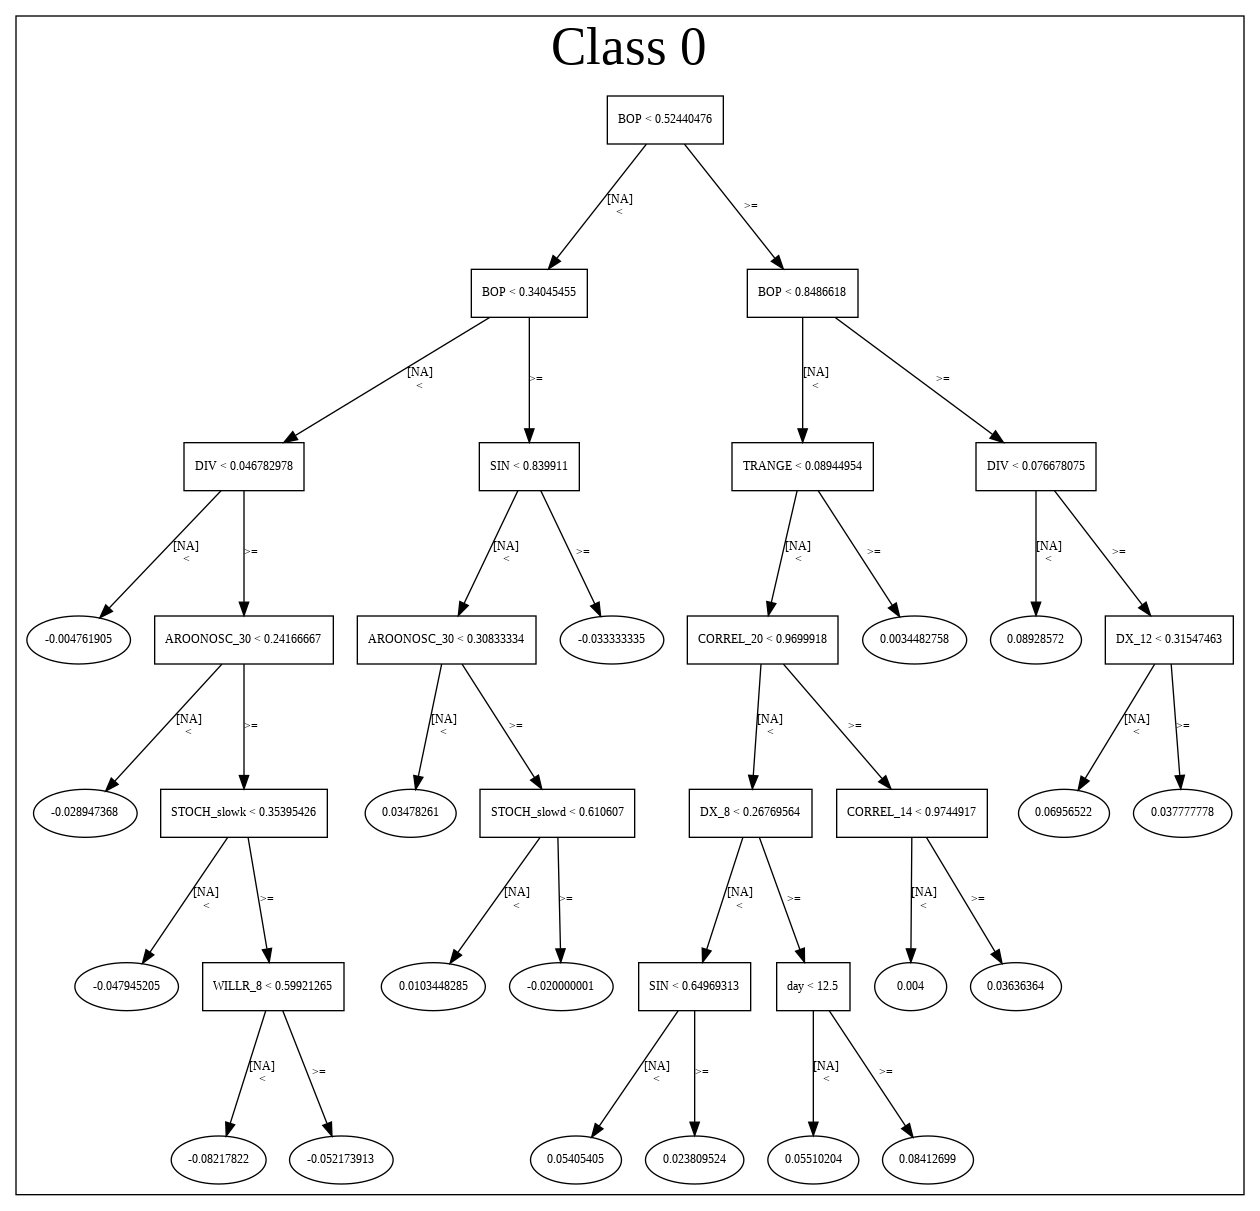

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190905_213727_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190905_213727_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_8e55',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

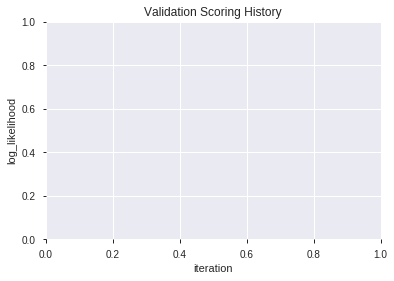

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_1_AutoML_20190905_213807  0.746021  0.609043              0.336804  0.459549  0.211186
1               XGBoost_2_AutoML_20190905_213807  0.741247  0.614333              0.314920  0.462218  0.213645
2  XGBoost_grid_1_AutoML_20190905_213807_model_2  0.737003  0.631071              0.342175  0.469489  0.220420
3  XGBoost_grid_1_AutoML_20190905_213807_model_7  0.734881  0.614875              0.301989  0.462168  0.213599
4  XGBoost_grid_1_AutoML_20190905_213807_model_4  0.732427  0.621596              0.358820  0.465015  0.216239
5               XGBoost_3_AutoML_20190905_213807  0.731963  0.630364              0.335411  0.469381  0.220318
6  XGBoost_grid_1_AutoML_20190905_213807_model_3  0.730968  0.618960              0.358355  0.464086  0.215376
7  XGBoost_grid_1_AutoML_20190905_213807_model_1  0.729576  0.627561              0.353714  0.467804  0.218840
8  XGBoost_grid_1_AutoML_20190905_213807_model_6  0.725265  0.659698              0.336936  0.483427  0.233702
9  XGBoost_grid_1_AutoML_20190905_213807_model_5  0.716247  0.667524              0.367905  0.488012  0.238156

variable  relative_importance  scaled_importance  percentage
0                        BOP          1888.407715           1.000000    0.168173
1                        SUB           269.125641           0.142515    0.023967
2             STOCHRSI_fastk           265.897827           0.140805    0.023680
3               STOCHF_fastk           264.018799           0.139810    0.023512
4                        DIV           153.198761           0.081126    0.013643
..                       ...                  ...                ...         ...
377   BBANDS_lowerband_8_1_5             0.547293           0.000290    0.000049
378   BBANDS_upperband_8_4_2             0.496748           0.000263    0.000044
379          MACDFIX_hist_14             0.386353           0.000205    0.000034
380                     COSH             0.262437           0.000139    0.000023
381  BBANDS_lowerband_30_1_2             0.238490           0.000126    0.000021

[382 rows x 4 columns]

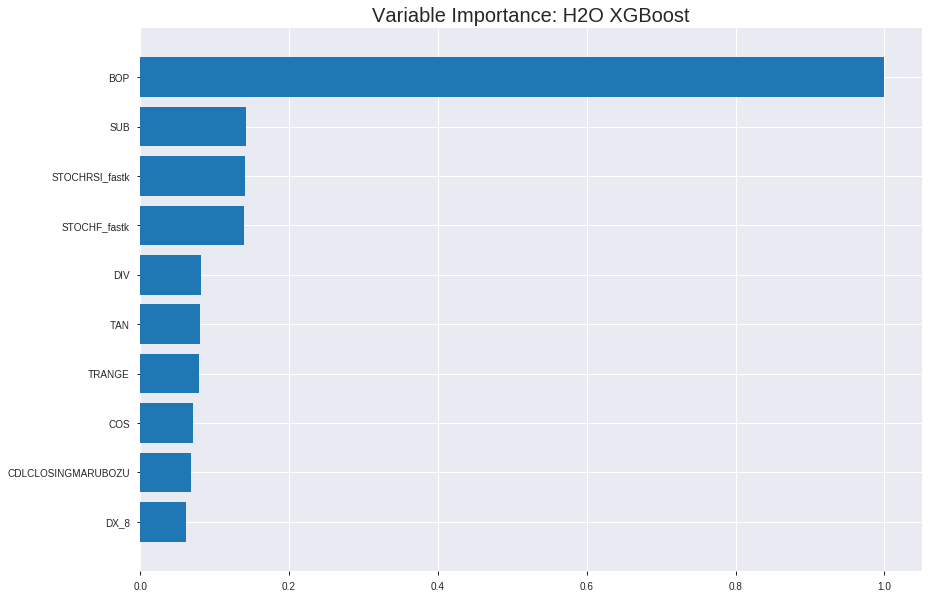

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_1_AutoML_20190905_213807


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.09667615732845293
RMSE: 0.310927897314559
LogLoss: 0.34798760303262316
Mean Per-Class Error: 0.08107631498935852
AUC: 0.9793979933110368
pr_auc: 0.9813580950048556
Gini: 0.9587959866220737
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5400804579257965: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      774  51   0.0618   (51.0/825.0)
1      90   807  0.1003   (90.0/897.0)
Total  864  858  0.0819   (141.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.54008      0.919658  187
max f2                       0.419138     0.946765  238
max f0point5                 0.598494     0.943277  163
max accuracy                 0.54008      0.918118  187
max precision                0.927069     1         0
max recall                   0.281147     1         299
max specificity              0.927069     1         0
max absolute_mcc             0.54008      0.83712   187
max min_per_class_accuracy   0.52058      0.910814  197
max mean_per_class_accuracy  0.54008      0.918924  187

Gains/Lift Table: Avg response rate: 52.09 %, avg score: 51.97 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.91007            1.91973    1.91973            1                0.91562   1                           0.91562             0.0200669       0.0200669                  91.9732   91.9732
    2        0.0203252                   0.895976           1.91973    1.91973            1                0.901618  1                           0.908819            0.0189521       0.039019                   91.9732   91.9732
    3        0.0301974                   0.888777           1.91973    1.91973            1                0.893347  1                           0.903761            0.0189521       0.057971                   91.9732   91.9732
    4        0.0400697                   0.882325           1.91973    1.91973            1                0.885438  1                           0.899247            0.0189521       0.0769231                  91.9732   91.9732
    5        0.0505226                   0.876811           1.91973    1.91973            1                0.879337  1                           0.895128            0.0200669       0.09699                    91.9732   91.9732
    6        0.100465                    0.851703           1.91973    1.91973            1                0.863388  1                           0.879349            0.0958751       0.192865                   91.9732   91.9732
    7        0.150407                    0.828703           1.91973    1.91973            1                0.839133  1                           0.865996            0.0958751       0.28874                    91.9732   91.9732
    8        0.200348                    0.795774           1.91973    1.91973            1                0.813154  1                           0.852824            0.0958751       0.384615                   91.9732   91.9732
    9        0.300232                    0.737227           1.91973    1.91973            1                0.768051  1                           0.824621            0.19175         0.576366                   91.9732   91.9732
    10       0.400116                    0.643904           1.86393    1.9058             0.97093          0.692915  0.992743                    0.791742            0.186176        0.762542                   86.3926   90.5801
    11       0.5                         0.537058           1.37283    1.79933            0.715116         0.590434  0.937282                    0.751527            0.137124        0.899666                   37.2832   79.9331
    12       0.599884                    0.418042           0.758964   1.6261             0.395349         0.475577  0.847047                    0.70558             0.0758082       0.975474                   -24.1036  62.6104
    13       0.699768                    0.32042            0.200902   1.42267            0.104651         0.372669  0.741079                    0.658061            0.0200669       0.995541                   -79.9098  42.2673
    14       0.799652                    0.241991           0.0446449  1.25054            0.0232558        0.277664  0.651416                    0.610546            0.00445931      1                          -95.5355  25.0545
    15       0.899535                    0.159434           0          1.11168            0                0.195717  0.579083                    0.564484            0               1                          -100      11.1685
    16       1                           0.0501018          0          1                  0                0.118973  0.520906                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2073116006952911
RMSE: 0.45531483689343033
LogLoss: 0.6010189697759661
Mean Per-Class Error: 0.31723640344329995
AUC: 0.7314275762551624
pr_auc: 0.7085713176237954
Gini: 0.46285515251032483
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3182887136936188: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      92   139  0.6017   (139.0/231.0)
1      20   241  0.0766   (20.0/261.0)
Total  112  380  0.3232   (159.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.318289     0.75195   305
max f2                       0.244451     0.868673  335
max f0point5                 0.509266     0.700227  212
max accuracy                 0.455594     0.689024  243
max precision                0.923239     1         0
max recall                   0.133798     1         387
max specificity              0.923239     1         0
max absolute_mcc             0.349736     0.390225  288
max min_per_class_accuracy   0.526202     0.67433   200
max mean_per_class_accuracy  0.455594     0.682764  243

Gains/Lift Table: Avg response rate: 53.05 %, avg score: 50.42 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.855986           1.88506   1.88506            1                0.884569  1                           0.884569            0.0191571       0.0191571                  88.5057   88.5057
    2        0.0203252                   0.835173           1.50805   1.69655            0.8              0.847654  0.9                         0.866111            0.0153257       0.0344828                  50.8046   69.6552
    3        0.0304878                   0.827972           1.13103   1.50805            0.6              0.83152   0.8                         0.854581            0.0114943       0.045977                   13.1034   50.8046
    4        0.0406504                   0.818358           1.50805   1.50805            0.8              0.823033  0.8                         0.846694            0.0153257       0.0613027                  50.8046   50.8046
    5        0.050813                    0.80571            1.50805   1.50805            0.8              0.81179   0.8                         0.839713            0.0153257       0.0766284                  50.8046   50.8046
    6        0.101626                    0.756617           1.28184   1.39494            0.68             0.782638  0.74                        0.811175            0.0651341       0.141762                   28.1839   39.4943
    7        0.150407                    0.722985           1.33525   1.37558            0.708333         0.739653  0.72973                     0.787979            0.0651341       0.206897                   33.5249   37.5582
    8        0.20122                     0.694512           1.43264   1.38999            0.76             0.70626   0.737374                    0.767343            0.0727969       0.279693                   43.2644   38.9992
    9        0.300813                    0.650494           1.308     1.36285            0.693878         0.671597  0.722973                    0.735643            0.130268        0.409962                   30.7999   36.2846
    10       0.400407                    0.590816           1.26953   1.33963            0.673469         0.621857  0.71066                     0.707341            0.126437        0.536398                   26.9529   33.9635
    11       0.5                         0.533862           1.23106   1.31801            0.653061         0.562903  0.699187                    0.678571            0.122605        0.659004                   23.1058   31.8008
    12       0.599593                    0.465035           1.11565   1.2844             0.591837         0.500207  0.681356                    0.648944            0.111111        0.770115                   11.5646   28.4395
    13       0.699187                    0.376172           0.923293  1.23296            0.489796         0.419235  0.65407                     0.616224            0.091954        0.862069                   -7.67065  23.2959
    14       0.79878                     0.294825           0.730941  1.17037            0.387755         0.336895  0.620865                    0.581397            0.0727969       0.934866                   -26.9059  17.0366
    15       0.898374                    0.191116           0.461647  1.0918             0.244898         0.242993  0.579186                    0.543881            0.045977        0.980843                   -53.8353  9.1798
    16       1                           0.103278           0.188506  1                  0.1              0.153885  0.530488                    0.504248          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-05 21:38:08  0.006 sec   0                  0.5              0.693147            0.5             0                  1                0.479094                         0.5                0.693147              0.5               0                    1                  0.469512
    2019-09-05 21:38:09  0.807 sec   5                  0.469197         0.633082            0.880561        0.890772           1.91973          0.217189                         0.488876           0.671027              0.67214           0.665429             1.13103            0.376016
    2019-09-05 21:38:09  1.055 sec   10                 0.445491         0.58834             0.901526        0.91403            1.91973          0.206156                         0.478936           0.651332              0.702949          0.674474             0.754023           0.345528
    2019-09-05 21:38:09  1.280 sec   15                 0.424295         0.548951            0.91475         0.92602            1.91973          0.186411                         0.471958           0.637334              0.709575          0.680343             1.50805            0.333333
    2019-09-05 21:38:09  1.495 sec   20                 0.406825         0.516573            0.921997        0.93233            1.91973          0.172474                         0.466237           0.625587              0.71786           0.691467             1.88506            0.313008
    2019-09-05 21:38:09  1.714 sec   25                 0.39137          0.487764            0.929221        0.938599           1.91973          0.160279                         0.46486            0.621945              0.715198          0.693627             1.88506            0.337398
    2019-09-05 21:38:10  1.932 sec   30                 0.378308         0.463593            0.936314        0.944938           1.91973          0.148664                         0.462382           0.616412              0.718341          0.699908             1.88506            0.335366
    2019-09-05 21:38:10  2.163 sec   35                 0.366349         0.441875            0.944289        0.950618           1.91973          0.145761                         0.460942           0.612851              0.72136           0.708533             1.88506            0.331301
    2019-09-05 21:38:10  2.370 sec   40                 0.356399         0.423739            0.949935        0.956773           1.91973          0.131823                         0.458416           0.607529              0.725622          0.706691             1.88506            0.319106
    2019-09-05 21:38:10  2.602 sec   45                 0.345871         0.405717            0.958313        0.962879           1.91973          0.114402                         0.458695           0.607884              0.724354          0.703586             1.88506            0.310976
    2019-09-05 21:38:11  2.812 sec   50                 0.336252         0.388971            0.963796        0.966359           1.91973          0.106852                         0.457956           0.605847              0.726767          0.707466             1.88506            0.317073
    2019-09-05 21:38:11  3.038 sec   55                 0.327422         0.37426             0.969332        0.973076           1.91973          0.0998839                        0.456422           0.603085              0.729421          0

Variable Importances: 


variable                 relative_importance    scaled_importance       percentage
-----------------------  ---------------------  ----------------------  ----------------------
BOP                      1888.40771484375       1.0                     0.16817297949107726
SUB                      269.1256408691406      0.14251458451143245     0.023967102298220525
STOCHRSI_fastk           265.8978271484375      0.14080530653330778     0.023679647927860818
STOCHF_fastk             264.018798828125       0.139810273360364       0.0235123102344744
DIV                      153.19876098632812     0.08112589234947287     0.013643183030283243
---                      ---                    ---                     ---
BBANDS_lowerband_8_1_5   0.5472927093505859     0.00028981702682562375  4.873939290851061e-05
BBANDS_upperband_8_4_2   0.4967479705810547     0.0002630512291791587   4.4238108969849324e-05
MACDFIX_hist_14          0.3863525390625        0.0002045916970289795   3.440679526849926e-05
COSH                     0.2624368667602539     0.00013897256651589584  2.337143057850012e-05
BBANDS_lowerband_30_1_2  0.23849010467529297    0.00012629163861207062  2.1238841150202292e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6991869918699187)

('F1', 0.7554179566563467)

('auc', 0.7460212201591512)

('logloss', 0.6090431136247912)

('mean_per_class_error', 0.31061007957559683)

('rmse', 0.45954936191321344)

('mse', 0.21118561603484162)

xgboost prediction progress: |████████████████████████████████████████████| 100%


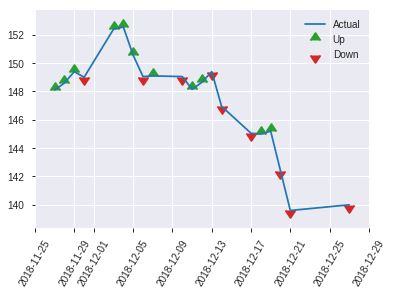


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.21118561603484162
RMSE: 0.45954936191321344
LogLoss: 0.6090431136247912
Mean Per-Class Error: 0.31061007957559683
AUC: 0.7460212201591512
pr_auc: 0.7610096581314475
Gini: 0.49204244031830235
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23375198245048523: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      45   71   0.6121   (71.0/116.0)
1      8    122  0.0615   (8.0/130.0)
Total  53   193  0.3211   (79.0/246.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.233752     0.755418  192
max f2                       0.18351      0.858108  219
max f0point5                 0.551202     0.701581  93
max accuracy                 0.307223     0.699187  167
max precision                0.844712     1         0
max recall                   0.0980716    1         243
max specificity              0.844712     1         0
max absolute_mcc             0.303061     0.408216  169
max min_per_class_accuracy   0.45344      0.655172  125
max mean_per_class_accuracy  0.307223     0.68939   167

Gains/Lift Table: Avg response rate: 52.85 %, avg score: 45.33 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121951                   0.818749           1.89231   1.89231            1                0.833938  1                           0.833938            0.0230769       0.0230769                  89.2308   89.2308
    2        0.0203252                   0.798721           1.89231   1.89231            1                0.809096  1                           0.824001            0.0153846       0.0384615                  89.2308   89.2308
    3        0.0325203                   0.788291           1.89231   1.89231            1                0.794842  1                           0.813066            0.0230769       0.0615385                  89.2308   89.2308
    4        0.0406504                   0.778577           1.89231   1.89231            1                0.783249  1                           0.807103            0.0153846       0.0769231                  89.2308   89.2308
    5        0.0528455                   0.766327           1.89231   1.89231            1                0.773128  1                           0.799262            0.0230769       0.1                        89.2308   89.2308
    6        0.101626                    0.717931           1.73462   1.81662            0.916667         0.739282  0.96                        0.770472            0.0846154       0.184615                   73.4615   81.6615
    7        0.150407                    0.690711           1.10385   1.58545            0.583333         0.709156  0.837838                    0.750586            0.0538462       0.238462                   10.3846   58.5447
    8        0.203252                    0.671653           1.45562   1.55169            0.769231         0.679072  0.82                        0.731992            0.0769231       0.315385                   45.5621   55.1692
    9        0.300813                    0.599149           1.26154   1.45759            0.666667         0.639996  0.77027                     0.702155            0.123077        0.438462                   26.1538   45.7588
    10       0.402439                    0.547253           1.13538   1.37622            0.6              0.57041   0.727273                    0.668886            0.115385        0.553846                   13.5385   37.6224
    11       0.5                         0.459626           0.867308  1.27692            0.458333         0.50857   0.674797                    0.637605            0.0846154       0.638462                   -13.2692  27.6923
    12       0.601626                    0.372528           1.21108   1.2658             0.64             0.421826  0.668919                    0.601156            0.123077        0.761538                   21.1077   26.58
    13       0.699187                    0.294576           1.10385   1.2432             0.583333         0.328139  0.656977                    0.56306             0.107692        0.869231                   10.3846   24.3202
    14       0.800813                    0.225921           0.756923  1.18149            0.4              0.25651   0.624365                    0.524158            0.0769231       0.946154                   -24.3077  18.1492
    15       0.898374                    0.179455           0.315385  1.08743            0.166667         0.205097  0.574661                    0.489509            0.0307692       0.976923                   -68.4615  8.74347
    16       1                           0.0810785          0.227077  1                  0.12             0.133305  0.528455                    0.453309           

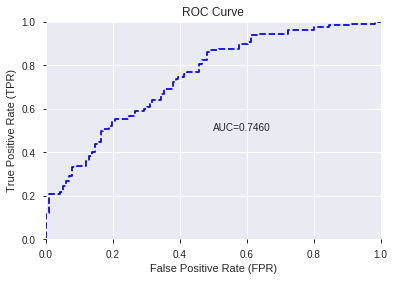

This function is available for GLM models only


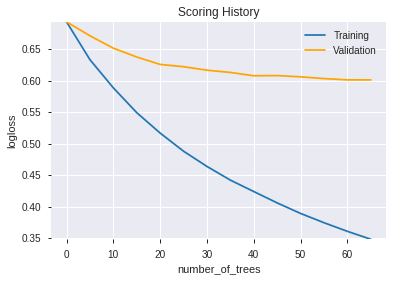

--2019-09-05 21:38:59--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.186.35
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.186.35|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

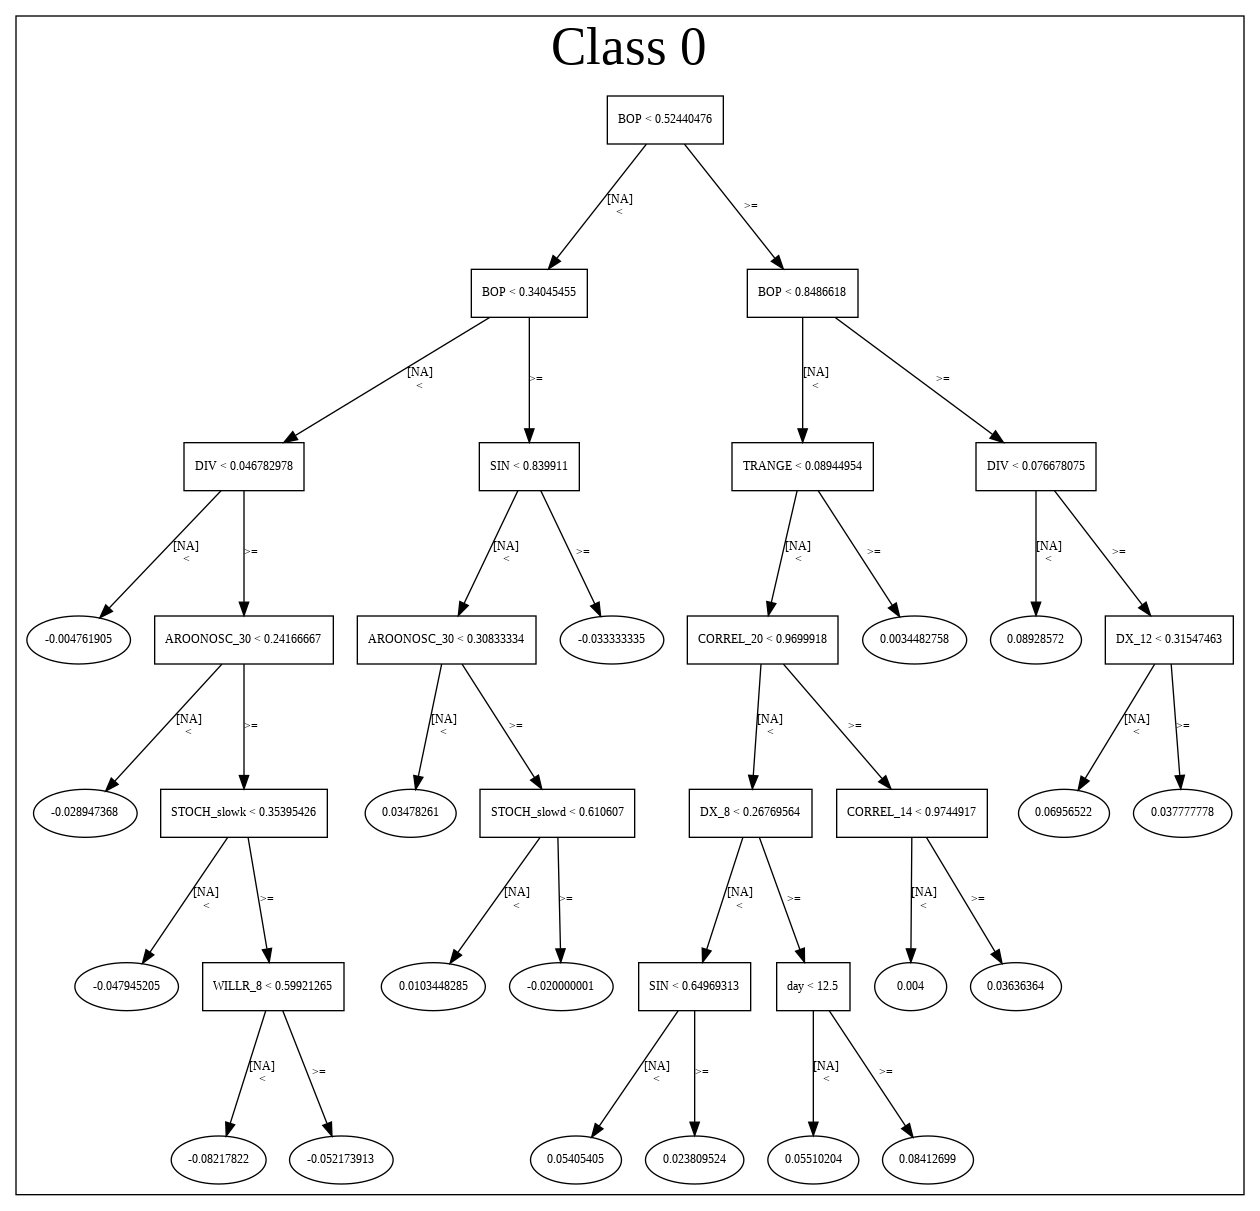

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_1_AutoML_20190905_213807',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_1_AutoML_20190905_213807',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_8e55',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_42_sid_8e55',
   'type

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190905_213908_model_6  0.743236  0.601024              0.329111  0.451073  0.203467
1  DeepLearning_grid_1_AutoML_20190905_213908_model_9  0.736671  0.602788              0.332958  0.454367  0.206449
2  DeepLearning_grid_1_AutoML_20190905_213908_model_8  0.726558  0.607217              0.318767  0.458297  0.210036
3  DeepLearning_grid_1_AutoML_20190905_213908_model_7  0.723342  0.711333              0.332958  0.489040  0.239161
4               DeepLearning_1_AutoML_20190905_213908  0.722149  0.709713              0.333090  0.486628  0.236807
5  DeepLearning_grid_1_AutoML_20190905_213908_model_5  0.714655  0.609913              0.327255  0.459988  0.211589
6  DeepLearning_grid_1_AutoML_20190905_213908_model_3  0.686273  0.758948              0.393767  0.494260  0.244293
7  DeepLearning_grid_1_AutoML_20190905_213908_model_1  0.662732  1.130863              0.397613  0.553781  0.306673
8  DeepLearning_grid_1_AutoML_20190905_213908_model_4  0.659483  0.895592              0.397613  0.522671  0.273185
9  DeepLearning_grid_1_AutoML_20190905_213908_model_2  0.658289  0.946274              0.404841  0.533018  0.284108

variable  relative_importance  scaled_importance  percentage
0                  BOP             1.000000           1.000000    0.044366
1   CDLCLOSINGMARUBOZU             0.809957           0.809957    0.035935
2         CDLSHORTLINE             0.576128           0.576128    0.025561
3                  SUB             0.556813           0.556813    0.024704
4          CDLLONGLINE             0.550778           0.550778    0.024436
5         HT_TRENDMODE             0.535569           0.535569    0.023761
6                  DIV             0.514006           0.514006    0.022805
7       STOCHRSI_fastk             0.499054           0.499054    0.022141
8               TRANGE             0.492298           0.492298    0.021841
9            CORREL_14             0.472879           0.472879    0.020980
10                 SIN             0.465610           0.465610    0.020657
11           CORREL_20             0.462894           0.462894    0.020537
12              ULTOSC             0.459547           0.459547    0.020388
13           CDLTAKURI             0.458065           0.458065    0.020323
14        STOCHF_fastk             0.453708           0.453708    0.020129
15        CDLENGULFING             0.447092           0.447092    0.019836
16         STOCH_slowd             0.445283           0.445283    0.019756
17               DX_12             0.431271           0.431271    0.019134
18           CDLHAMMER             0.427505           0.427505    0.018967
19              MFI_12             0.426763           0.426763    0.018934
20        weekday_name             0.423921           0.423921    0.018808
21         AROONOSC_30             0.422207           0.422207    0.018732
22               DX_14             0.421687           0.421687    0.018709
23      CDLSPINNINGTOP             0.421671           0.421671    0.018708
24         CDLMARUBOZU             0.420776           0.420776    0.018668
25           dayofweek             0.419856           0.419856    0.018627
26                 day             0.418924           0.418924    0.018586
27        STOCHF_fastd             0.418656           0.418656    0.018574
28    CDLDRAGONFLYDOJI             0.416767           0.416767    0.018490
29         CDL3OUTSIDE             0.411638           0.411638    0.018263
30             BETA_24             0.409449           0.409449    0.018166
31             BETA_20             0.406046           0.406046    0.018015
32             BETA_12             0.405374           0.405374    0.017985
33         STOCH_slowk             0.404446           0.404446    0.017944
34               month             0.402746           0.402746    0.017868
35                DX_8             0.402355           0.402355    0.017851
36             WILLR_8             0.398875           0.398875    0.017697
37          aroonup_30             0.398278           0.398278    0.017670
38            WILLR_14             0.396924           0.396924    0.017610
39             CDLDOJI             0.396352           0.396352    0.017585
40            WILLR_20             0.393583           0.393583    0.017462
41            WILLR_12             0.392527           0.392527    0.017415
42           dayofyear             0.390635           0.390635    0.017331
43         HT_DCPERIOD             0.390328           0.390328    0.017317
44             BETA_14             0.389909           0.389909    0.017299
45         CDLBELTHOLD             0.386483           0.386483    0.017147
46      STOCHRSI_fastd             0.385794           0.385794    0.017116
47            WILLR_24             0.381684           0.381684    0.016934
48   CDLLONGLEGGEDDOJI             0.375027           0.375027    0.016639
49          CDLHIKKAKE             0.351526           0.351526    0.015596

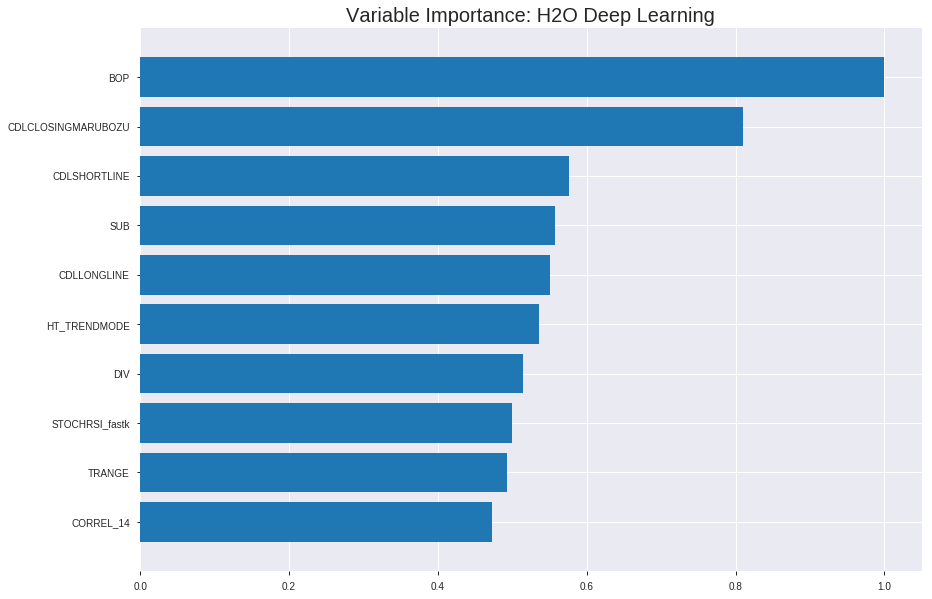

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190905_213908_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1858704455240042
RMSE: 0.43112694826930525
LogLoss: 0.5487731502222398
Mean Per-Class Error: 0.2773973852234721
AUC: 0.7922522887740279
pr_auc: 0.7950032361032069
Gini: 0.5845045775480557
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44206646815170014: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      448  377   0.457    (377.0/825.0)
1      117  780   0.1304   (117.0/897.0)
Total  565  1157  0.2869   (494.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.442066     0.759494  239
max f2                       0.204077     0.862745  330
max f0point5                 0.573346     0.738732  174
max accuracy                 0.521712     0.724739  202
max precision                0.997928     1         0
max recall                   0.0140511    1         398
max specificity              0.997928     1         0
max absolute_mcc             0.521712     0.448097  202
max min_per_class_accuracy   0.549577     0.714604  187
max mean_per_class_accuracy  0.521712     0.722603  202

Gains/Lift Table: Avg response rate: 52.09 %, avg score: 52.30 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.961988           1.91973   1.91973            1                0.975871  1                           0.975871            0.0200669       0.0200669                  91.9732   91.9732
    2        0.0203252                   0.948455           1.91973   1.91973            1                0.953507  1                           0.965009            0.0189521       0.039019                   91.9732   91.9732
    3        0.0301974                   0.933607           1.91973   1.91973            1                0.941862  1                           0.957442            0.0189521       0.057971                   91.9732   91.9732
    4        0.0400697                   0.906498           1.58096   1.83627            0.823529         0.921341  0.956522                    0.948547            0.0156076       0.0735786                  58.0956   83.6266
    5        0.0505226                   0.891713           1.70643   1.8094             0.888889         0.90001   0.942529                    0.938505            0.0178372       0.0914158                  70.6429   80.9403
    6        0.100465                    0.835384           1.69651   1.75328            0.883721         0.864004  0.913295                    0.90147             0.0847269       0.176143                   69.6508   75.3282
    7        0.150407                    0.771665           1.54025   1.68255            0.802326         0.800146  0.876448                    0.867826            0.0769231       0.253066                   54.025    68.2545
    8        0.200348                    0.717322           1.45096   1.62482            0.755814         0.742035  0.846377                    0.836469            0.0724638       0.32553                    45.0961   62.4817
    9        0.300232                    0.65202            1.36167   1.53727            0.709302         0.680107  0.800774                    0.784449            0.136009        0.461538                   36.1671   53.7271
    10       0.400116                    0.604222           1.35051   1.49065            0.703488         0.627366  0.776488                    0.745236            0.134894        0.596433                   35.0509   49.0649
    11       0.5                         0.556736           1.0938    1.41137            0.569767         0.581003  0.735192                    0.712427            0.109253        0.705686                   9.3801    41.1371
    12       0.599884                    0.49467            1.01567   1.34549            0.52907          0.525451  0.700871                    0.681295            0.101449        0.807135                   1.56724   34.5485
    13       0.699768                    0.414789           0.781286  1.26495            0.406977         0.456884  0.658921                    0.649262            0.0780379       0.885173                   -21.8714  26.4952
    14       0.799652                    0.286423           0.602707  1.18223            0.313953         0.350792  0.615832                    0.611981            0.0602007       0.945373                   -39.7293  18.2232
    15       0.899535                    0.17742            0.412966  1.09681            0.215116         0.231126  0.571336                    0.569691            0.0412486       0.986622                   -58.7034  9.68129
    16       1                           0.00364283         0.133161  1                  0.0693642        0.10481   0.520906                    0.522987         



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.19997931174307154
RMSE: 0.44719046472735924
LogLoss: 0.587684130569686
Mean Per-Class Error: 0.2949196397472259
AUC: 0.7507836990595612
pr_auc: 0.7376399945563524
Gini: 0.5015673981191224
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.373773390410578: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      103  128  0.5541   (128.0/231.0)
1      23   238  0.0881   (23.0/261.0)
Total  126  366  0.3069   (151.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.373773     0.759171  290
max f2                       0.225525     0.868529  340
max f0point5                 0.498101     0.716225  238
max accuracy                 0.498101     0.711382  238
max precision                0.915413     0.952381  18
max recall                   0.064467     1         392
max specificity              0.987858     0.995671  0
max absolute_mcc             0.491797     0.421571  242
max min_per_class_accuracy   0.558705     0.666667  199
max mean_per_class_accuracy  0.498101     0.70508   238

Gains/Lift Table: Avg response rate: 53.05 %, avg score: 52.83 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.968604           1.50805   1.50805            0.8              0.981233  0.8                         0.981233            0.0153257       0.0153257                  50.8046   50.8046
    2        0.0203252                   0.947461           1.88506   1.69655            1                0.956243  0.9                         0.968738            0.0191571       0.0344828                  88.5057   69.6552
    3        0.0304878                   0.928853           1.88506   1.75939            1                0.937557  0.933333                    0.958344            0.0191571       0.0536398                  88.5057   75.9387
    4        0.0406504                   0.915837           1.88506   1.7908             1                0.92179   0.95                        0.949206            0.0191571       0.0727969                  88.5057   79.0805
    5        0.050813                    0.90059            1.50805   1.73425            0.8              0.908575  0.92                        0.941079            0.0153257       0.0881226                  50.8046   73.4253
    6        0.101626                    0.842276           1.28184   1.50805            0.68             0.869885  0.8                         0.905482            0.0651341       0.153257                   28.1839   50.8046
    7        0.150407                    0.749621           1.49234   1.50295            0.791667         0.792335  0.797297                    0.868786            0.0727969       0.226054                   49.2337   50.2951
    8        0.20122                     0.711982           1.58345   1.52328            0.84             0.730874  0.808081                    0.83396             0.0804598       0.306513                   58.3448   52.3279
    9        0.300813                    0.644675           1.15412   1.40106            0.612245         0.673871  0.743243                    0.780957            0.114943        0.421456                   15.4117   40.1056
    10       0.400407                    0.596841           1.26953   1.36834            0.673469         0.61786   0.725888                    0.74039             0.126437        0.547893                   26.9529   36.8341
    11       0.5                         0.560538           1.11565   1.31801            0.591837         0.577864  0.699187                    0.708017            0.111111        0.659004                   11.5646   31.8008
    12       0.599593                    0.510636           1.26953   1.30996            0.673469         0.536474  0.694915                    0.679523            0.126437        0.785441                   26.9529   30.9955
    13       0.699187                    0.433116           0.846352  1.24392            0.44898          0.475669  0.659884                    0.650486            0.0842912       0.869732                   -15.3648  24.3919
    14       0.79878                     0.305836           0.730941  1.17996            0.387755         0.373957  0.625954                    0.616008            0.0727969       0.942529                   -26.9059  17.996
    15       0.898374                    0.181958           0.384706  1.0918             0.204082         0.241701  0.579186                    0.574512            0.0383142       0.980843                   -61.5294  9.1798
    16       1                           0.024133           0.188506  1                  0.1              0.120171  0.530488                    0.528339           


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-05 21:42:54  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-05 21:42:57  2 min  9.170 sec  909 obs/sec       1.30604   1             2249       0.500529         0.796204            -0.0038706     0.710267        0.694745           1.81308          0.355981                         0.512416           0.848314              -0.0542018       0.681943          0.681884             1.50805            0.361789
    2019-09-05 21:43:05  2 min 16.920 sec  1690 obs/sec      9.30372   7             16021      0.445845         0.57955             0.203496       0.771048        0.770354           1.91973          0.310685                         0.452402           0.600251              0.178274         0.748719          0.731354             1.50805            0.280488
    2019-09-05 21:43:12  2 min 24.578 sec  2095 obs/sec      19.9082   15            34282      0.431127         0.548773            0.255216       0.792252        0.795003           1.91973          0.286876                         0.44719            0.587684              0.197098         0.750784          0.73764              1.50805            0.306911
    2019-09-05 21:43:20  2 min 32.562 sec  2328 obs/sec      31.9321   24            54987      0.422901         0.531586            0.283367       0.810662        0.810411           1.91973          0.280488                         0.448666           0.593238              0.191789         0.754068          0.745746             1.50805            0.321138
    2019-09-05 21:43:28  2 min 40.292 sec  2468 obs/sec      43.8513   33            75512      0.410388         0.506395            0.325148       0.836969        0.83683            1.91973          0.243322                         0.456117           0.612632              0.164723         0.737241          0.726545             1.50805            0.333333
    2019-09-05 21:43:36  2 min 47.942 sec  2562 obs/sec      55.8078   42            96101      0.401299         0.488419            0.354708       0.851489        0.855777           1.91973          0.232288                         0.458713           0.62634               0.15519          0.734604          0.723755             1.50805            0.345528
    2019-09-05 21:43:43  2 min 55.471 sec  2635 obs/sec      67.7904   51            116735     0.391215         0.464927            0.38673        0.865282        0.870655           1.91973          0.220093                         0.464488           0.650705              0.133784         0.734803          0.730577             1.50805            0.349593
    2019-09-05 21:43:44  2 min 56.244 sec  2634 obs/sec      67.7904   51            116735     0.431127         0.548773            0.255216       0.792252        0.795003           1.91973          0.286876                         0.44719            0.587684              0.197098         0.750784          0.73764              1.50805            0.306911

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.0443662346139396
CDLCLOSINGMARUBOZU  0.8099572062492371     0.8099572062492371   0.03593475143970472
CDLSHORTLINE        0.5761277079582214     0.5761277079582214   0.02556061705886573
SUB                 0.5568129420280457     0.5568129420280457   0.024703693622094222
CDLLONGLINE         0.550778329372406      0.550778329372406    0.024435960581209865
---                 ---                    ---                  ---
CDLBELTHOLD         0.38648277521133423    0.38648277521133423  0.017146785479272536
STOCHRSI_fastd      0.38579410314559937    0.38579410314559937  0.017116231692832076
WILLR_24            0.3816838264465332     0.3816838264465332   0.016933874192473098
CDLLONGLEGGEDDOJI   0.3750268518924713     0.3750268518924713   0.01663852929758856
CDLHIKKAKE          0.3515262007713318     0.3515262007713318   0.015595893896367742


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7073170731707317)

('F1', 0.7630769230769231)

('auc', 0.743236074270557)

('logloss', 0.6010241763321996)

('mean_per_class_error', 0.29966843501326257)

('rmse', 0.45107266834673093)

('mse', 0.2034665521294399)

deeplearning prediction progress: |███████████████████████████████████████| 100%


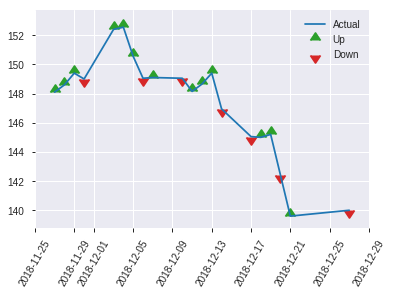


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2034665521294399
RMSE: 0.45107266834673093
LogLoss: 0.6010241763321996
Mean Per-Class Error: 0.29966843501326257
AUC: 0.743236074270557
pr_auc: 0.7348443940528214
Gini: 0.4864721485411141
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31614708652034385: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      45   71   0.6121   (71.0/116.0)
1      6    124  0.0462   (6.0/130.0)
Total  51   195  0.313    (77.0/246.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.316147     0.763077  194
max f2                       0.283867     0.868056  199
max f0point5                 0.447032     0.709549  155
max accuracy                 0.447032     0.707317  155
max precision                0.781012     0.923077  25
max recall                   0.0442673    1         245
max specificity              0.988103     0.991379  0
max absolute_mcc             0.316147     0.420864  194
max min_per_class_accuracy   0.528237     0.646552  125
max mean_per_class_accuracy  0.447032     0.700332  155

Gains/Lift Table: Avg response rate: 52.85 %, avg score: 50.12 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121951                   0.943942           1.26154   1.26154            0.666667         0.972744  0.666667                    0.972744            0.0153846       0.0153846                  26.1538   26.1538
    2        0.0203252                   0.925603           1.89231   1.51385            1                0.932945  0.8                         0.956825            0.0153846       0.0307692                  89.2308   51.3846
    3        0.0325203                   0.902895           1.89231   1.65577            1                0.914318  0.875                       0.940885            0.0230769       0.0538462                  89.2308   65.5769
    4        0.0406504                   0.885905           1.89231   1.70308            1                0.89094   0.9                         0.930896            0.0153846       0.0692308                  89.2308   70.3077
    5        0.0528455                   0.846868           1.26154   1.60118            0.666667         0.86797   0.846154                    0.916375            0.0153846       0.0846154                  26.1538   60.1183
    6        0.101626                    0.7825             1.89231   1.74092            1                0.814532  0.92                        0.86749             0.0923077       0.176923                   89.2308   74.0923
    7        0.150407                    0.70577            1.10385   1.5343             0.583333         0.742802  0.810811                    0.827051            0.0538462       0.230769                   10.3846   53.4304
    8        0.203252                    0.658282           1.31006   1.476              0.692308         0.677368  0.78                        0.788133            0.0692308       0.3                        31.0059   47.6
    9        0.300813                    0.609793           1.41923   1.45759            0.75             0.63165   0.77027                     0.737382            0.138462        0.438462                   41.9231   45.7588
    10       0.402439                    0.57192            1.05969   1.35711            0.56             0.594023  0.717172                    0.70118             0.107692        0.546154                   5.96923   35.711
    11       0.5                         0.532069           0.946154  1.27692            0.5              0.552911  0.674797                    0.67225             0.0923077       0.638462                   -5.38462  27.6923
    12       0.601626                    0.48506            1.28677   1.27859            0.68             0.513472  0.675676                    0.645429            0.130769        0.769231                   28.6769   27.8586
    13       0.699187                    0.401175           0.946154  1.2322             0.5              0.437087  0.651163                    0.616358            0.0923077       0.861538                   -5.38462  23.22
    14       0.800813                    0.300796           0.908308  1.1911             0.48             0.353046  0.629442                    0.582943            0.0923077       0.953846                   -9.16923  19.1097
    15       0.898374                    0.175044           0.157692  1.07887            0.0833333        0.239702  0.570136                    0.545668            0.0153846       0.969231                   -84.2308  7.88723
    16       1                           0.0442673          0.302769  1                  0.16             0.108005  0.528455                    0.50119             0.0

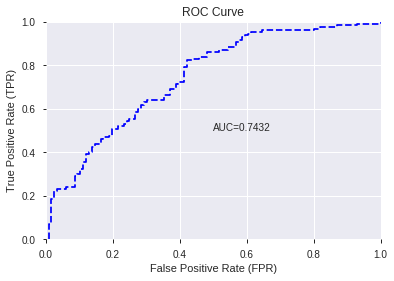

This function is available for GLM models only


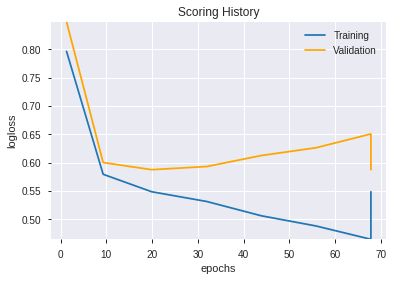

--2019-09-05 21:48:13--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.239.99
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.239.99|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


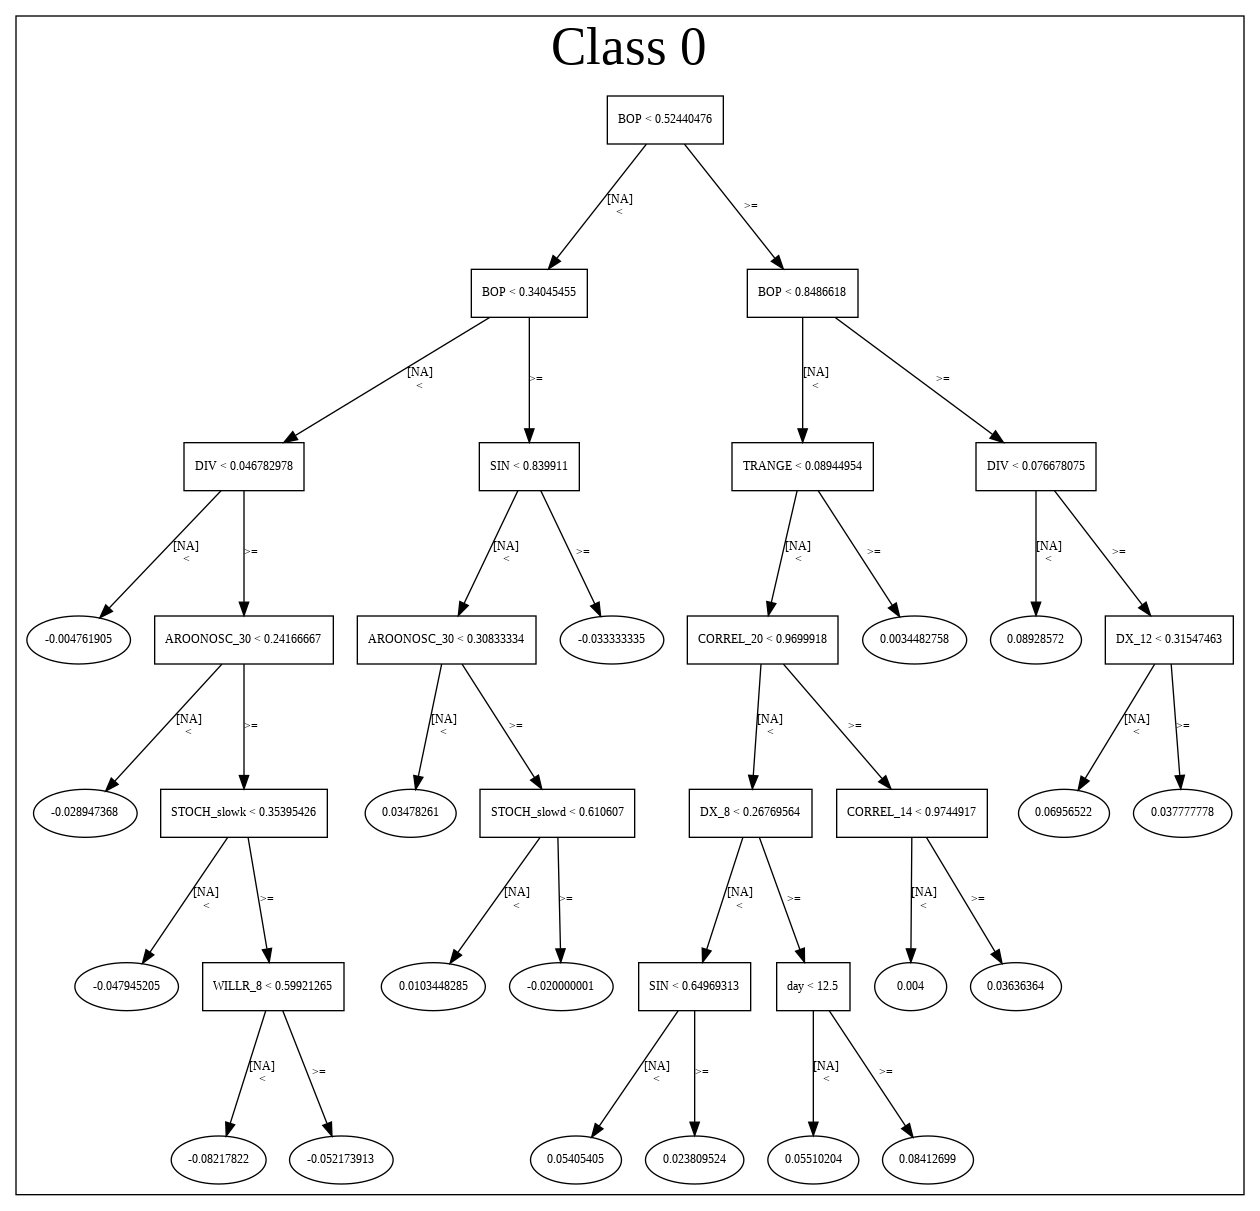

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190905_213908_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190905_213908_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_8e55',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'CDLSHORTLINE',
 'SUB',
 'CDLLONGLINE',
 'HT_TRENDMODE',
 'DIV',
 'STOCHRSI_fastk',
 'TRANGE',
 'CORREL_14',
 'SIN',
 'CORREL_20',
 'ULTOSC',
 'CDLTAKURI',
 'STOCHF_fastk',
 'CDLENGULFING',
 'STOCH_slowd',
 'DX_12',
 'CDLHAMMER',
 'MFI_12',
 'weekday_name',
 'AROONOSC_30',
 'DX_14',
 'CDLSPINNINGTOP',
 'CDLMARUBOZU',
 'dayofweek',
 'day',
 'STOCHF_fastd',
 'CDLDRAGONFLYDOJI',
 'CDL3OUTSIDE',
 'BETA_24',
 'BETA_20',
 'BETA_12',
 'STOCH_slowk',
 'month',
 'DX_8',
 'WILLR_8',
 'aroonup_30',
 'WILLR_14',
 'CDLDOJI',
 'WILLR_20',
 'WILLR_12',
 'dayofyear',
 'HT_DCPERIOD',
 'BETA_14',
 'CDLBELTHOLD',
 'STOCHRSI_fastd',
 'WILLR_24',
 'CDLLONGLEGGEDDOJI',
 'CDLHIKKAKE']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190905_214822_model_1  0.739721  0.607544                0.3063  0.455841  0.207791

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.442859           1.000000    0.146547
1   CDLCLOSINGMARUBOZU             0.190357           0.429837    0.062991
2                  SUB             0.184324           0.416213    0.060995
3            CDLHAMMER             0.107795           0.243408    0.035671
4               TRANGE             0.096626           0.218187    0.031975
5       STOCHRSI_fastk             0.094359           0.213067    0.031224
6            CDLTAKURI             0.090399           0.204125    0.029914
7               ULTOSC             0.089339           0.201733    0.029563
8               MFI_12             0.087932           0.198554    0.029098
9           CDLHIKKAKE             0.084930           0.191778    0.028104
10        STOCHF_fastd             0.080586           0.181966    0.026667
11         STOCH_slowk             0.080091           0.180849    0.026503
12         STOCH_slowd             0.076511           0.172767    0.025318
13        STOCHF_fastk             0.074619           0.168495    0.024692
14         CDLLONGLINE             0.071681           0.161860    0.023720
15        CDLENGULFING             0.070856           0.159996    0.023447
16                DX_8             0.070391           0.158946    0.023293
17         CDL3OUTSIDE             0.062268           0.140605    0.020605
18                 SIN             0.061672           0.139258    0.020408
19            WILLR_24             0.057016           0.128744    0.018867
20        weekday_name             0.054528           0.123127    0.018044
21         AROONOSC_30             0.053667           0.121183    0.017759
22             BETA_12             0.052275           0.118040    0.017298
23             BETA_14             0.049394           0.111534    0.016345
24    CDLDRAGONFLYDOJI             0.046403           0.104781    0.015355
25             WILLR_8             0.045233           0.102140    0.014968
26           CORREL_14             0.037173           0.083939    0.012301
27        HT_TRENDMODE             0.035556           0.080287    0.011766
28            WILLR_20             0.034796           0.078571    0.011514
29          aroonup_30             0.034570           0.078060    0.011439
30      CDLSPINNINGTOP             0.034556           0.078028    0.011435
31             BETA_24             0.034059           0.076908    0.011271
32        CDLSHORTLINE             0.032513           0.073416    0.010759
33           CORREL_20             0.032399           0.073159    0.010721
34         CDLMARUBOZU             0.031948           0.072141    0.010572
35         HT_DCPERIOD             0.028980           0.065439    0.009590
36            WILLR_14             0.026583           0.060026    0.008797
37             BETA_20             0.023712           0.053543    0.007847
38            WILLR_12             0.023095           0.052150    0.007642
39               month             0.022995           0.051925    0.007609
40           dayofyear             0.022577           0.050980    0.007471
41         CDLBELTHOLD             0.020197           0.045606    0.006683
42                 day             0.017454           0.039412    0.005776
43               DX_12             0.014334           0.032367    0.004743
44      STOCHRSI_fastd             0.013001           0.029357    0.004302
45           dayofweek             0.012035           0.027175    0.003982
46                 DIV             0.005248           0.011851    0.001737
47               DX_14             0.004074           0.009200    0.001348
48             CDLDOJI             0.002006           0.004530    0.000664
49   CDLLONGLEGGEDDOJI             0.001986           0.004484    0.000657

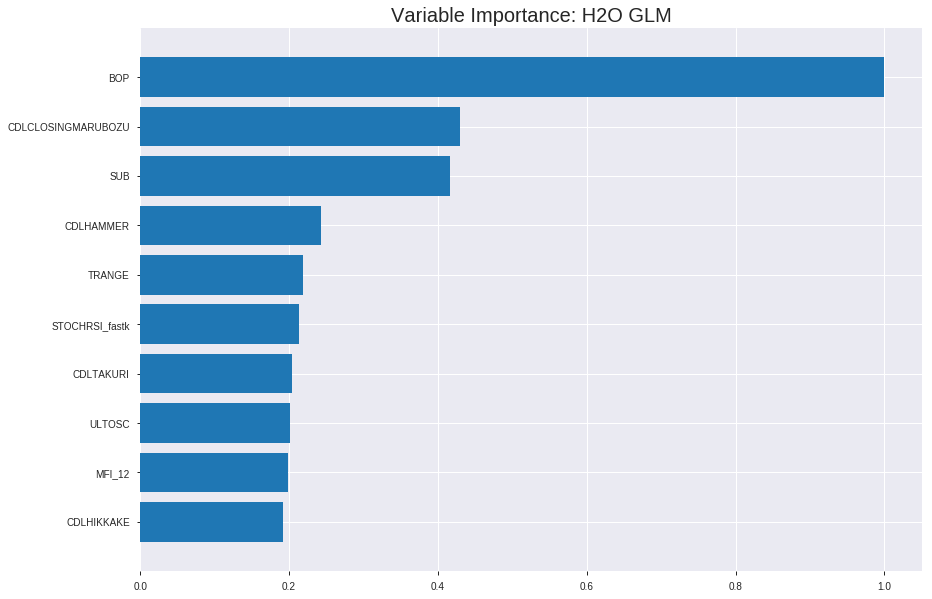

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190905_214822_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.1962685177876877
RMSE: 0.4430220285580478
LogLoss: 0.5766959918481988
Null degrees of freedom: 1721
Residual degrees of freedom: 1671
Null deviance: 2384.1875591118605
Residual deviance: 1986.1409959251966
AIC: 2088.140995925197
AUC: 0.7685084963345833
pr_auc: 0.7648489382847811
Gini: 0.5370169926691666
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4239030734944027: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      430  395   0.4788   (395.0/825.0)
1      134  763   0.1494   (134.0/897.0)
Total  564  1158  0.3072   (529.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.423903     0.742579  252
max f2                       0.220562     0.854344  348
max f0point5                 0.562311     0.726223  180
max accuracy                 0.544083     0.707898  189
max precision                0.955884     1         0
max recall                   0.111938     1         388
max specificity              0.955884     1         0
max absolute_mcc             0.544083     0.417426  189
max min_per_class_accuracy   0.529382     0.70303   197
max mean_per_class_accuracy  0.544083     0.708821  189

Gains/Lift Table: Avg response rate: 52.09 %, avg score: 52.09 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.877693           1.70643   1.70643            0.888889         0.898638  0.888889                    0.898638            0.0178372       0.0178372                  70.6429   70.6429
    2        0.0203252                   0.865818           1.58096   1.64548            0.823529         0.871918  0.857143                    0.88566             0.0156076       0.0334448                  58.0956   64.5485
    3        0.0301974                   0.853493           1.91973   1.73514            1                0.8591    0.903846                    0.876977            0.0189521       0.0523969                  91.9732   73.5143
    4        0.0400697                   0.84422            1.69388   1.72498            0.882353         0.849086  0.898551                    0.870105            0.0167224       0.0691193                  69.3882   72.4977
    5        0.0505226                   0.832632           1.81308   1.74321            0.944444         0.837613  0.908046                    0.863383            0.0189521       0.0880713                  81.3081   74.3205
    6        0.100465                    0.781725           1.62954   1.6867             0.848837         0.804549  0.878613                    0.834136            0.0813824       0.169454                   62.954    68.6701
    7        0.150407                    0.742123           1.49561   1.62325            0.77907          0.762118  0.84556                     0.810223            0.0746934       0.244147                   49.5606   62.3249
    8        0.200348                    0.703075           1.2947    1.54135            0.674419         0.723548  0.802899                    0.788617            0.06466         0.308807                   29.4703   54.135
    9        0.300232                    0.656484           1.40632   1.49643            0.732558         0.679328  0.779497                    0.752257            0.140468        0.449275                   40.6316   49.6426
    10       0.400116                    0.599015           1.32819   1.45443            0.69186          0.627434  0.75762                     0.721097            0.132664        0.58194                    32.8187   45.4427
    11       0.5                         0.532735           1.13845   1.3913             0.593023         0.567536  0.724739                    0.69042             0.113712        0.695652                   13.8446   39.1304
    12       0.599884                    0.469965           0.982189  1.32318            0.511628         0.502558  0.689255                    0.65914             0.0981048       0.793757                   -1.78113  32.3184
    13       0.699768                    0.406967           0.72548   1.23787            0.377907         0.438066  0.644813                    0.627584            0.0724638       0.866221                   -27.452   23.7869
    14       0.799652                    0.334714           0.63619   1.16271            0.331395         0.369249  0.605664                    0.595316            0.0635452       0.929766                   -36.381   16.2714
    15       0.899535                    0.230251           0.479933  1.0869             0.25             0.285949  0.566172                    0.560964            0.0479376       0.977703                   -52.0067  8.68982
    16       1                           0.0407692          0.221934  1                  0.115607         0.162235  0.520906                    0.520906          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.19916628986461662
RMSE: 0.4462805058084171
LogLoss: 0.5927651236783388
Null degrees of freedom: 491
Residual degrees of freedom: 441
Null deviance: 680.4075335465611
Residual deviance: 583.2808816994855
AIC: 685.2808816994855
AUC: 0.7596987941815528
pr_auc: 0.7370370943317194
Gini: 0.5193975883631057
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40034970740728454: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      112  119  0.5152   (119.0/231.0)
1      26   235  0.0996   (26.0/261.0)
Total  138  354  0.2947   (145.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.40035      0.764228  284
max f2                       0.265017     0.866168  339
max f0point5                 0.459791     0.717172  244
max accuracy                 0.459791     0.713415  244
max precision                0.93705      1         0
max recall                   0.000867056  1         399
max specificity              0.93705      1         0
max absolute_mcc             0.40035      0.427964  284
max min_per_class_accuracy   0.530112     0.688312  199
max mean_per_class_accuracy  0.459791     0.706747  244

Gains/Lift Table: Avg response rate: 53.05 %, avg score: 51.81 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.89626            1.50805   1.50805            0.8              0.924048  0.8                         0.924048            0.0153257       0.0153257                  50.8046   50.8046
    2        0.0203252                   0.873559           1.13103   1.31954            0.6              0.883727  0.7                         0.903887            0.0114943       0.0268199                  13.1034   31.954
    3        0.0304878                   0.848833           1.88506   1.50805            1                0.863893  0.8                         0.890556            0.0191571       0.045977                   88.5057   50.8046
    4        0.0406504                   0.828129           1.50805   1.50805            0.8              0.840308  0.8                         0.877994            0.0153257       0.0613027                  50.8046   50.8046
    5        0.050813                    0.819886           1.13103   1.43264            0.6              0.825078  0.76                        0.867411            0.0114943       0.0727969                  13.1034   43.2644
    6        0.101626                    0.766786           1.65885   1.54575            0.88             0.786984  0.82                        0.827197            0.0842912       0.157088                   65.8851   54.5747
    7        0.150407                    0.723767           1.57088   1.5539             0.833333         0.748474  0.824324                    0.801666            0.0766284       0.233716                   57.0881   55.3899
    8        0.20122                     0.689532           1.50805   1.54232            0.8              0.708077  0.818182                    0.778032            0.0766284       0.310345                   50.8046   54.232
    9        0.300813                    0.640632           1.308     1.46474            0.693878         0.660854  0.777027                    0.739237            0.130268        0.440613                   30.7999   46.4741
    10       0.400407                    0.59547            1.15412   1.38748            0.612245         0.619581  0.736041                    0.709475            0.114943        0.555556                   15.4117   38.7479
    11       0.5                         0.535647           1.19259   1.34866            0.632653         0.571016  0.715447                    0.681896            0.118774        0.67433                    19.2587   34.8659
    12       0.599593                    0.478273           1.11565   1.30996            0.591837         0.509149  0.694915                    0.653202            0.111111        0.785441                   11.5646   30.9955
    13       0.699187                    0.414762           0.961764  1.26036            0.510204         0.445947  0.668605                    0.62368             0.0957854       0.881226                   -3.8236   26.0358
    14       0.79878                     0.339577           0.538588  1.17037            0.285714         0.380691  0.620865                    0.593384            0.0536398       0.934866                   -46.1412  17.0366
    15       0.898374                    0.222422           0.500117  1.09606            0.265306         0.291527  0.581448                    0.55992             0.0498084       0.984674                   -49.9883  9.60628
    16       1                           0.000867056        0.150805  1                  0.08             0.148582  0.530488                    0.518118           


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-09-05 21:48:22  0.000 sec   2            21        51            1.36555           1.36491
    2019-09-05 21:48:22  0.021 sec   4            13        51            1.35589           1.35566
    2019-09-05 21:48:22  0.047 sec   6            8.1       51            1.34255           1.34282
    2019-09-05 21:48:22  0.070 sec   8            5         51            1.32524           1.32602
    2019-09-05 21:48:22  0.091 sec   10           3.1       51            1.30424           1.30545
    2019-09-05 21:48:22  0.112 sec   12           1.9       51            1.28045           1.28206
    2019-09-05 21:48:22  0.133 sec   14           1.2       51            1.25541           1.25761
    2019-09-05 21:48:22  0.155 sec   16           0.75      51            1.23085           1.23428
    2019-09-05 21:48:22  0.173 sec   18           0.46      51            1.20853           1.21439
    2019-09-05 21:48:22  0.186 sec   20           0.29      51            1.18959           1.19951
    2019-09-05 21:48:22  0.200 sec   22           0.18      51            1.17437           1.19017
    2019-09-05 21:48:22  0.215 sec   24           0.11      51            1.16251           1.18585
    2019-09-05 21:48:22  0.235 sec   26           0.069     51            1.15339           1.18553
    2019-09-05 21:48:22  0.255 sec   28           0.043     51            1.14641           1.18809
    2019-09-05 21:48:22  0.275 sec   30           0.027     51            1.14112           1.19252
    2019-09-05 21:48:22  0.293 sec   32           0.017     51            1.13722           1.19806
    2019-09-05 21:48:22  0.316 sec   34           0.01      51            1.13443           1.20394
    2019-09-05 21:48:22  0.339 sec   36           0.0064    51            1.13252           1.20958

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7032520325203252)

('F1', 0.7542087542087542)

('auc', 0.7397214854111406)

('logloss', 0.6075440323700345)

('mean_per_class_error', 0.30629973474801053)

('rmse', 0.4558407459017049)

('mse', 0.2077907856242227)

glm prediction progress: |████████████████████████████████████████████████| 100%


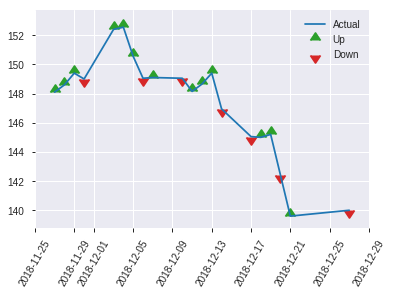


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2077907856242227
RMSE: 0.4558407459017049
LogLoss: 0.6075440323700345
Null degrees of freedom: 245
Residual degrees of freedom: 195
Null deviance: 340.2874392490048
Residual deviance: 298.911663926057
AIC: 400.911663926057
AUC: 0.7397214854111406
pr_auc: 0.7391209837044123
Gini: 0.47944297082228116
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4013689378934738: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      61   55   0.4741   (55.0/116.0)
1      18   112  0.1385   (18.0/130.0)
Total  79   167  0.2967   (73.0/246.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.401369     0.754209  166
max f2                       0.256655     0.851648  207
max f0point5                 0.401369     0.701754  166
max accuracy                 0.401369     0.703252  166
max precision                0.884581     1         0
max recall                   0.028147     1         245
max specificity              0.884581     1         0
max absolute_mcc             0.401369     0.41418   166
max min_per_class_accuracy   0.502791     0.669231  124
max mean_per_class_accuracy  0.401369     0.6937    166

Gains/Lift Table: Avg response rate: 52.85 %, avg score: 48.25 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121951                   0.859113           1.26154   1.26154            0.666667         0.874333  0.666667                    0.874333            0.0153846       0.0153846                  26.1538   26.1538
    2        0.0203252                   0.841681           1.89231   1.51385            1                0.84653   0.8                         0.863212            0.0153846       0.0307692                  89.2308   51.3846
    3        0.0325203                   0.824793           1.89231   1.65577            1                0.837481  0.875                       0.853563            0.0230769       0.0538462                  89.2308   65.5769
    4        0.0406504                   0.803176           1.89231   1.70308            1                0.809256  0.9                         0.844702            0.0153846       0.0692308                  89.2308   70.3077
    5        0.0528455                   0.789997           1.89231   1.74675            1                0.797073  0.923077                    0.83371             0.0230769       0.0923077                  89.2308   74.6746
    6        0.101626                    0.710807           1.73462   1.74092            0.916667         0.75013   0.92                        0.793592            0.0846154       0.176923                   73.4615   74.0923
    7        0.150407                    0.691642           1.41923   1.63659            0.75             0.701443  0.864865                    0.763706            0.0692308       0.246154                   41.9231   63.659
    8        0.203252                    0.657582           1.01893   1.476              0.538462         0.675329  0.78                        0.740728            0.0538462       0.3                        1.89349   47.6
    9        0.300813                    0.593252           1.34038   1.43202            0.708333         0.628933  0.756757                    0.70447             0.130769        0.430769                   34.0385   43.2017
    10       0.402439                    0.552849           1.28677   1.39534            0.68             0.570447  0.737374                    0.670626            0.130769        0.561538                   28.6769   39.5338
    11       0.5                         0.505982           0.946154  1.30769            0.5              0.528767  0.691057                    0.642946            0.0923077       0.653846                   -5.38462  30.7692
    12       0.601626                    0.453695           1.05969   1.2658             0.56             0.478835  0.668919                    0.615225            0.107692        0.761538                   5.96923   26.58
    13       0.699187                    0.379488           1.10385   1.2432             0.583333         0.417052  0.656977                    0.587573            0.107692        0.869231                   10.3846   24.3202
    14       0.800813                    0.288004           0.681231  1.17189            0.36             0.333147  0.619289                    0.555285            0.0692308       0.938462                   -31.8769  17.1886
    15       0.898374                    0.199696           0.236538  1.07031            0.125            0.24507   0.565611                    0.521597            0.0230769       0.961538                   -76.3462  7.03098
    16       1                           0.028147           0.378462  1                  0.2              0.136989  0.528455                    0.482511            0.0

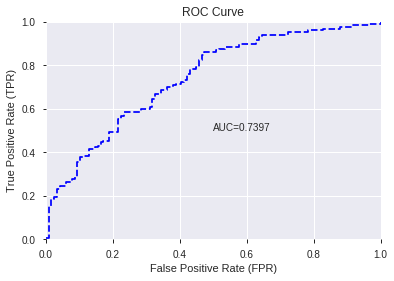

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


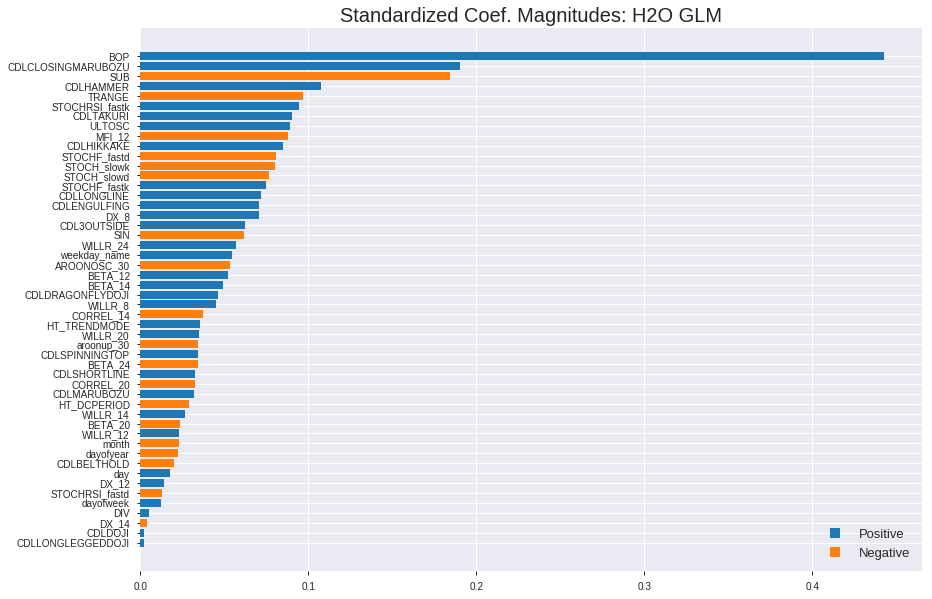

'log_likelihood'
--2019-09-05 21:48:27--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.145.195
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.145.195|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


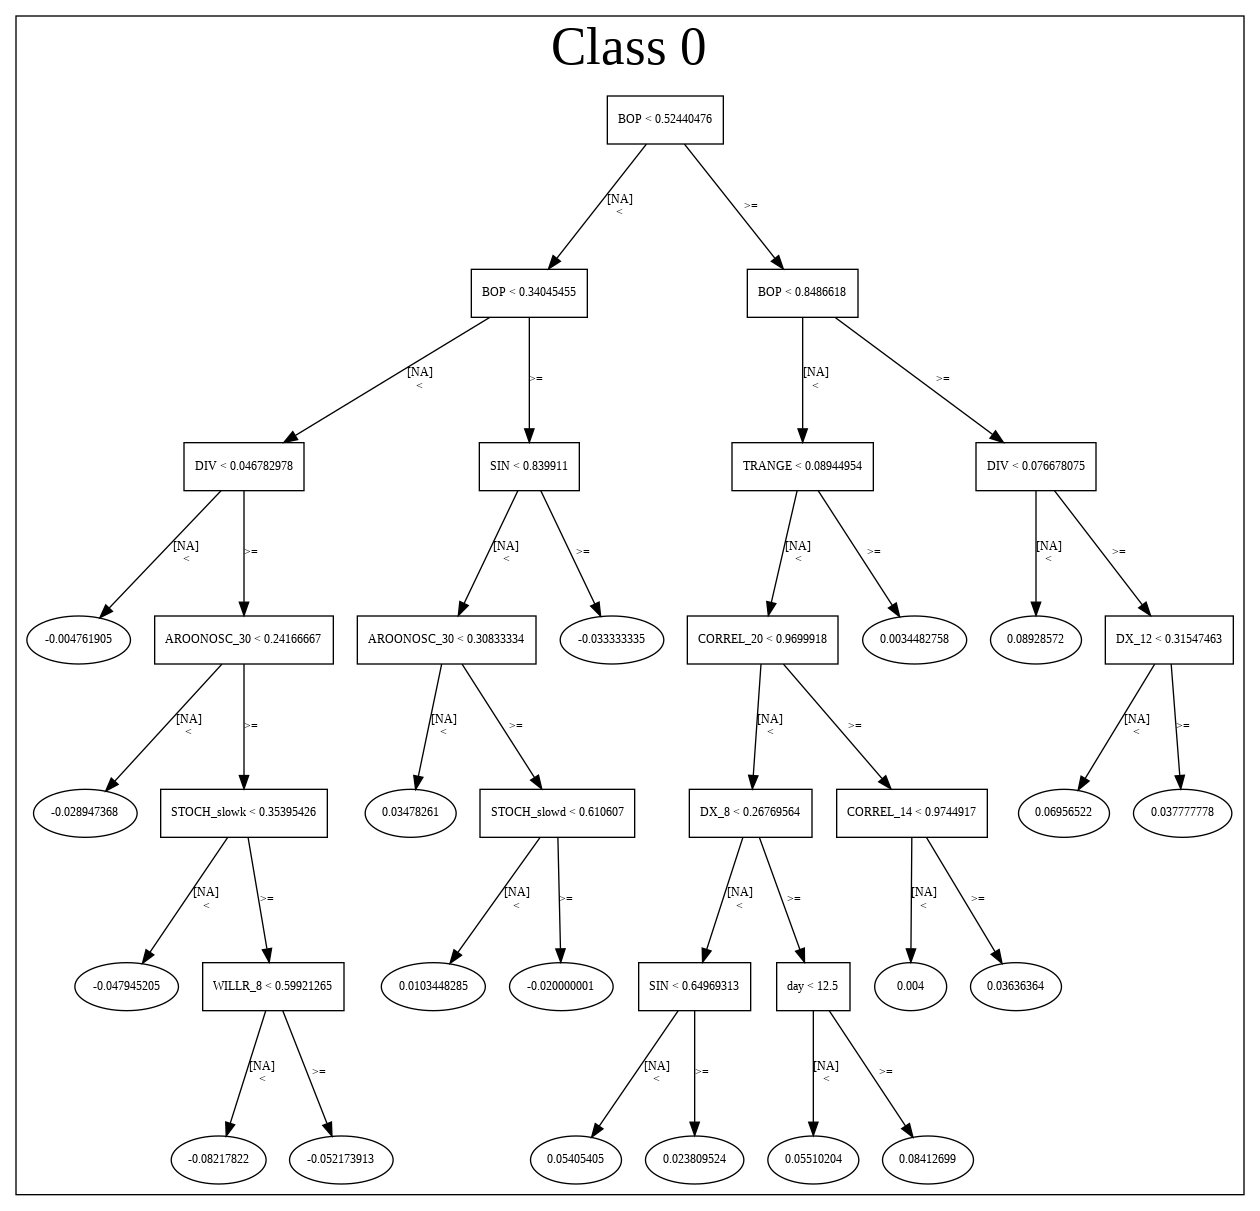

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190905_214822_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190905_214822_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_8e55',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['BOP',
 'CDLCLOSINGMARUBOZU',
 'SUB',
 'CDLHAMMER',
 'TRANGE',
 'STOCHRSI_fastk',
 'CDLTAKURI',
 'ULTOSC',
 'MFI_12',
 'CDLHIKKAKE',
 'STOCHF_fastd',
 'STOCH_slowk',
 'STOCH_slowd',
 'STOCHF_fastk',
 'CDLLONGLINE',
 'CDLENGULFING',
 'DX_8',
 'CDL3OUTSIDE',
 'SIN',
 'WILLR_24',
 'weekday_name',
 'AROONOSC_30',
 'BETA_12',
 'BETA_14',
 'CDLDRAGONFLYDOJI',
 'WILLR_8',
 'CORREL_14',
 'HT_TRENDMODE',
 'WILLR_20',
 'aroonup_30',
 'CDLSPINNINGTOP',
 'BETA_24',
 'CDLSHORTLINE',
 'CORREL_20',
 'CDLMARUBOZU',
 'HT_DCPERIOD',
 'WILLR_14',
 'BETA_20',
 'WILLR_12',
 'month',
 'dayofyear',
 'CDLBELTHOLD',
 'day',
 'DX_12',
 'STOCHRSI_fastd',
 'dayofweek',
 'DIV',
 'DX_14',
 'CDLDOJI',
 'CDLLONGLEGGEDDOJI']

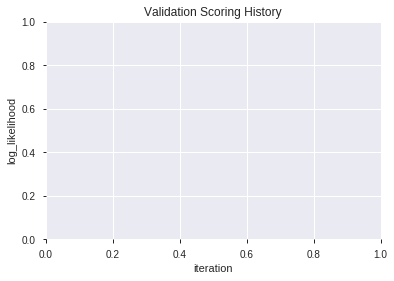

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_2_AutoML_20190905_214836  0.747082  0.596032              0.359284  0.453107  0.205306
1  XGBoost_grid_1_AutoML_20190905_214836_model_6  0.740517  0.599263              0.354509  0.455385  0.207376
2  XGBoost_grid_1_AutoML_20190905_214836_model_3  0.729111  0.607299              0.311538  0.459009  0.210690
3  XGBoost_grid_1_AutoML_20190905_214836_model_4  0.724867  0.610097              0.344960  0.459942  0.211547
4  XGBoost_grid_1_AutoML_20190905_214836_model_7  0.723740  0.617736              0.320159  0.463084  0.214447
5  XGBoost_grid_1_AutoML_20190905_214836_model_1  0.722745  0.611418              0.326923  0.461308  0.212805
6  XGBoost_grid_1_AutoML_20190905_214836_model_5  0.721751  0.619179              0.331233  0.465172  0.216385
7               XGBoost_3_AutoML_20190905_214836  0.721154  0.615781              0.310610  0.462131  0.213565
8  XGBoost_grid_1_AutoML_20190905_214836_model_2  0.717772  0.616528              0.357891  0.463579  0.214905
9               XGBoost_1_AutoML_20190905_214836  0.716247  0.621642              0.319231  0.465454  0.216648

variable  relative_importance  scaled_importance  percentage
0                  BOP          1941.208374           1.000000    0.287737
1                  SUB           312.607208           0.161037    0.046336
2         STOCHF_fastk           297.505035           0.153258    0.044098
3                DX_14           271.826294           0.140029    0.040292
4                  SIN           245.894257           0.126671    0.036448
5          STOCH_slowk           227.811386           0.117355    0.033768
6                 DX_8           211.273865           0.108836    0.031316
7               TRANGE           201.008881           0.103548    0.029795
8       STOCHRSI_fastk           192.640289           0.099237    0.028554
9          STOCH_slowd           172.656540           0.088943    0.025592
10             WILLR_8           160.094910           0.082472    0.023730
11              ULTOSC           159.189606           0.082005    0.023596
12             BETA_14           152.438919           0.078528    0.022595
13             BETA_20           150.939774           0.077756    0.022373
14           CORREL_20           149.250687           0.076885    0.022123
15                 DIV           143.490250           0.073918    0.021269
16              MFI_12           133.932373           0.068994    0.019852
17           dayofyear           131.005402           0.067487    0.019418
18             BETA_24           127.817444           0.065844    0.018946
19         HT_DCPERIOD           125.666016           0.064736    0.018627
20               DX_12           111.648018           0.057515    0.016549
21            WILLR_24           102.141121           0.052617    0.015140
22            WILLR_14            95.762459           0.049331    0.014194
23           CORREL_14            92.862358           0.047837    0.013765
24  CDLCLOSINGMARUBOZU            87.308472           0.044976    0.012941
25        STOCHF_fastd            82.319099           0.042406    0.012202
26                 day            81.358665           0.041911    0.012059
27             BETA_12            77.546043           0.039947    0.011494
28            WILLR_20            76.805382           0.039566    0.011385
29            WILLR_12            74.732193           0.038498    0.011077
30          aroonup_30            70.537460           0.036337    0.010455
31         AROONOSC_30            60.714211           0.031277    0.008999
32      STOCHRSI_fastd            55.221592           0.028447    0.008185
33        weekday_name            38.672508           0.019922    0.005732
34           dayofweek            37.532894           0.019335    0.005563
35               month            24.056469           0.012393    0.003566
36      CDLSPINNINGTOP            22.810394           0.011751    0.003381
37         CDLLONGLINE            22.689232           0.011688    0.003363
38         CDLBELTHOLD            15.917310           0.008200    0.002359
39        HT_TRENDMODE             7.572731           0.003901    0.001122

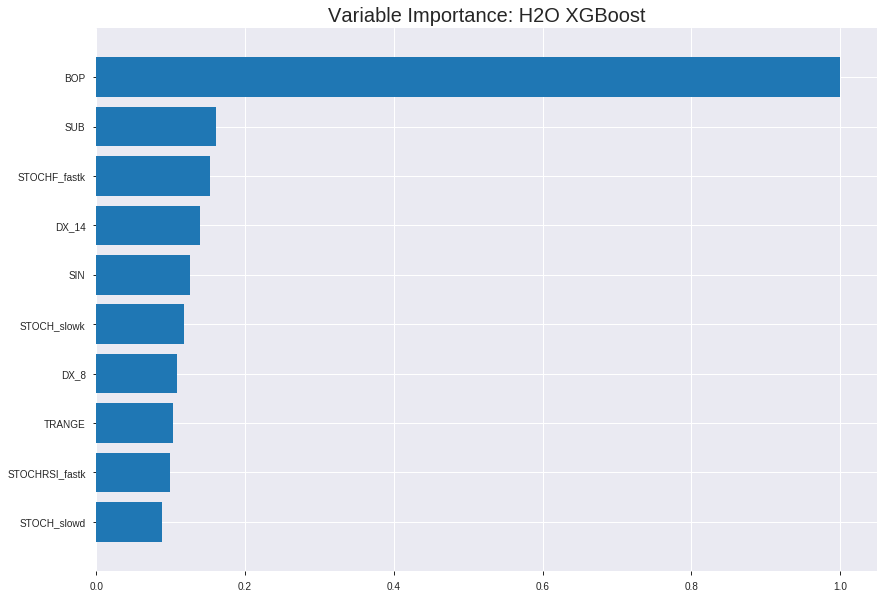

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_2_AutoML_20190905_214836


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.14934816122229738
RMSE: 0.3864558981595408
LogLoss: 0.46996639525024037
Mean Per-Class Error: 0.19342454646802476
AUC: 0.8886503834329922
pr_auc: 0.8990838750630228
Gini: 0.7773007668659844
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4869251549243927: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      614  211  0.2558   (211.0/825.0)
1      126  771  0.1405   (126.0/897.0)
Total  740  982  0.1957   (337.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.486925     0.820649  212
max f2                       0.267401     0.885009  317
max f0point5                 0.617728     0.838603  144
max accuracy                 0.538006     0.806039  185
max precision                0.905024     1         0
max recall                   0.180127     1         358
max specificity              0.905024     1         0
max absolute_mcc             0.538006     0.612615  185
max min_per_class_accuracy   0.531381     0.802424  189
max mean_per_class_accuracy  0.538006     0.806575  185

Gains/Lift Table: Avg response rate: 52.09 %, avg score: 51.84 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.86237            1.91973    1.91973            1                0.883673  1                           0.883673            0.0200669       0.0200669                  91.9732   91.9732
    2        0.0203252                   0.847952           1.91973    1.91973            1                0.854073  1                           0.869296            0.0189521       0.039019                   91.9732   91.9732
    3        0.0301974                   0.841724           1.91973    1.91973            1                0.843854  1                           0.860978            0.0189521       0.057971                   91.9732   91.9732
    4        0.0400697                   0.834774           1.91973    1.91973            1                0.837501  1                           0.855194            0.0189521       0.0769231                  91.9732   91.9732
    5        0.0505226                   0.828632           1.91973    1.91973            1                0.831856  1                           0.850366            0.0200669       0.09699                    91.9732   91.9732
    6        0.100465                    0.802815           1.87509    1.89754            0.976744         0.816233  0.988439                    0.833398            0.0936455       0.190635                   87.5088   89.7539
    7        0.150407                    0.77669            1.85277    1.88267            0.965116         0.790123  0.980695                    0.819029            0.0925307       0.283166                   85.2765   88.2672
    8        0.200348                    0.749318           1.74115    1.84739            0.906977         0.762535  0.962319                    0.804946            0.0869565       0.370123                   74.1153   84.7395
    9        0.300232                    0.691389           1.66302    1.78606            0.866279         0.722647  0.930368                    0.777566            0.166109        0.536232                   66.3024   78.6057
    10       0.400116                    0.615649           1.47328    1.70798            0.767442         0.651987  0.889695                    0.746217            0.147157        0.683389                   47.3283   70.7977
    11       0.5                         0.537398           1.10496    1.58751            0.575581         0.578237  0.826945                    0.71266             0.110368        0.793757                   10.4962   58.7514
    12       0.599884                    0.459594           0.837093   1.46256            0.436047         0.502386  0.761859                    0.677648            0.083612        0.877369                   -16.2907  46.2565
    13       0.699768                    0.365656           0.546901   1.33186            0.284884         0.415266  0.693776                    0.640196            0.0546265       0.931996                   -45.3099  33.1864
    14       0.799652                    0.278372           0.446449   1.22127            0.232558         0.323847  0.636166                    0.600681            0.0445931       0.976589                   -55.3551  22.1268
    15       0.899535                    0.192901           0.189741   1.10673            0.0988372        0.235924  0.576501                    0.560179            0.0189521       0.995541                   -81.0259  10.6728
    16       1                           0.0761582          0.0443869  1                  0.0231214        0.144405  0.520906                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.20269051165029506
RMSE: 0.4502116298478917
LogLoss: 0.5906915205711888
Mean Per-Class Error: 0.3004926108374384
AUC: 0.740533412947206
pr_auc: 0.7376873017679977
Gini: 0.48106682589441196
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34960609674453735: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      104  127  0.5498   (127.0/231.0)
1      25   236  0.0958   (25.0/261.0)
Total  129  363  0.3089   (152.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.349606     0.75641   286
max f2                       0.167981     0.863333  367
max f0point5                 0.479672     0.712773  224
max accuracy                 0.431734     0.707317  245
max precision                0.908062     1         0
max recall                   0.119826     1         389
max specificity              0.908062     1         0
max absolute_mcc             0.431734     0.414929  245
max min_per_class_accuracy   0.546644     0.675325  196
max mean_per_class_accuracy  0.431734     0.699507  245

Gains/Lift Table: Avg response rate: 53.05 %, avg score: 51.78 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.839008           1.88506   1.88506            1                0.866862  1                           0.866862            0.0191571       0.0191571                  88.5057   88.5057
    2        0.0203252                   0.825337           1.88506   1.88506            1                0.831956  1                           0.849409            0.0191571       0.0383142                  88.5057   88.5057
    3        0.0304878                   0.818667           1.88506   1.88506            1                0.823692  1                           0.840837            0.0191571       0.0574713                  88.5057   88.5057
    4        0.0406504                   0.803153           1.88506   1.88506            1                0.811754  1                           0.833566            0.0191571       0.0766284                  88.5057   88.5057
    5        0.050813                    0.800981           1.13103   1.73425            0.6              0.801749  0.92                        0.827203            0.0114943       0.0881226                  13.1034   73.4253
    6        0.101626                    0.769388           1.50805   1.62115            0.8              0.783551  0.86                        0.805377            0.0766284       0.164751                   50.8046   62.1149
    7        0.150407                    0.740136           1.02107   1.42653            0.541667         0.752194  0.756757                    0.788128            0.0498084       0.214559                   2.10728   42.653
    8        0.20122                     0.717818           1.05563   1.33287            0.56             0.727612  0.707071                    0.772846            0.0536398       0.268199                   5.56322   33.2869
    9        0.300813                    0.682316           1.42341   1.36285            0.755102         0.697851  0.722973                    0.748017            0.141762        0.409962                   42.3411   36.2846
    10       0.400407                    0.635374           1.34647   1.35877            0.714286         0.657654  0.720812                    0.725541            0.1341          0.544061                   34.647    35.8772
    11       0.5                         0.556958           1.15412   1.31801            0.612245         0.603255  0.699187                    0.701183            0.114943        0.659004                   15.4117   31.8008
    12       0.599593                    0.474426           1.23106   1.30357            0.653061         0.510569  0.691525                    0.669522            0.122605        0.781609                   23.1058   30.3565
    13       0.699187                    0.385329           0.884823  1.24392            0.469388         0.428305  0.659884                    0.635163            0.0881226       0.869732                   -11.5177  24.3919
    14       0.79878                     0.295827           0.69247   1.17516            0.367347         0.336823  0.62341                     0.597965            0.0689655       0.938697                   -30.753   17.5163
    15       0.898374                    0.203628           0.384706  1.08753            0.204082         0.250617  0.576923                    0.559458            0.0383142       0.977011                   -61.5294  8.75332
    16       1                           0.0876887          0.226207  1                  0.12             0.14955   0.530488                    0.517801          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-05 21:48:38  0.003 sec   0                  0.5              0.693147            0.5             0                  1                0.479094                         0.5                0.693147              0.5               0                    1                  0.469512
    2019-09-05 21:48:38  0.052 sec   5                  0.47591          0.64586             0.811282        0.820186           1.91973          0.28223                          0.482138           0.657869              0.736578          0.728061             1.88506            0.29878
    2019-09-05 21:48:38  0.094 sec   10                 0.458394         0.612106            0.832019        0.843472           1.91973          0.261905                         0.470364           0.634729              0.742731          0.727235             1.50805            0.306911
    2019-09-05 21:48:38  0.143 sec   15                 0.444549         0.585479            0.841713        0.851641           1.91973          0.245645                         0.463454           0.620812              0.742524          0.740475             1.88506            0.321138
    2019-09-05 21:48:38  0.187 sec   20                 0.433152         0.563139            0.847652        0.859978           1.91973          0.251452                         0.457504           0.608467              0.74254           0.741819             1.88506            0.323171
    2019-09-05 21:48:38  0.233 sec   25                 0.424841         0.54662             0.852389        0.863809           1.91973          0.24971                          0.454083           0.601006              0.740956          0.742559             1.88506            0.315041
    2019-09-05 21:48:38  0.294 sec   30                 0.417019         0.530856            0.856866        0.868385           1.91973          0.243322                         0.452353           0.596826              0.739041          0.737667             1.88506            0.313008
    2019-09-05 21:48:38  0.352 sec   35                 0.410501         0.517654            0.861224        0.873842           1.91973          0.232869                         0.453112           0.598015              0.734488          0.731137             1.88506            0.323171
    2019-09-05 21:48:38  0.412 sec   40                 0.404756         0.506129            0.867494        0.880011           1.91973          0.224739                         0.451713           0.594612              0.738585          0.739305             1.88506            0.288618
    2019-09-05 21:48:38  0.464 sec   45                 0.39937          0.495426            0.873979        0.886341           1.91973          0.218351                         0.450815           0.59251               0.738618          0.73483              1.88506            0.302846
    2019-09-05 21:48:38  0.514 sec   50                 0.395206         0.486751            0.877447        0.890669           1.91973          0.218931                         0.450602           0.591503              0.738709          0.735277             1.88506            0.313008
    2019-09-05 21:48:38  0.573 sec   55                 0.390761         0.478175            0.883283        0.893769           1.91973          0.203833                         0.450478           0.591072              0.738842          0.

Variable Importances: 


variable        relative_importance    scaled_importance     percentage
--------------  ---------------------  --------------------  ---------------------
BOP             1941.2083740234375     1.0                   0.2877370670565389
SUB             312.6072082519531      0.1610374303115276    0.046336437884160725
STOCHF_fastk    297.5050354003906      0.15325765094644014   0.04409790698730348
DX_14           271.8262939453125      0.14002942578591543   0.040291656277250586
SIN             245.89425659179688     0.12667071700404073   0.036447860592691526
---             ---                    ---                   ---
month           24.056468963623047     0.012392522763417976  0.003565788153377283
CDLSPINNINGTOP  22.810394287109375     0.011750616055622873  0.003381087799952401
CDLLONGLINE     22.689231872558594     0.011688200080000608  0.0033631284101893785
CDLBELTHOLD     15.917309761047363     0.008199691477765685  0.0023593551765807956
HT_TRENDMODE    7.572731018066406      0.003901039743801855  0.0011224737343525377


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6951219512195121)

('F1', 0.746987951807229)

('auc', 0.7470822281167109)

('logloss', 0.5960315870745704)

('mean_per_class_error', 0.30948275862068964)

('rmse', 0.4531065597097359)

('mse', 0.20530555445199244)

xgboost prediction progress: |████████████████████████████████████████████| 100%


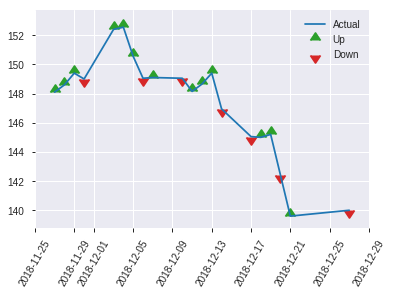


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.20530555445199244
RMSE: 0.4531065597097359
LogLoss: 0.5960315870745704
Mean Per-Class Error: 0.30948275862068964
AUC: 0.7470822281167109
pr_auc: 0.7593248158687287
Gini: 0.49416445623342176
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2485848218202591: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      38   78   0.6724   (78.0/116.0)
1      6    124  0.0462   (6.0/130.0)
Total  44   202  0.3415   (84.0/246.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.248585     0.746988  201
max f2                       0.248585     0.858726  201
max f0point5                 0.50635      0.708723  127
max accuracy                 0.395497     0.695122  156
max precision                0.868085     1         0
max recall                   0.121475     1         240
max specificity              0.868085     1         0
max absolute_mcc             0.395497     0.390329  156
max min_per_class_accuracy   0.512225     0.681034  125
max mean_per_class_accuracy  0.50635      0.690517  127

Gains/Lift Table: Avg response rate: 52.85 %, avg score: 49.02 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121951                   0.836667           1.89231   1.89231            1                0.853311  1                           0.853311            0.0230769       0.0230769                  89.2308   89.2308
    2        0.0203252                   0.828517           1.89231   1.89231            1                0.833557  1                           0.84541             0.0153846       0.0384615                  89.2308   89.2308
    3        0.0325203                   0.821465           1.89231   1.89231            1                0.825205  1                           0.837833            0.0230769       0.0615385                  89.2308   89.2308
    4        0.0406504                   0.806244           1.89231   1.89231            1                0.815107  1                           0.833288            0.0153846       0.0769231                  89.2308   89.2308
    5        0.0528455                   0.797952           1.26154   1.74675            0.666667         0.801129  0.923077                    0.825866            0.0153846       0.0923077                  26.1538   74.6746
    6        0.101626                    0.773513           1.41923   1.58954            0.75             0.786147  0.84                        0.806801            0.0692308       0.161538                   41.9231   58.9538
    7        0.150407                    0.731007           1.73462   1.63659            0.916667         0.756828  0.864865                    0.790594            0.0846154       0.246154                   73.4615   63.659
    8        0.203252                    0.693797           1.31006   1.55169            0.692308         0.712369  0.82                        0.770255            0.0692308       0.315385                   31.0059   55.1692
    9        0.300813                    0.646612           1.26154   1.45759            0.666667         0.673702  0.77027                     0.738941            0.123077        0.438462                   26.1538   45.7588
    10       0.402439                    0.592219           1.13538   1.37622            0.6              0.615759  0.727273                    0.707834            0.115385        0.553846                   13.5385   37.6224
    11       0.5                         0.517966           1.10385   1.32308            0.583333         0.556709  0.699187                    0.678346            0.107692        0.661538                   10.3846   32.3077
    12       0.601626                    0.415675           1.05969   1.27859            0.56             0.467252  0.675676                    0.642689            0.107692        0.769231                   5.96923   27.8586
    13       0.699187                    0.342101           0.946154  1.2322             0.5              0.379089  0.651163                    0.605907            0.0923077       0.861538                   -5.38462  23.22
    14       0.800813                    0.255884           0.681231  1.16228            0.36             0.291545  0.614213                    0.566014            0.0692308       0.930769                   -31.8769  16.228
    15       0.898374                    0.190075           0.394231  1.07887            0.208333         0.229352  0.570136                    0.529453            0.0384615       0.969231                   -60.5769  7.88723
    16       1                           0.10206            0.302769  1                  0.16             0.143654  0.528455                    0.490246            0

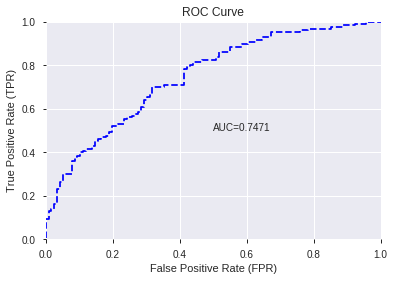

This function is available for GLM models only


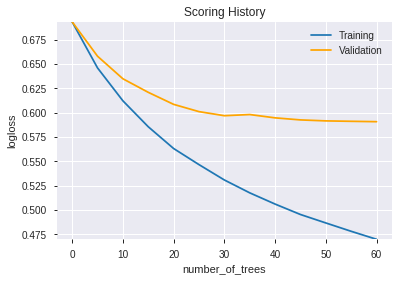

--2019-09-05 21:48:52--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.239.75
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.239.75|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip


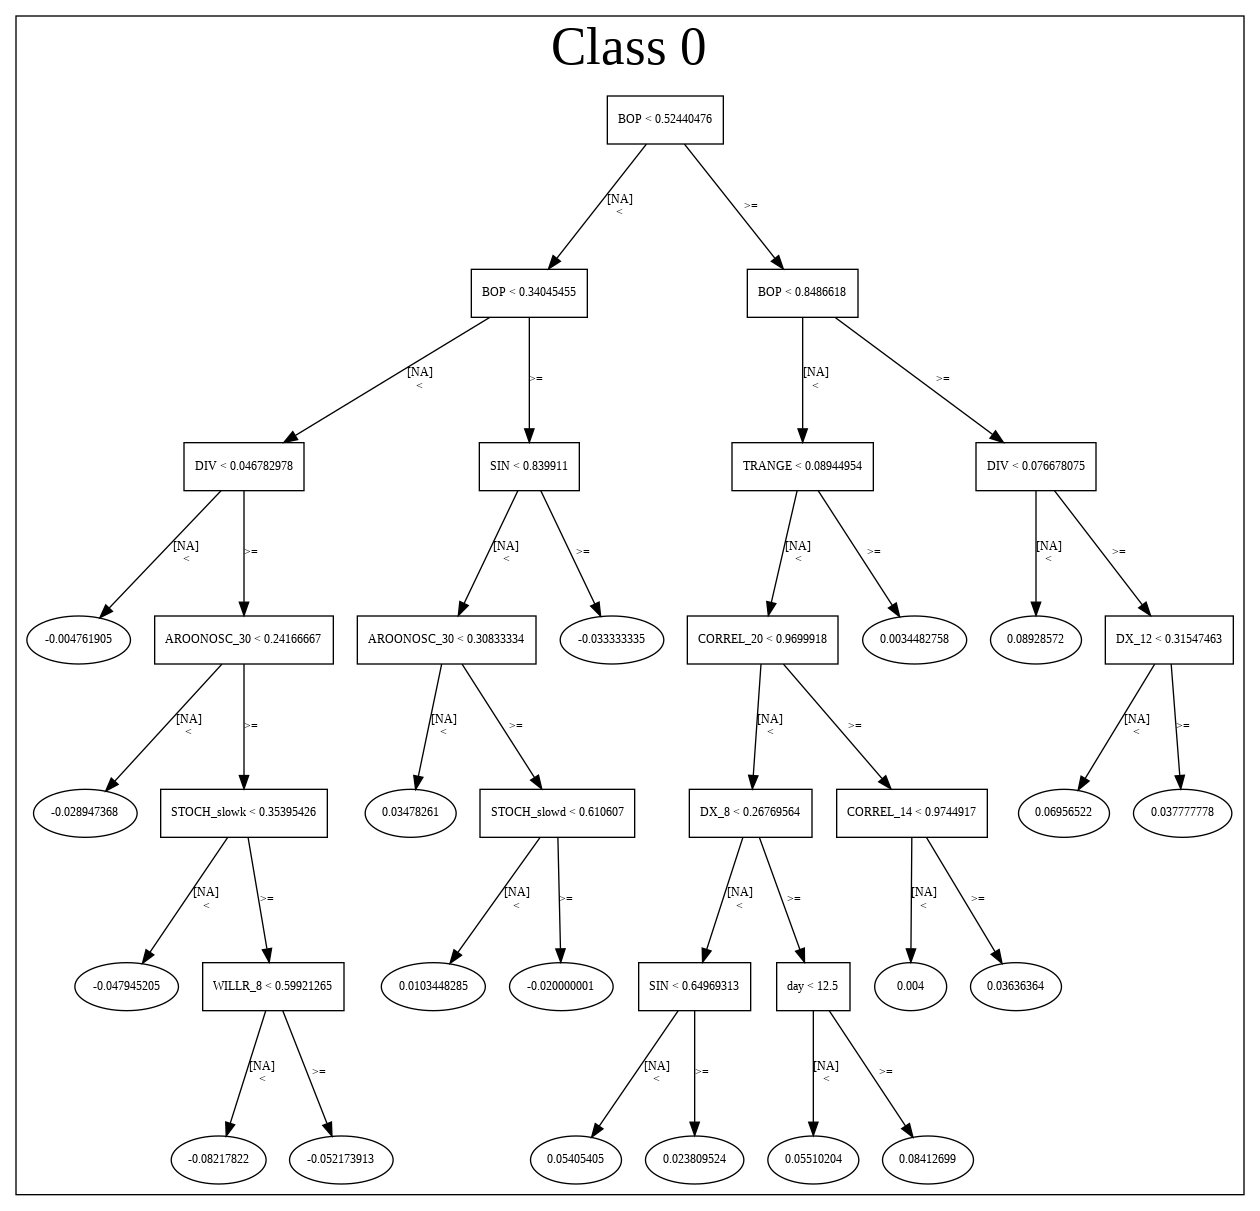

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_2_AutoML_20190905_214836',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_2_AutoML_20190905_214836',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_8e55',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_66_sid_8e55',
   'type

['BOP',
 'SUB',
 'STOCHF_fastk',
 'DX_14',
 'SIN',
 'STOCH_slowk',
 'DX_8',
 'TRANGE',
 'STOCHRSI_fastk',
 'STOCH_slowd',
 'WILLR_8',
 'ULTOSC',
 'BETA_14',
 'BETA_20',
 'CORREL_20',
 'DIV',
 'MFI_12',
 'dayofyear',
 'BETA_24',
 'HT_DCPERIOD',
 'DX_12',
 'WILLR_24',
 'WILLR_14',
 'CORREL_14',
 'CDLCLOSINGMARUBOZU',
 'STOCHF_fastd',
 'day',
 'BETA_12',
 'WILLR_20',
 'WILLR_12',
 'aroonup_30',
 'AROONOSC_30',
 'STOCHRSI_fastd',
 'weekday_name',
 'dayofweek',
 'month',
 'CDLSPINNINGTOP',
 'CDLLONGLINE',
 'CDLBELTHOLD',
 'HT_TRENDMODE']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [1007] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


31

['BOP',
 'CCI_8',
 'CMO_8',
 'MOM_8',
 'RSI_8',
 'WILLR_8',
 'CCI_12',
 'CMO_12',
 'RSI_12',
 'WILLR_12',
 'CCI_14',
 'CMO_14',
 'RSI_14',
 'WILLR_14',
 'WILLR_20',
 'WILLR_24',
 'WILLR_30',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'STOCHRSI_fastd',
 'ULTOSC',
 'ADOSC',
 'TRANGE',
 'CDLBELTHOLD',
 'CDLCLOSINGMARUBOZU',
 'CDLENGULFING',
 'CDLLONGLINE',
 'CDLMARUBOZU',
 'CDLSHORTLINE',
 'DIV',
 'SUB']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190905_214901_model_7  0.766313  0.611416              0.261936  0.446720  0.199558
1  DeepLearning_grid_1_AutoML_20190905_214901_model_9  0.760743  0.584975              0.336804  0.446729  0.199567
2  DeepLearning_grid_1_AutoML_20190905_214901_model_6  0.755172  0.588476              0.328183  0.446919  0.199737
3  DeepLearning_grid_1_AutoML_20190905_214901_model_5  0.754907  0.592817              0.354509  0.450029  0.202526
4  DeepLearning_grid_1_AutoML_20190905_214901_model_8  0.746883  0.594746              0.337732  0.452643  0.204885
5  DeepLearning_grid_1_AutoML_20190905_214901_model_3  0.743833  0.613881              0.321552  0.452903  0.205122
6  DeepLearning_grid_1_AutoML_20190905_214901_model_4  0.738992  0.629675              0.369430  0.462611  0.214009
7               DeepLearning_1_AutoML_20190905_214901  0.737931  0.668700              0.356034  0.480202  0.230594
8  DeepLearning_grid_1_AutoML_20190905_214901_model_1  0.708687  0.768498              0.352653  0.496213  0.246228
9  DeepLearning_grid_1_AutoML_20190905_214901_model_2  0.698011  0.748429              0.388528  0.502044  0.252048

variable  relative_importance  scaled_importance  percentage
0                  BOP             1.000000           1.000000    0.047321
1   CDLCLOSINGMARUBOZU             0.917571           0.917571    0.043420
2                  DIV             0.746275           0.746275    0.035314
3         CDLSHORTLINE             0.742242           0.742242    0.035123
4                ADOSC             0.715711           0.715711    0.033868
5       STOCHRSI_fastk             0.708657           0.708657    0.033534
6                  SUB             0.707293           0.707293    0.033470
7          CDLLONGLINE             0.697668           0.697668    0.033014
8          CDLMARUBOZU             0.684463           0.684463    0.032389
9               CCI_12             0.680938           0.680938    0.032223
10      STOCHRSI_fastd             0.679042           0.679042    0.032133
11        STOCHF_fastk             0.673890           0.673890    0.031889
12            WILLR_14             0.661140           0.661140    0.031286
13              ULTOSC             0.656974           0.656974    0.031089
14         CDLBELTHOLD             0.656788           0.656788    0.031080
15              CCI_14             0.656678           0.656678    0.031075
16              TRANGE             0.651027           0.651027    0.030807
17        CDLENGULFING             0.650913           0.650913    0.030802
18            WILLR_20             0.649845           0.649845    0.030751
19              CMO_14             0.645801           0.645801    0.030560
20            WILLR_24             0.643474           0.643474    0.030450
21              RSI_14             0.640611           0.640611    0.030314
22               RSI_8             0.639525           0.639525    0.030263
23               CCI_8             0.638145           0.638145    0.030198
24              RSI_12             0.636678           0.636678    0.030128
25            WILLR_12             0.634915           0.634915    0.030045
26            WILLR_30             0.631727           0.631727    0.029894
27               MOM_8             0.630397           0.630397    0.029831
28              CMO_12             0.624457           0.624457    0.029550
29             WILLR_8             0.622819           0.622819    0.029472
30               CMO_8             0.606679           0.606679    0.028709

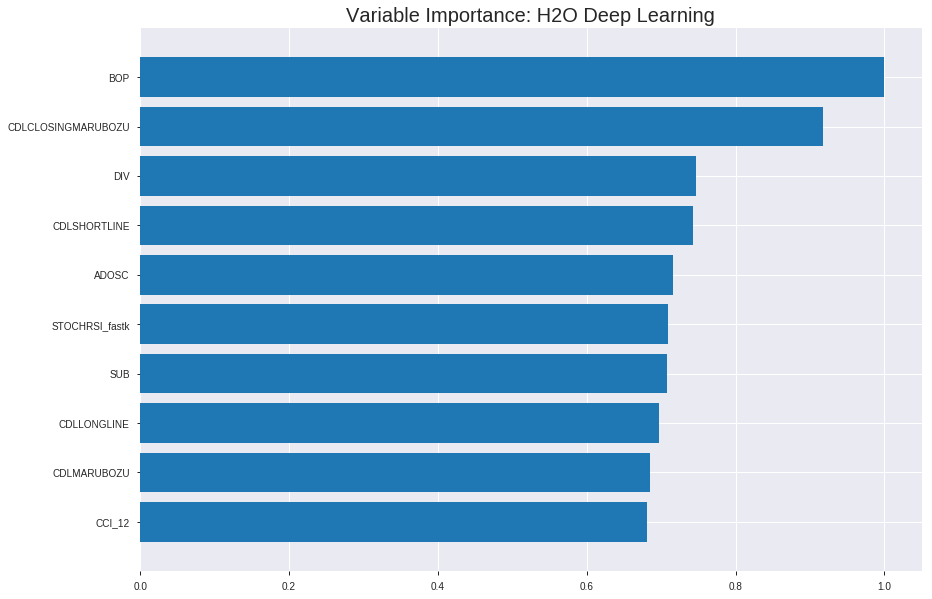

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190905_214901_model_7


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.18459125402053697
RMSE: 0.42964084305444816
LogLoss: 0.5445101093045535
Mean Per-Class Error: 0.27052802270193577
AUC: 0.7997574406270058
pr_auc: 0.7942148278770949
Gini: 0.5995148812540116
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.447049619210412: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      417  408   0.4945   (408.0/825.0)
1      99   798   0.1104   (99.0/897.0)
Total  516  1206  0.2944   (507.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.44705      0.758916  250
max f2                       0.134584     0.867137  346
max f0point5                 0.622034     0.747837  166
max accuracy                 0.59701      0.728804  179
max precision                0.999647     1         0
max recall                   0.0137883    1         391
max specificity              0.999647     1         0
max absolute_mcc             0.59701      0.45858   179
max min_per_class_accuracy   0.588538     0.722408  183
max mean_per_class_accuracy  0.59701      0.729472  179

Gains/Lift Table: Avg response rate: 52.09 %, avg score: 55.38 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.998668           1.91973   1.91973            1                0.999472   1                           0.999472            0.0200669       0.0200669                  91.9732   91.9732
    2        0.0203252                   0.990079           1.80681   1.86488            0.941176         0.995317   0.971429                    0.997454            0.0178372       0.0379041                  80.6807   86.4883
    3        0.0301974                   0.97439            1.91973   1.88281            1                0.981498   0.980769                    0.992238            0.0189521       0.0568562                  91.9732   88.2815
    4        0.0400697                   0.967452           1.91973   1.89191            1                0.970971   0.985507                    0.986998            0.0189521       0.0758082                  91.9732   89.191
    5        0.0505226                   0.956265           1.91973   1.89767            1                0.962746   0.988506                    0.98198             0.0200669       0.0958751                  91.9732   89.7667
    6        0.100465                    0.906218           1.69651   1.79767            0.883721         0.931113   0.936416                    0.956694            0.0847269       0.180602                   69.6508   79.7669
    7        0.150407                    0.856227           1.49561   1.69737            0.77907          0.881266   0.88417                     0.931648            0.0746934       0.255295                   49.5606   69.737
    8        0.200348                    0.806167           1.49561   1.64707            0.77907          0.830856   0.857971                    0.906523            0.0746934       0.329989                   49.5606   64.7075
    9        0.300232                    0.725483           1.46212   1.58554            0.761628         0.763823   0.825919                    0.859049            0.146042        0.476031                   46.2122   58.5543
    10       0.400116                    0.655293           1.28354   1.51015            0.668605         0.689174   0.786647                    0.816642            0.128205        0.604236                   28.3542   51.0152
    11       0.5                         0.591154           1.13845   1.4359             0.593023         0.624684   0.747967                    0.778295            0.113712        0.717949                   13.8446   43.5897
    12       0.599884                    0.538016           0.870576  1.34177            0.453488         0.563225   0.698935                    0.742485            0.0869565       0.804905                   -12.9424  34.1768
    13       0.699768                    0.446374           0.837093  1.26973            0.436047         0.496099   0.661411                    0.707316            0.083612        0.888517                   -16.2907  26.9732
    14       0.799652                    0.277165           0.513417  1.17526            0.267442         0.36335    0.6122                      0.664351            0.0512821       0.939799                   -48.6583  17.5261
    15       0.899535                    0.0939104          0.479933  1.09805            0.25             0.189018   0.571982                    0.611571            0.0479376       0.987737                   -52.0067  9.80523
    16       1                           0.00018861         0.122064  1                  0.0635838        0.0360446  0.520906                    0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.21248695839147577
RMSE: 0.46096307703706135
LogLoss: 0.6459629487038326
Mean Per-Class Error: 0.3259690501069812
AUC: 0.7228359124910848
pr_auc: 0.7222723420758781
Gini: 0.4456718249821696
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37500858999083386: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      91   140  0.6061   (140.0/231.0)
1      21   240  0.0805   (21.0/261.0)
Total  112  380  0.3272   (161.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.375009     0.74883   302
max f2                       0.0904252    0.858957  366
max f0point5                 0.520593     0.688989  251
max accuracy                 0.520593     0.682927  251
max precision                0.99975      1         0
max recall                   2.56337e-05  1         399
max specificity              0.99975      1         0
max absolute_mcc             0.375009     0.373108  302
max min_per_class_accuracy   0.597792     0.645022  195
max mean_per_class_accuracy  0.520593     0.674031  251

Gains/Lift Table: Avg response rate: 53.05 %, avg score: 55.32 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0101626                   0.99919            1.88506   1.88506            1                0.99956    1                           0.99956             0.0191571       0.0191571                  88.5057    88.5057
    2        0.0203252                   0.993858           1.50805   1.69655            0.8              0.997566   0.9                         0.998563            0.0153257       0.0344828                  50.8046    69.6552
    3        0.0304878                   0.962741           1.50805   1.63372            0.8              0.977828   0.866667                    0.991651            0.0153257       0.0498084                  50.8046    63.3716
    4        0.0406504                   0.933696           1.88506   1.69655            1                0.949448   0.9                         0.981101            0.0191571       0.0689655                  88.5057    69.6552
    5        0.050813                    0.918451           1.88506   1.73425            1                0.926074   0.92                        0.970095            0.0191571       0.0881226                  88.5057    73.4253
    6        0.101626                    0.854432           1.43264   1.58345            0.76             0.88542    0.84                        0.927758            0.0727969       0.16092                    43.2644    58.3448
    7        0.150407                    0.79722            1.41379   1.52842            0.75             0.820584   0.810811                    0.892999            0.0689655       0.229885                   41.3793    52.8425
    8        0.20122                     0.75751            1.28184   1.46616            0.68             0.773631   0.777778                    0.862855            0.0651341       0.295019                   28.1839    46.6156
    9        0.300813                    0.705304           1.11565   1.35011            0.591837         0.727129   0.716216                    0.817919            0.111111        0.40613                    11.5646    35.0109
    10       0.400407                    0.645077           1.26953   1.33007            0.673469         0.675217   0.705584                    0.782424            0.126437        0.532567                   26.9529    33.0066
    11       0.5                         0.601882           1.03871   1.27203            0.55102          0.624769   0.674797                    0.751021            0.103448        0.636015                   3.87051    27.2031
    12       0.599593                    0.54956            1.15412   1.25244            0.612245         0.577898   0.664407                    0.722265            0.114943        0.750958                   15.4117    25.2445
    13       0.699187                    0.478207           1.00023   1.21652            0.530612         0.521084   0.645349                    0.693609            0.0996169       0.850575                   0.0234577  21.652
    14       0.79878                     0.319196           0.807882  1.16557            0.428571         0.412572   0.618321                    0.658568            0.0804598       0.931034                   -19.2118   16.557
    15       0.898374                    0.133344           0.384706  1.079              0.204082         0.225651   0.572398                    0.610575            0.0383142       0.969349                   -61.5294   7.90035
    16       1                           3.35703e-06        0.301609  1                  0.16             0.0461755  0.530488    


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-05 21:54:15  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-05 21:54:21  8.066 sec         184 obs/sec       0.713124  1             1228       0.480781         0.676597            0.0737779      0.707715        0.715129           1.91973          0.380372                         0.471942           0.658322              0.10576          0.708787          0.702408             1.88506            0.327236
    2019-09-05 21:54:36  22.521 sec        433 obs/sec       4.94599   7             8517       0.501677         0.761886            -0.00848142    0.763867        0.751929           1.81308          0.318235                         0.504014           0.76492               -0.0199134       0.741769          0.743707             1.88506            0.323171
    2019-09-05 21:54:51  37.498 sec        514 obs/sec       9.93786   14            17113      0.485247         0.676739            0.0564917      0.779082        0.784705           1.91973          0.299071                         0.4908             0.712114              0.0328648        0.756904          0.760579             1.88506            0.294715
    2019-09-05 21:55:05  52.012 sec        554 obs/sec       14.9472   21            25739      0.429641         0.54451             0.260342       0.799757        0.794215           1.91973          0.294425                         0.460963           0.645963              0.14688          0.722836          0.722272             1.88506            0.327236
    2019-09-05 21:55:20  1 min  6.260 sec  580 obs/sec       19.964    28            34378      0.464677         0.633746            0.134788       0.805896        0.782392           1.91973          0.285134                         0.490761           0.769299              0.0330183        0.739911          0.725123             1.50805            0.327236
    2019-09-05 21:55:34  1 min 20.342 sec  598 obs/sec       24.9977   35            43046      0.414968         0.511093            0.31           0.821347        0.789374           1.91973          0.295587                         0.463671           0.672015              0.136828         0.721799          0.706245             1.50805            0.331301
    2019-09-05 21:55:35  1 min 21.753 sec  597 obs/sec       24.9977   35            43046      0.429641         0.54451             0.260342       0.799757        0.794215           1.91973          0.294425                         0.460963           0.645963              0.14688          0.722836          0.722272             1.88506            0.327236

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.047320830979309544
CDLCLOSINGMARUBOZU  0.9175711870193481     0.9175711870193481   0.043420231052427004
DIV                 0.7462752461433411     0.7462752461433411   0.035314364786791674
CDLSHORTLINE        0.7422417402267456     0.7422417402267456   0.03512349593505841
ADOSC               0.7157105803489685     0.7157105803489685   0.03386801940279709
---                 ---                    ---                  ---
WILLR_30            0.631726861000061      0.631726861000061    0.029893840014473663
MOM_8               0.6303969621658325     0.6303969621658325   0.029830908096519556
CMO_12              0.624456524848938      0.624456524848938    0.029549801666303607
WILLR_8             0.6228193044662476     0.6228193044662476   0.02947232703729843
CMO_8               0.6066789627075195     0.6066789627075195   0.028708552652985372


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7398373983739838)

('F1', 0.7575757575757576)

('auc', 0.7663129973474802)

('logloss', 0.6114156232073252)

('mean_per_class_error', 0.26193633952254647)

('rmse', 0.4467196632526132)

('mse', 0.19955845753652815)

deeplearning prediction progress: |███████████████████████████████████████| 100%


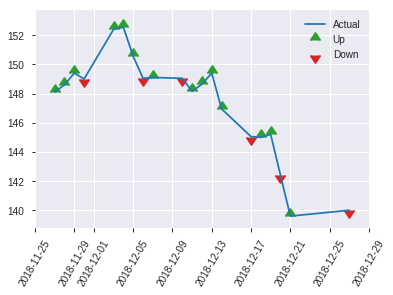


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.19955845753652815
RMSE: 0.4467196632526132
LogLoss: 0.6114156232073252
Mean Per-Class Error: 0.26193633952254647
AUC: 0.7663129973474802
pr_auc: 0.7824325007540208
Gini: 0.5326259946949603
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5598929405976985: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      82   34   0.2931   (34.0/116.0)
1      30   100  0.2308   (30.0/130.0)
Total  112  134  0.2602   (64.0/246.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.559893     0.757576  133
max f2                       0.000998662  0.849673  244
max f0point5                 0.559893     0.750751  133
max accuracy                 0.559893     0.739837  133
max precision                0.994808     1         0
max recall                   0.000998662  1         244
max specificity              0.994808     1         0
max absolute_mcc             0.559893     0.477268  133
max min_per_class_accuracy   0.585688     0.715517  126
max mean_per_class_accuracy  0.559893     0.738064  133

Gains/Lift Table: Avg response rate: 52.85 %, avg score: 54.07 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121951                   0.96459            1.89231   1.89231            1                0.980998   1                           0.980998            0.0230769       0.0230769                  89.2308   89.2308
    2        0.0203252                   0.949278           1.89231   1.89231            1                0.958953   1                           0.97218             0.0153846       0.0384615                  89.2308   89.2308
    3        0.0325203                   0.942104           1.89231   1.89231            1                0.945748   1                           0.962268            0.0230769       0.0615385                  89.2308   89.2308
    4        0.0406504                   0.933408           1.89231   1.89231            1                0.937509   1                           0.957316            0.0153846       0.0769231                  89.2308   89.2308
    5        0.0528455                   0.929836           1.89231   1.89231            1                0.931685   1                           0.951401            0.0230769       0.1                        89.2308   89.2308
    6        0.101626                    0.863665           1.57692   1.74092            0.833333         0.896648   0.92                        0.92512             0.0769231       0.176923                   57.6923   74.0923
    7        0.150407                    0.808941           1.26154   1.58545            0.666667         0.835483   0.837838                    0.896048            0.0615385       0.238462                   26.1538   58.5447
    8        0.203252                    0.755879           1.60118   1.58954            0.846154         0.787464   0.84                        0.867817            0.0846154       0.323077                   60.1183   58.9538
    9        0.300813                    0.687388           1.34038   1.50873            0.708333         0.719233   0.797297                    0.819627            0.130769        0.453846                   34.0385   50.8732
    10       0.402439                    0.639475           1.21108   1.43357            0.64             0.665594   0.757576                    0.78073             0.123077        0.576923                   21.1077   43.3566
    11       0.5                         0.589176           1.18269   1.38462            0.625            0.609445   0.731707                    0.747308            0.115385        0.692308                   18.2692   38.4615
    12       0.601626                    0.52818            0.984     1.31694            0.52             0.556752   0.695946                    0.71512             0.1             0.792308                   -1.6      31.6944
    13       0.699187                    0.442219           0.709615  1.2322             0.375            0.493054   0.651163                    0.684134            0.0692308       0.861538                   -29.0385  23.22
    14       0.800813                    0.293371           0.681231  1.16228            0.36             0.367882   0.614213                    0.644               0.0692308       0.930769                   -31.8769  16.228
    15       0.898374                    0.109936           0.315385  1.07031            0.166667         0.20459    0.565611                    0.596282            0.0307692       0.961538                   -68.4615  7.03098
    16       1                           0.000273436        0.378462  1                  0.2              0.0498218  0.528455                    0.

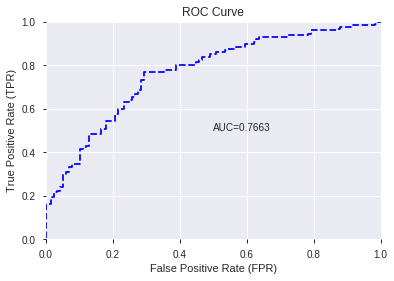

This function is available for GLM models only


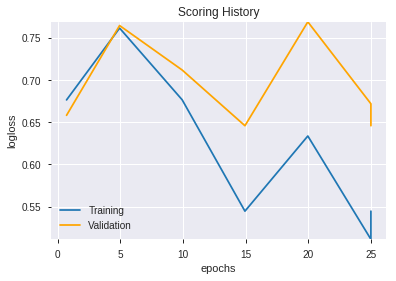

--2019-09-05 21:58:35--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.138.4
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.138.4|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


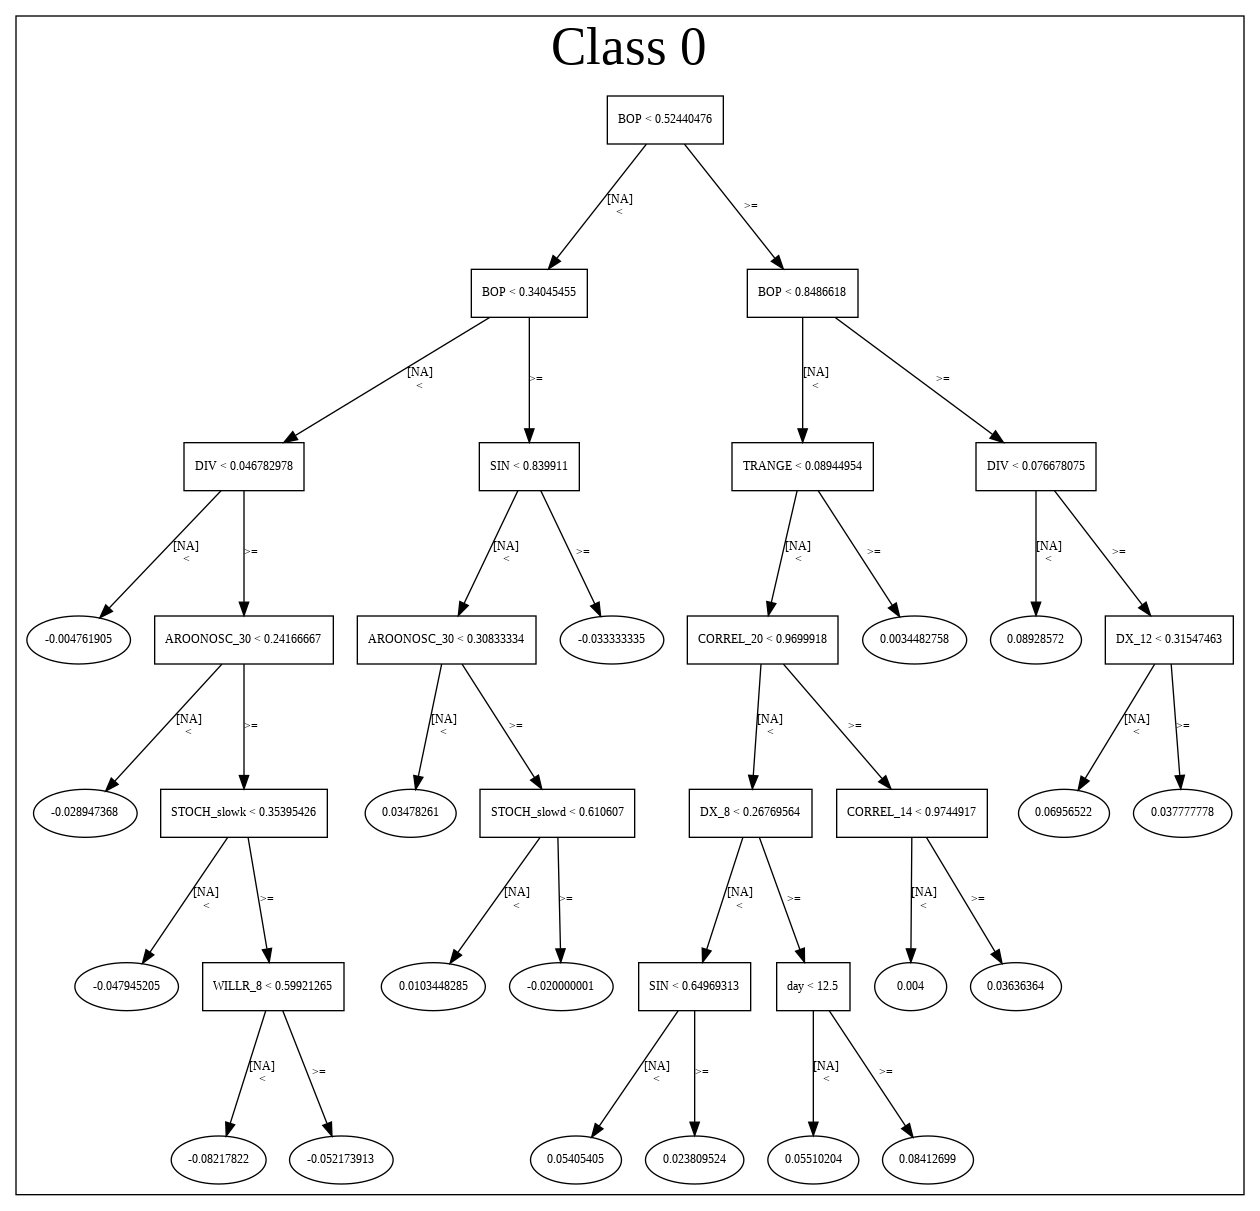

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190905_214901_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190905_214901_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_8e55',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'DIV',
 'CDLSHORTLINE',
 'ADOSC',
 'STOCHRSI_fastk',
 'SUB',
 'CDLLONGLINE',
 'CDLMARUBOZU',
 'CCI_12',
 'STOCHRSI_fastd',
 'STOCHF_fastk',
 'WILLR_14',
 'ULTOSC',
 'CDLBELTHOLD',
 'CCI_14',
 'TRANGE',
 'CDLENGULFING',
 'WILLR_20',
 'CMO_14',
 'WILLR_24',
 'RSI_14',
 'RSI_8',
 'CCI_8',
 'RSI_12',
 'WILLR_12',
 'WILLR_30',
 'MOM_8',
 'CMO_12',
 'WILLR_8',
 'CMO_8']

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190905_215844_model_1  0.750133  0.594431              0.317706  0.450824  0.203243

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.556470           1.000000    0.222902
1                  SUB             0.240002           0.431294    0.096136
2   CDLCLOSINGMARUBOZU             0.199412           0.358351    0.079877
3       STOCHRSI_fastk             0.148403           0.266686    0.059445
4                CCI_8             0.105792           0.190113    0.042377
5               CCI_14             0.101114           0.181705    0.040503
6               ULTOSC             0.090461           0.162562    0.036235
7         STOCHF_fastk             0.086088           0.154704    0.034484
8             WILLR_24             0.078034           0.140231    0.031258
9       STOCHRSI_fastd             0.072461           0.130216    0.029025
10              TRANGE             0.070658           0.126975    0.028303
11             WILLR_8             0.066048           0.118691    0.026456
12              RSI_14             0.058303           0.104772    0.023354
13              CMO_14             0.057992           0.104215    0.023230
14              CCI_12             0.054789           0.098458    0.021947
15               MOM_8             0.054208           0.097414    0.021714
16            WILLR_12             0.053872           0.096810    0.021579
17        CDLENGULFING             0.049860           0.089600    0.019972
18         CDLLONGLINE             0.048805           0.087704    0.019549
19            WILLR_14             0.048341           0.086871    0.019364
20            WILLR_20             0.042244           0.075914    0.016921
21         CDLBELTHOLD             0.040480           0.072744    0.016215
22              CMO_12             0.034724           0.062401    0.013909
23              RSI_12             0.033752           0.060653    0.013520
24                 DIV             0.031584           0.056757    0.012651
25         CDLMARUBOZU             0.027985           0.050290    0.011210
26               CMO_8             0.016246           0.029195    0.006508
27               RSI_8             0.015908           0.028588    0.006372
28        CDLSHORTLINE             0.006745           0.012122    0.002702
29               ADOSC             0.004707           0.008458    0.001885
30            WILLR_30             0.000990           0.001778    0.000396

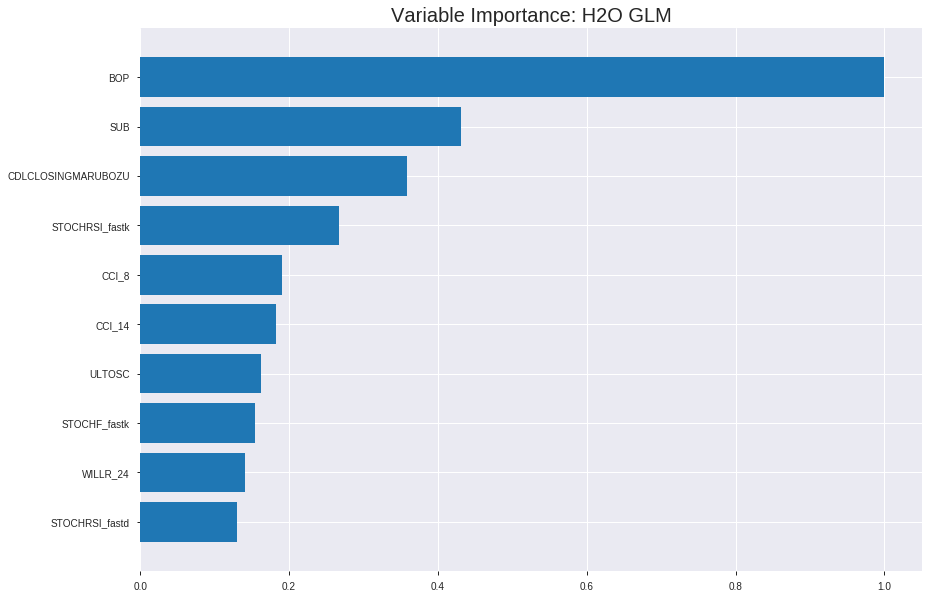

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190905_215844_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.1990067171405904
RMSE: 0.4461016892375441
LogLoss: 0.5831219165644099
Null degrees of freedom: 1721
Residual degrees of freedom: 1690
Null deviance: 2384.1875591118605
Residual deviance: 2008.2718806478279
AIC: 2072.271880647828
AUC: 0.7605411979325022
pr_auc: 0.7551485227713002
Gini: 0.5210823958650044
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4370128483366063: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      452  373   0.4521   (373.0/825.0)
1      141  756   0.1572   (141.0/897.0)
Total  593  1129  0.2985   (514.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.437013     0.746298  244
max f2                       0.240037     0.855084  340
max f0point5                 0.569767     0.715379  166
max accuracy                 0.452944     0.704994  235
max precision                0.908201     1         0
max recall                   0.107622     1         388
max specificity              0.908201     1         0
max absolute_mcc             0.452944     0.413216  235
max min_per_class_accuracy   0.525815     0.695652  192
max mean_per_class_accuracy  0.452944     0.700051  235

Gains/Lift Table: Avg response rate: 52.09 %, avg score: 52.09 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.884195           1.81308   1.81308            0.944444         0.892556  0.944444                    0.892556            0.0189521       0.0189521                  81.3081   81.3081
    2        0.0203252                   0.869582           1.46803   1.64548            0.764706         0.875717  0.857143                    0.884378            0.0144928       0.0334448                  46.8031   64.5485
    3        0.0301974                   0.855809           1.91973   1.73514            1                0.862897  0.903846                    0.877355            0.0189521       0.0523969                  91.9732   73.5143
    4        0.0400697                   0.847965           1.91973   1.78062            1                0.851916  0.927536                    0.871087            0.0189521       0.0713489                  91.9732   78.0621
    5        0.0505226                   0.83766            1.59978   1.74321            0.833333         0.842753  0.908046                    0.865225            0.0167224       0.0880713                  59.9777   74.3205
    6        0.100465                    0.777771           1.51793   1.63122            0.790698         0.806934  0.849711                    0.836248            0.0758082       0.16388                    51.7928   63.1218
    7        0.150407                    0.738235           1.47328   1.57878            0.767442         0.75787   0.822394                    0.810223            0.0735786       0.237458                   47.3283   57.8776
    8        0.200348                    0.711069           1.45096   1.54691            0.755814         0.724896  0.805797                    0.788953            0.0724638       0.309922                   45.0961   54.6915
    9        0.300232                    0.653765           1.2947    1.46301            0.674419         0.680566  0.762089                    0.752894            0.12932         0.439242                   29.4703   46.3007
    10       0.400116                    0.596091           1.32819   1.42935            0.69186          0.624519  0.744557                    0.720846            0.132664        0.571906                   32.8187   42.9351
    11       0.5                         0.529983           1.13845   1.37124            0.593023         0.563215  0.714286                    0.689357            0.113712        0.685619                   13.8446   37.1237
    12       0.599884                    0.468765           1.02683   1.31389            0.534884         0.500613  0.684414                    0.65793             0.102564        0.788183                   2.68336   31.3892
    13       0.699768                    0.405707           0.81477   1.24265            0.424419         0.438796  0.647303                    0.626651            0.0813824       0.869565                   -18.523   24.2648
    14       0.799652                    0.33599            0.613868  1.16411            0.319767         0.371523  0.606391                    0.594783            0.0613155       0.930881                   -38.6132  16.4108
    15       0.899535                    0.237005           0.479933  1.08814            0.25             0.292368  0.566817                    0.561203            0.0479376       0.978818                   -52.0067  8.81376
    16       1                           0.0657497          0.210838  1                  0.109827         0.160093  0.520906                    0.520906         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.19777018308882166
RMSE: 0.4447135966988435
LogLoss: 0.5916567591416491
Null degrees of freedom: 491
Residual degrees of freedom: 460
Null deviance: 680.4075335465611
Residual deviance: 582.1902509953823
AIC: 646.1902509953823
AUC: 0.7634306944651772
pr_auc: 0.7540635055726994
Gini: 0.5268613889303544
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44497024476595176: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      138  93   0.4026   (93.0/231.0)
1      38   223  0.1456   (38.0/261.0)
Total  176  316  0.2663   (131.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.44497      0.772964  247
max f2                       0.196278     0.863454  363
max f0point5                 0.470281     0.733564  231
max accuracy                 0.44497      0.73374   247
max precision                0.846871     0.9       9
max recall                   0.000215847  1         399
max specificity              0.915101     0.995671  0
max absolute_mcc             0.44497      0.470415  247
max min_per_class_accuracy   0.530919     0.689655  197
max mean_per_class_accuracy  0.44497      0.725904  247

Gains/Lift Table: Avg response rate: 53.05 %, avg score: 50.74 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.879025           1.50805   1.50805            0.8              0.896035  0.8                         0.896035            0.0153257       0.0153257                  50.8046   50.8046
    2        0.0203252                   0.84196            1.88506   1.69655            1                0.866429  0.9                         0.881232            0.0191571       0.0344828                  88.5057   69.6552
    3        0.0304878                   0.831848           1.50805   1.63372            0.8              0.8367    0.866667                    0.866388            0.0153257       0.0498084                  50.8046   63.3716
    4        0.0406504                   0.80838            1.50805   1.6023             0.8              0.818381  0.85                        0.854386            0.0153257       0.0651341                  50.8046   60.2299
    5        0.050813                    0.797772           1.88506   1.65885            1                0.803571  0.88                        0.844223            0.0191571       0.0842912                  88.5057   65.8851
    6        0.101626                    0.744381           1.58345   1.62115            0.84             0.769421  0.86                        0.806822            0.0804598       0.164751                   58.3448   62.1149
    7        0.150407                    0.696555           1.57088   1.60485            0.833333         0.718914  0.851351                    0.778311            0.0766284       0.241379                   57.0881   60.4846
    8        0.20122                     0.675865           1.35724   1.54232            0.72             0.685356  0.818182                    0.754838            0.0689655       0.310345                   35.7241   54.232
    9        0.300813                    0.630846           1.19259   1.42653            0.632653         0.656542  0.756757                    0.722294            0.118774        0.429119                   19.2587   42.653
    10       0.400407                    0.579936           1.19259   1.36834            0.632653         0.609408  0.725888                    0.694216            0.118774        0.547893                   19.2587   36.8341
    11       0.5                         0.536604           1.26953   1.34866            0.673469         0.55877   0.715447                    0.667237            0.126437        0.67433                    26.9529   34.8659
    12       0.599593                    0.470477           1.34647   1.3483             0.714286         0.504123  0.715254                    0.640143            0.1341          0.808429                   34.647    34.8295
    13       0.699187                    0.403542           0.730941  1.26036            0.387755         0.437224  0.668605                    0.611239            0.0727969       0.881226                   -26.9059  26.0358
    14       0.79878                     0.339173           0.500117  1.16557            0.265306         0.369991  0.618321                    0.58116             0.0498084       0.931034                   -49.9883  16.557
    15       0.898374                    0.213274           0.461647  1.08753            0.244898         0.287195  0.576923                    0.548571            0.045977        0.977011                   -53.8353  8.75332
    16       1                           0.000215847        0.226207  1                  0.12             0.143766  0.530488                    0.507432            


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-09-05 21:58:44  0.000 sec   2            21        32            1.3644            1.36386
    2019-09-05 21:58:44  0.006 sec   4            13        32            1.35503           1.35483
    2019-09-05 21:58:44  0.013 sec   6            8.1       32            1.34278           1.34282
    2019-09-05 21:58:44  0.019 sec   8            5         32            1.32765           1.32771
    2019-09-05 21:58:44  0.025 sec   10           3.1       32            1.30977           1.3095
    2019-09-05 21:58:44  0.031 sec   12           1.9       32            1.28956           1.28866
    2019-09-05 21:58:45  0.038 sec   14           1.2       32            1.2679            1.26633
    2019-09-05 21:58:45  0.052 sec   16           0.75      32            1.24621           1.24434
    2019-09-05 21:58:45  0.062 sec   18           0.46      32            1.22602           1.22455
    2019-09-05 21:58:45  0.068 sec   20           0.29      32            1.2085            1.20842
    2019-09-05 21:58:45  0.076 sec   22           0.18      32            1.19403           1.19651
    2019-09-05 21:58:45  0.082 sec   24           0.11      32            1.18242           1.18871
    2019-09-05 21:58:45  0.096 sec   26           0.069     32            1.17328           1.1845
    2019-09-05 21:58:45  0.102 sec   28           0.043     32            1.16624           1.18331
    2019-09-05 21:58:45  0.108 sec   30           0.027     32            1.16099           1.18448
    2019-09-05 21:58:45  0.115 sec   32           0.017     32            1.15717           1.18737
    2019-09-05 21:58:45  0.122 sec   34           0.01      32            1.15443           1.19139
    2019-09-05 21:58:45  0.131 sec   36           0.0064    32            1.15245           1.19607
    2019-09-05 21:58:45  0.142 sec   38           0.004     32            1.1509            1.20117

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6951219512195121)

('F1', 0.7588424437299035)

('auc', 0.750132625994695)

('logloss', 0.5944312974289521)

('mean_per_class_error', 0.3110079575596817)

('rmse', 0.4508243473386027)

('mse', 0.2032425921532771)

glm prediction progress: |████████████████████████████████████████████████| 100%


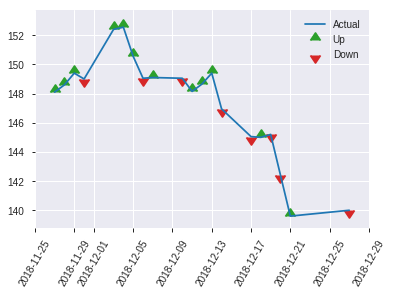


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2032425921532771
RMSE: 0.4508243473386027
LogLoss: 0.5944312974289521
Null degrees of freedom: 245
Residual degrees of freedom: 214
Null deviance: 340.2874392490048
Residual deviance: 292.4601983350444
AIC: 356.4601983350444
AUC: 0.750132625994695
pr_auc: 0.759378699740303
Gini: 0.50026525198939
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3471780546764312: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      53   63   0.5431   (63.0/116.0)
1      12   118  0.0923   (12.0/130.0)
Total  65   181  0.3049   (75.0/246.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.347178     0.758842  180
max f2                       0.245934     0.866303  212
max f0point5                 0.525082     0.710702  116
max accuracy                 0.347178     0.695122  180
max precision                0.872913     1         0
max recall                   0.0459096    1         245
max specificity              0.872913     1         0
max absolute_mcc             0.347178     0.41277   180
max min_per_class_accuracy   0.496933     0.681034  125
max mean_per_class_accuracy  0.525082     0.688992  116

Gains/Lift Table: Avg response rate: 52.85 %, avg score: 49.00 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121951                   0.848576           1.89231   1.89231            1                0.860082  1                           0.860082            0.0230769       0.0230769                  89.2308   89.2308
    2        0.0203252                   0.839694           1.89231   1.89231            1                0.845534  1                           0.854263            0.0153846       0.0384615                  89.2308   89.2308
    3        0.0325203                   0.830516           1.89231   1.89231            1                0.836307  1                           0.847529            0.0230769       0.0615385                  89.2308   89.2308
    4        0.0406504                   0.815932           1.89231   1.89231            1                0.82355   1                           0.842733            0.0153846       0.0769231                  89.2308   89.2308
    5        0.0528455                   0.786981           1.89231   1.89231            1                0.803895  1                           0.83377             0.0230769       0.1                        89.2308   89.2308
    6        0.101626                    0.730638           1.41923   1.66523            0.75             0.749603  0.88                        0.79337             0.0692308       0.169231                   41.9231   66.5231
    7        0.150407                    0.695817           1.26154   1.5343             0.666667         0.714844  0.810811                    0.767902            0.0615385       0.230769                   26.1538   53.4304
    8        0.203252                    0.6759             1.60118   1.55169            0.846154         0.686116  0.82                        0.746638            0.0846154       0.315385                   60.1183   55.1692
    9        0.300813                    0.624996           1.18269   1.43202            0.625            0.654049  0.756757                    0.716609            0.115385        0.430769                   18.2692   43.2017
    10       0.402439                    0.552725           1.28677   1.39534            0.68             0.588848  0.737374                    0.684346            0.130769        0.561538                   28.6769   39.5338
    11       0.5                         0.499364           1.10385   1.33846            0.583333         0.533293  0.707317                    0.654872            0.107692        0.669231                   10.3846   33.8462
    12       0.601626                    0.447547           0.984     1.27859            0.52             0.476859  0.675676                    0.624802            0.1             0.769231                   -1.6      27.8586
    13       0.699187                    0.380732           0.788462  1.2102             0.416667         0.416797  0.639535                    0.595778            0.0769231       0.846154                   -21.1538  21.0197
    14       0.800813                    0.297514           0.832615  1.16228            0.44             0.336308  0.614213                    0.562851            0.0846154       0.930769                   -16.7385  16.228
    15       0.898374                    0.202684           0.473077  1.08743            0.25             0.254224  0.574661                    0.529335            0.0461538       0.976923                   -52.6923  8.74347
    16       1                           0.0459096          0.227077  1                  0.12             0.142181  0.528455                    0.48999           

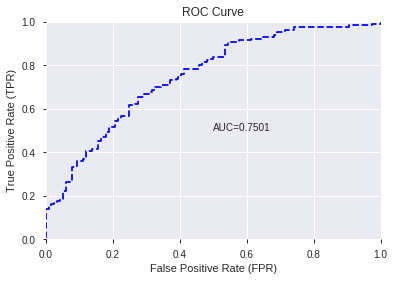

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


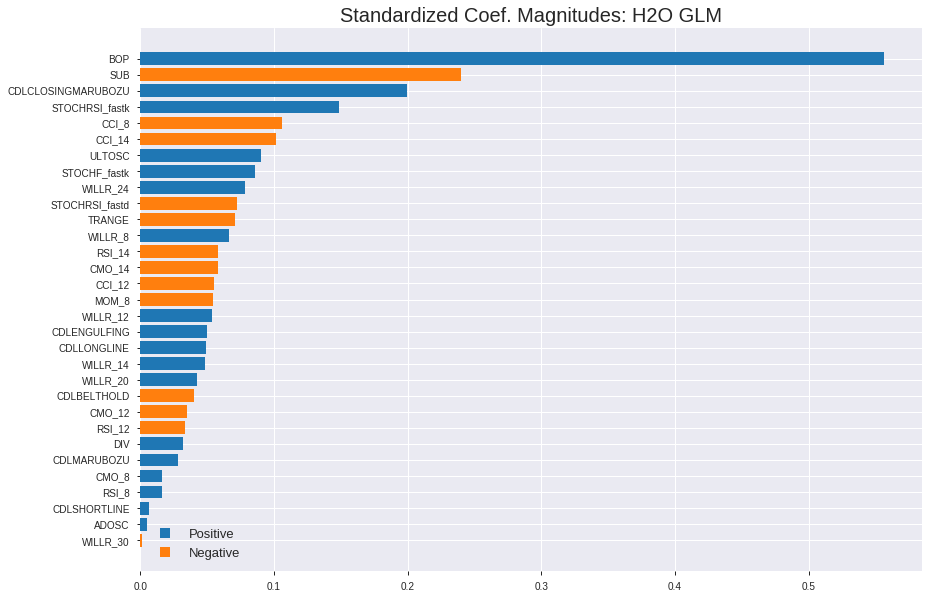

'log_likelihood'
--2019-09-05 21:58:49--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.32.36
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.32.36|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


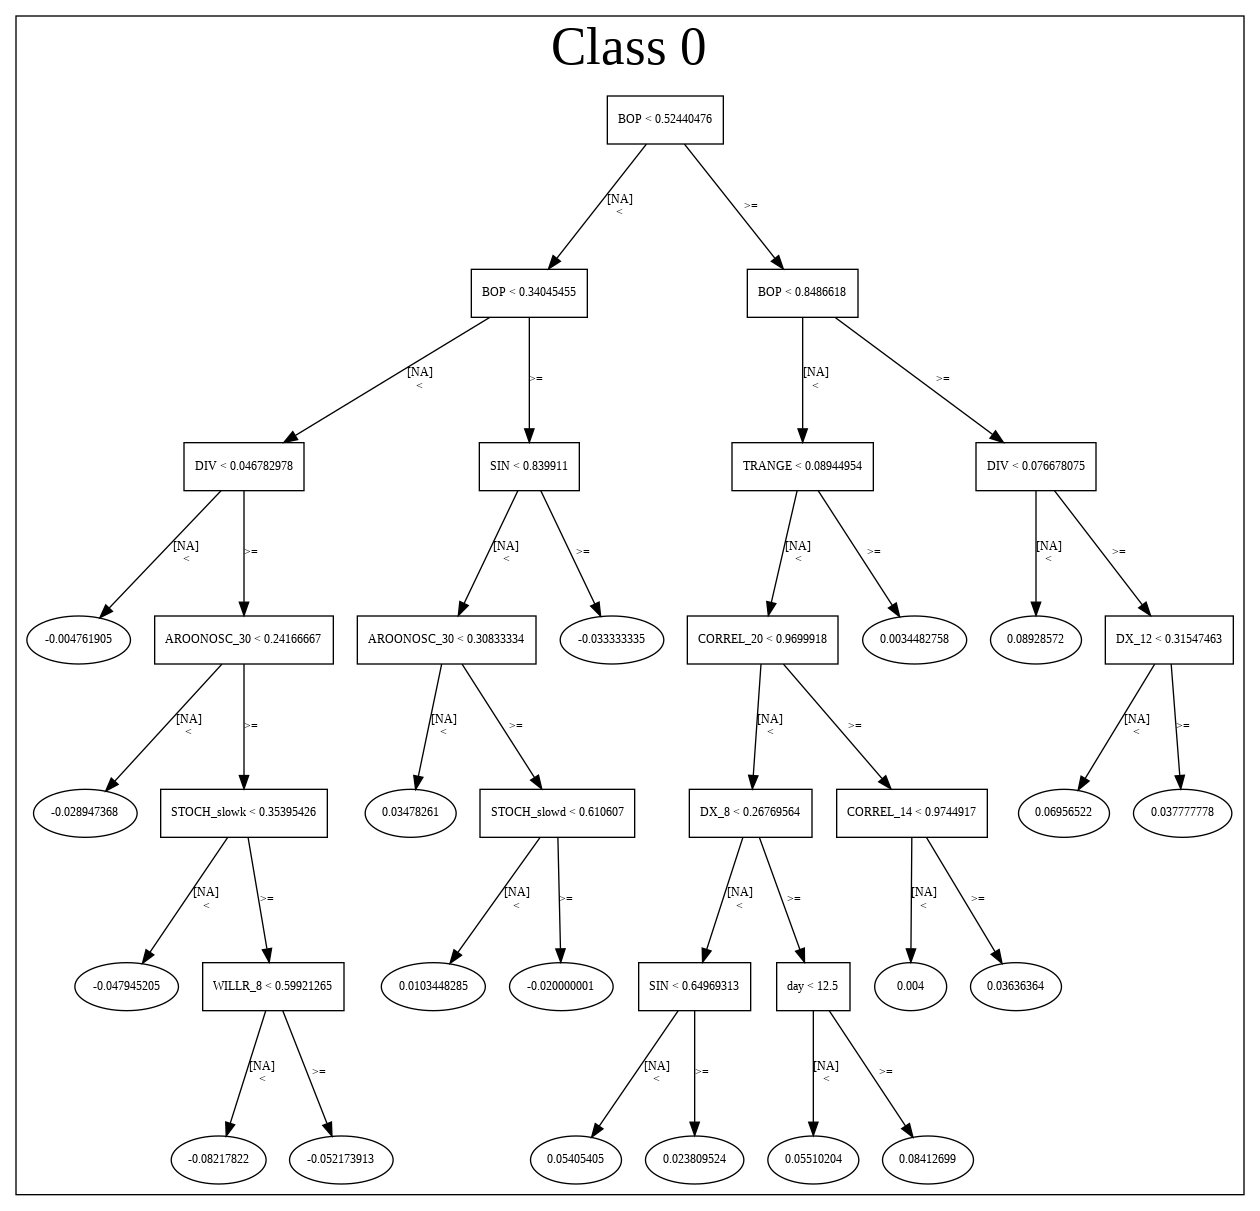

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190905_215844_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190905_215844_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_8e55',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['BOP',
 'SUB',
 'CDLCLOSINGMARUBOZU',
 'STOCHRSI_fastk',
 'CCI_8',
 'CCI_14',
 'ULTOSC',
 'STOCHF_fastk',
 'WILLR_24',
 'STOCHRSI_fastd',
 'TRANGE',
 'WILLR_8',
 'RSI_14',
 'CMO_14',
 'CCI_12',
 'MOM_8',
 'WILLR_12',
 'CDLENGULFING',
 'CDLLONGLINE',
 'WILLR_14',
 'WILLR_20',
 'CDLBELTHOLD',
 'CMO_12',
 'RSI_12',
 'DIV',
 'CDLMARUBOZU',
 'CMO_8',
 'RSI_8',
 'CDLSHORTLINE',
 'ADOSC',
 'WILLR_30']

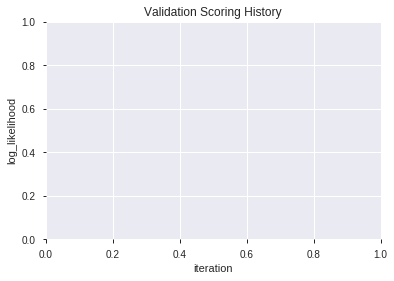

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_2_AutoML_20190905_215857  0.761207  0.587166              0.338793  0.448775  0.201399
1               XGBoost_3_AutoML_20190905_215857  0.754775  0.589755              0.312931  0.451082  0.203475
2  XGBoost_grid_1_AutoML_20190905_215857_model_4  0.752520  0.597214              0.339721  0.453152  0.205347
3  XGBoost_grid_1_AutoML_20190905_215857_model_6  0.752122  0.594494              0.355106  0.452383  0.204651
4  XGBoost_grid_1_AutoML_20190905_215857_model_7  0.750796  0.597151              0.373740  0.453718  0.205860
5  XGBoost_grid_1_AutoML_20190905_215857_model_2  0.745889  0.598398              0.327719  0.454399  0.206478
6               XGBoost_1_AutoML_20190905_215857  0.743037  0.601209              0.385146  0.455815  0.207767
7  XGBoost_grid_1_AutoML_20190905_215857_model_3  0.740650  0.600453              0.361737  0.455661  0.207627
8  XGBoost_grid_1_AutoML_20190905_215857_model_1  0.737003  0.605434              0.356034  0.458297  0.210036
9  XGBoost_grid_1_AutoML_20190905_215857_model_5  0.725531  0.626662              0.376658  0.466563  0.217681

variable  relative_importance  scaled_importance  percentage
0                  BOP          2080.791748           1.000000    0.340036
1         STOCHF_fastk           466.355377           0.224124    0.076210
2                  SUB           337.671844           0.162280    0.055181
3               ULTOSC           256.815186           0.123422    0.041968
4       STOCHRSI_fastk           237.348572           0.114066    0.038787
5                  DIV           232.868652           0.111913    0.038055
6       STOCHRSI_fastd           198.965393           0.095620    0.032514
7               CCI_12           192.083496           0.092313    0.031390
8                CCI_8           189.336639           0.090993    0.030941
9              WILLR_8           175.515350           0.084350    0.028682
10               ADOSC           175.438766           0.084313    0.028670
11              TRANGE           162.391739           0.078043    0.026537
12              CCI_14           156.643311           0.075281    0.025598
13            WILLR_24           149.975922           0.072076    0.024509
14               MOM_8           145.278793           0.069819    0.023741
15            WILLR_14           138.719681           0.066667    0.022669
16              CMO_12           133.367188           0.064094    0.021794
17            WILLR_20           111.864693           0.053761    0.018281
18              CMO_14            93.056953           0.044722    0.015207
19               CMO_8            84.903412           0.040803    0.013875
20            WILLR_30            81.747238           0.039287    0.013359
21  CDLCLOSINGMARUBOZU            77.504822           0.037248    0.012666
22            WILLR_12            73.903046           0.035517    0.012077
23               RSI_8            54.418724           0.026153    0.008893
24         CDLLONGLINE            50.984688           0.024503    0.008332
25              RSI_14            38.518932           0.018512    0.006295
26              RSI_12            18.597046           0.008937    0.003039
27         CDLBELTHOLD             4.265372           0.002050    0.000697

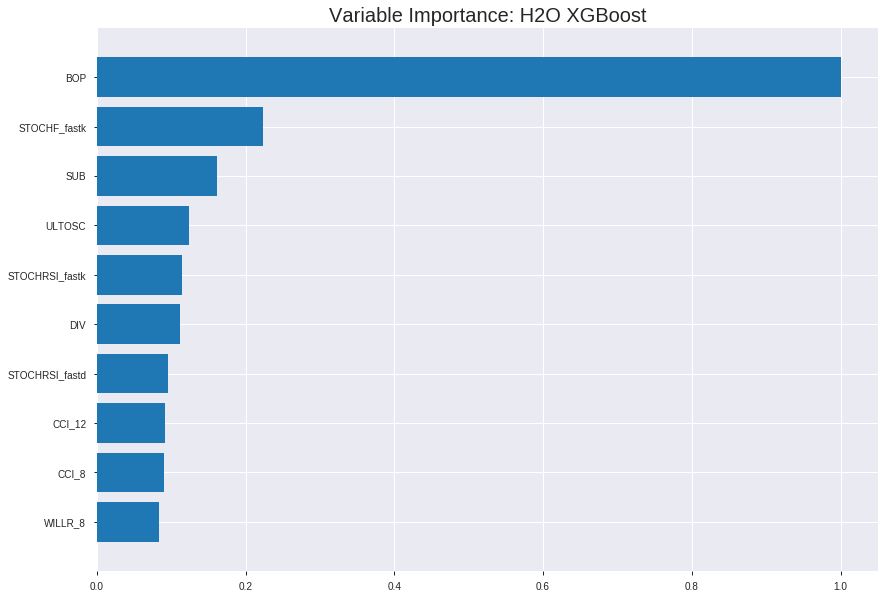

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_2_AutoML_20190905_215857


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.15756121231549935
RMSE: 0.3969398094365182
LogLoss: 0.4884567114825744
Mean Per-Class Error: 0.20435593392115137
AUC: 0.8686503834329922
pr_auc: 0.8786597316845879
Gini: 0.7373007668659843
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5037057399749756: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      622  203  0.2461   (203.0/825.0)
1      150  747  0.1672   (150.0/897.0)
Total  772  950  0.205    (353.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.503706     0.808879  203
max f2                       0.266484     0.87465   316
max f0point5                 0.651242     0.812779  126
max accuracy                 0.55139      0.795006  179
max precision                0.892192     1         0
max recall                   0.11717      1         384
max specificity              0.892192     1         0
max absolute_mcc             0.55139      0.590781  179
max min_per_class_accuracy   0.541945     0.791527  184
max mean_per_class_accuracy  0.55139      0.795644  179

Gains/Lift Table: Avg response rate: 52.09 %, avg score: 51.91 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.867152           1.91973    1.91973            1                0.879237  1                           0.879237            0.0200669       0.0200669                  91.9732   91.9732
    2        0.0203252                   0.860315           1.91973    1.91973            1                0.863282  1                           0.871487            0.0189521       0.039019                   91.9732   91.9732
    3        0.0301974                   0.849078           1.91973    1.91973            1                0.854276  1                           0.86586             0.0189521       0.057971                   91.9732   91.9732
    4        0.0400697                   0.839155           1.91973    1.91973            1                0.843939  1                           0.86046             0.0189521       0.0769231                  91.9732   91.9732
    5        0.0505226                   0.830947           1.81308    1.89767            0.944444         0.83445   0.988506                    0.855078            0.0189521       0.0958751                  81.3081   89.7667
    6        0.100465                    0.800001           1.85277    1.87535            0.965116         0.812665  0.976879                    0.833994            0.0925307       0.188406                   85.2765   87.5346
    7        0.150407                    0.771714           1.80812    1.85302            0.94186          0.785526  0.965251                    0.817901            0.090301        0.278707                   80.812    85.3024
    8        0.200348                    0.74447            1.74115    1.82514            0.906977         0.758474  0.950725                    0.803087            0.0869565       0.365663                   74.1153   82.5137
    9        0.300232                    0.682514           1.57373    1.7415             0.819767         0.715075  0.907157                    0.773806            0.157191        0.522854                   57.3734   74.1498
    10       0.400116                    0.619251           1.38399    1.65225            0.72093          0.653302  0.860668                    0.743724            0.138239        0.661093                   38.3993   65.2252
    11       0.5                         0.549189           1.21657    1.56522            0.633721         0.582524  0.815331                    0.711521            0.121516        0.782609                   21.6575   56.5217
    12       0.599884                    0.462834           0.714319   1.42354            0.372093         0.504543  0.74153                     0.677058            0.0713489       0.853958                   -28.5681  42.3538
    13       0.699768                    0.378814           0.703158   1.32071            0.366279         0.422177  0.687967                    0.640677            0.0702341       0.924192                   -29.6842  32.0712
    14       0.799652                    0.287855           0.379482   1.20314            0.197674         0.328864  0.626725                    0.601729            0.0379041       0.962096                   -62.0518  20.3144
    15       0.899535                    0.18867            0.312515   1.10425            0.162791         0.23837   0.57521                     0.561381            0.0312152       0.993311                   -68.7485  10.4249
    16       1                           0.0757433          0.0665803  1                  0.0346821        0.140239  0.520906                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2040815754646013
RMSE: 0.45175388815659495
LogLoss: 0.5955327343963268
Mean Per-Class Error: 0.3038264417574763
AUC: 0.7380040138660828
pr_auc: 0.7187997869616612
Gini: 0.47600802773216566
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3145564794540405: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      100  131  0.5671   (131.0/231.0)
1      19   242  0.0728   (19.0/261.0)
Total  119  373  0.3049   (150.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.314556     0.763407  299
max f2                       0.291148     0.858339  313
max f0point5                 0.452521     0.708083  242
max accuracy                 0.452521     0.703252  242
max precision                0.900171     1         0
max recall                   0.0922769    1         399
max specificity              0.900171     1         0
max absolute_mcc             0.314556     0.419687  299
max min_per_class_accuracy   0.550659     0.666667  193
max mean_per_class_accuracy  0.452521     0.696174  242

Gains/Lift Table: Avg response rate: 53.05 %, avg score: 51.54 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.866671           1.88506   1.88506            1                0.881534  1                           0.881534            0.0191571       0.0191571                  88.5057   88.5057
    2        0.0203252                   0.833009           1.13103   1.50805            0.6              0.847952  0.8                         0.864743            0.0114943       0.0306513                  13.1034   50.8046
    3        0.0304878                   0.82239            1.88506   1.63372            1                0.828269  0.866667                    0.852585            0.0191571       0.0498084                  88.5057   63.3716
    4        0.0406504                   0.816097           1.50805   1.6023             0.8              0.818143  0.85                        0.843974            0.0153257       0.0651341                  50.8046   60.2299
    5        0.050813                    0.809698           1.13103   1.50805            0.6              0.814434  0.8                         0.838066            0.0114943       0.0766284                  13.1034   50.8046
    6        0.101626                    0.767928           1.50805   1.50805            0.8              0.784544  0.8                         0.811305            0.0766284       0.153257                   50.8046   50.8046
    7        0.150407                    0.738446           1.33525   1.452              0.708333         0.753136  0.77027                     0.792439            0.0651341       0.218391                   33.5249   45.2004
    8        0.20122                     0.718614           1.20644   1.38999            0.64             0.72902   0.737374                    0.776424            0.0613027       0.279693                   20.6437   38.9992
    9        0.300813                    0.681113           1.34647   1.37558            0.714286         0.698097  0.72973                     0.750492            0.1341          0.413793                   34.647    37.5582
    10       0.400407                    0.626807           1.34647   1.36834            0.714286         0.655435  0.725888                    0.726848            0.1341          0.547893                   34.647    36.8341
    11       0.5                         0.558275           1.07718   1.31034            0.571429         0.59667   0.695122                    0.700918            0.10728         0.655172                   7.71757   31.0345
    12       0.599593                    0.475077           1.19259   1.29079            0.632653         0.515051  0.684746                    0.670045            0.118774        0.773946                   19.2587   29.0785
    13       0.699187                    0.378123           0.884823  1.23296            0.469388         0.429398  0.65407                     0.635767            0.0881226       0.862069                   -11.5177  23.2959
    14       0.79878                     0.282905           0.807882  1.17996            0.428571         0.330226  0.625954                    0.597672            0.0804598       0.942529                   -19.2118  17.996
    15       0.898374                    0.185656           0.307764  1.08327            0.163265         0.237475  0.574661                    0.55774             0.0306513       0.97318                    -69.2236  8.32683
    16       1                           0.0922769          0.263908  1                  0.14             0.141579  0.530488                    0.515448          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-05 21:58:59  0.003 sec   0                  0.5              0.693147            0.5             0                  1                0.479094                         0.5                0.693147              0.5               0                    1                  0.469512
    2019-09-05 21:58:59  0.040 sec   5                  0.475674         0.645405            0.807228        0.811523           1.91973          0.269454                         0.48184            0.657293              0.733509          0.70963              1.07718            0.304878
    2019-09-05 21:58:59  0.074 sec   10                 0.458525         0.6123              0.816766        0.825762           1.91973          0.265389                         0.471678           0.637254              0.72743           0.705775             1.50805            0.310976
    2019-09-05 21:58:59  0.111 sec   15                 0.446047         0.588113            0.825681        0.833192           1.91973          0.255517                         0.465151           0.62416               0.73161           0.720169             1.88506            0.296748
    2019-09-05 21:58:59  0.147 sec   20                 0.435704         0.567835            0.833121        0.838269           1.81308          0.246806                         0.459791           0.613175              0.735491          0.730611             1.88506            0.302846
    2019-09-05 21:58:59  0.186 sec   25                 0.428103         0.552537            0.837708        0.843353           1.91973          0.24158                          0.456094           0.605398              0.736627          0.722634             1.88506            0.300813
    2019-09-05 21:58:59  0.228 sec   30                 0.421739         0.539387            0.841332        0.849374           1.91973          0.238676                         0.454271           0.601393              0.737357          0.718048             1.88506            0.315041
    2019-09-05 21:58:59  0.274 sec   35                 0.416566         0.52842             0.844465        0.85432            1.91973          0.239837                         0.452397           0.597134              0.74011           0.719005             1.88506            0.308943
    2019-09-05 21:58:59  0.318 sec   40                 0.412485         0.520071            0.849626        0.860886           1.91973          0.231707                         0.451757           0.595758              0.739588          0.719251             1.88506            0.300813
    2019-09-05 21:58:59  0.367 sec   45                 0.408103         0.511133            0.854739        0.865997           1.91973          0.221254                         0.451994           0.596004              0.737954          0.718588             1.50805            0.310976
    2019-09-05 21:58:59  0.428 sec   50                 0.403734         0.502213            0.85993         0.870956           1.91973          0.212544                         0.452365           0.596811              0.73676           0.717875             1.50805            0.313008
    2019-09-05 21:58:59  0.477 sec   55                 0.400134         0.495027            0.864857        0.875671           1.91973          0.204994                         0.451975           0.596001              0.737963          0

Variable Importances: 


variable        relative_importance    scaled_importance      percentage
--------------  ---------------------  ---------------------  ---------------------
BOP             2080.791748046875      1.0                    0.3400357342636161
STOCHF_fastk    466.3553771972656      0.22412400358421636    0.07621017012486034
SUB             337.6718444824219      0.16228046117511563    0.055181155772318684
ULTOSC          256.815185546875       0.12342185890920286    0.041967842418371225
STOCHRSI_fastk  237.34857177734375     0.11406647109213588    0.038786676252673964
---             ---                    ---                    ---
RSI_8           54.418724060058594     0.026152893056759986   0.008892918193673209
CDLLONGLINE     50.98468780517578      0.024502542290948774   0.008331739959228073
RSI_14          38.5189323425293       0.018511671039970676   0.006294629654522947
RSI_12          18.5970458984375       0.008937485414334964   0.003039064415333749
CDLBELTHOLD     4.265371799468994      0.0020498792363400444  0.0006970321912806276


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6951219512195121)

('F1', 0.7452229299363058)

('auc', 0.7612068965517241)

('logloss', 0.587166054425088)

('mean_per_class_error', 0.29774535809018565)

('rmse', 0.4487745607754952)

('mse', 0.20139860639923865)

xgboost prediction progress: |████████████████████████████████████████████| 100%


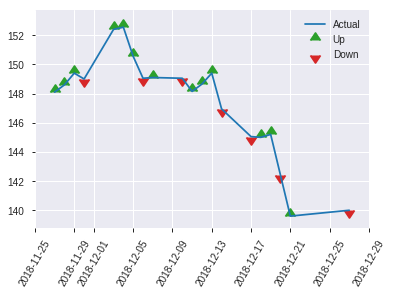


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.20139860639923865
RMSE: 0.4487745607754952
LogLoss: 0.587166054425088
Mean Per-Class Error: 0.29774535809018565
AUC: 0.7612068965517241
pr_auc: 0.7914790709778752
Gini: 0.5224137931034483
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.29875338077545166: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      49   67   0.5776   (67.0/116.0)
1      13   117  0.1      (13.0/130.0)
Total  62   184  0.3252   (80.0/246.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.298753     0.745223  183
max f2                       0.121033     0.855263  239
max f0point5                 0.610772     0.735294  94
max accuracy                 0.610772     0.695122  94
max precision                0.863966     1         0
max recall                   0.121033     1         239
max specificity              0.863966     1         0
max absolute_mcc             0.610772     0.414743  94
max min_per_class_accuracy   0.529067     0.676923  124
max mean_per_class_accuracy  0.610772     0.702255  94

Gains/Lift Table: Avg response rate: 52.85 %, avg score: 49.85 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121951                   0.850717           1.89231   1.89231            1                0.857433  1                           0.857433            0.0230769       0.0230769                  89.2308   89.2308
    2        0.0203252                   0.838066           1.89231   1.89231            1                0.843557  1                           0.851883            0.0153846       0.0384615                  89.2308   89.2308
    3        0.0325203                   0.822493           1.89231   1.89231            1                0.830393  1                           0.843824            0.0230769       0.0615385                  89.2308   89.2308
    4        0.0406504                   0.811614           1.89231   1.89231            1                0.816902  1                           0.83844             0.0153846       0.0769231                  89.2308   89.2308
    5        0.0528455                   0.809137           1.89231   1.89231            1                0.810031  1                           0.831884            0.0230769       0.1                        89.2308   89.2308
    6        0.101626                    0.770121           1.89231   1.89231            1                0.788949  1                           0.811275            0.0923077       0.192308                   89.2308   89.2308
    7        0.150407                    0.739177           1.41923   1.73888            0.75             0.754309  0.918919                    0.792799            0.0692308       0.261538                   41.9231   73.8877
    8        0.203252                    0.712673           1.31006   1.62738            0.692308         0.727161  0.86                        0.775733            0.0692308       0.330769                   31.0059   62.7385
    9        0.300813                    0.648536           1.26154   1.50873            0.666667         0.679908  0.797297                    0.744655            0.123077        0.453846                   26.1538   50.8732
    10       0.402439                    0.607152           1.28677   1.45268            0.68             0.629506  0.767677                    0.715577            0.130769        0.584615                   28.6769   45.2681
    11       0.5                         0.532183           0.867308  1.33846            0.458333         0.571886  0.707317                    0.68754             0.0846154       0.669231                   -13.2692  33.8462
    12       0.601626                    0.453606           0.908308  1.2658             0.48             0.495459  0.668919                    0.655094            0.0923077       0.761538                   -9.16923  26.58
    13       0.699187                    0.332022           0.946154  1.2212             0.5              0.383531  0.645349                    0.617201            0.0923077       0.853846                   -5.38462  22.1199
    14       0.800813                    0.26056            0.756923  1.16228            0.4              0.296629  0.614213                    0.576519            0.0769231       0.930769                   -24.3077  16.228
    15       0.898374                    0.196663           0.394231  1.07887            0.208333         0.22298   0.570136                    0.538126            0.0384615       0.969231                   -60.5769  7.88723
    16       1                           0.08719            0.302769  1                  0.16             0.148019  0.528455                    0.498481            

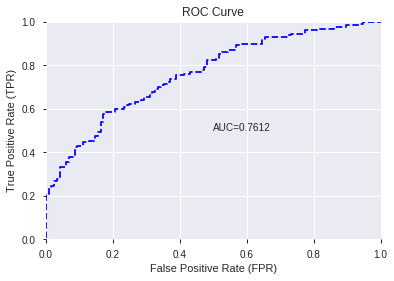

This function is available for GLM models only


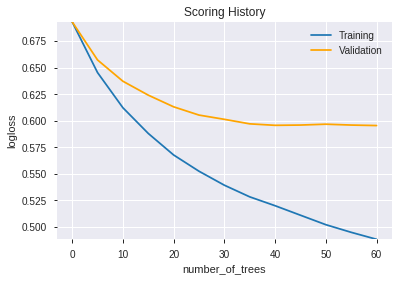

--2019-09-05 21:59:13--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.93.195
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.93.195|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip


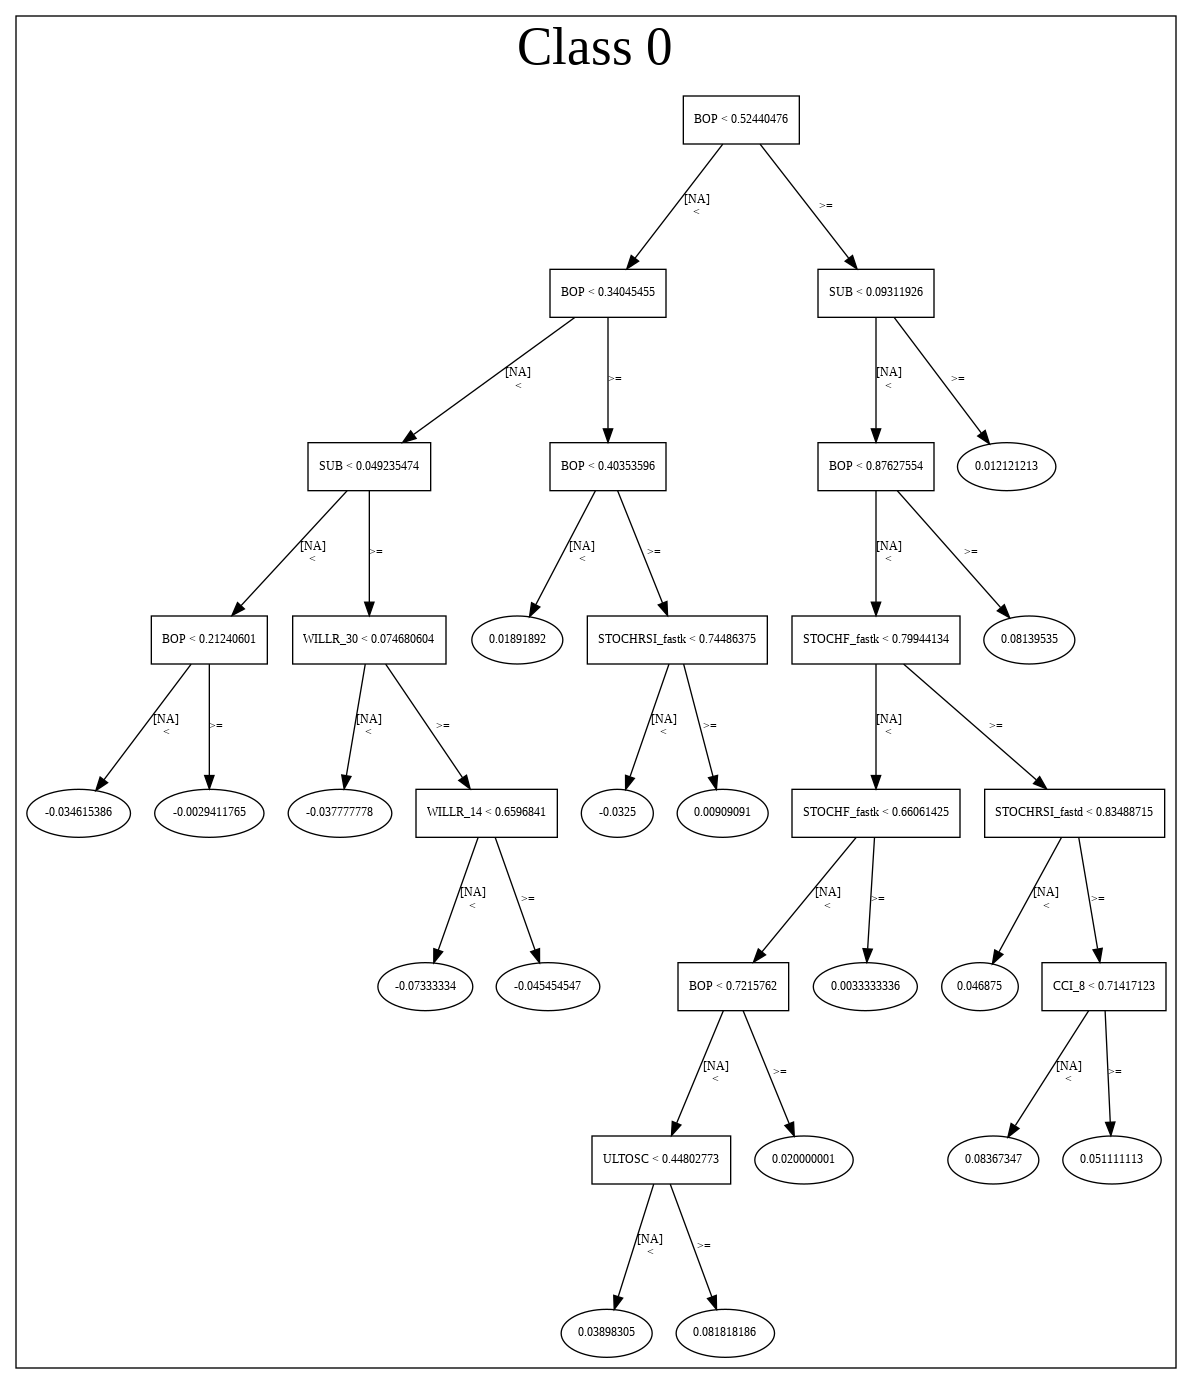

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_2_AutoML_20190905_215857',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_2_AutoML_20190905_215857',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_8e55',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_90_sid_8e55',
   'type

['BOP',
 'STOCHF_fastk',
 'SUB',
 'ULTOSC',
 'STOCHRSI_fastk',
 'DIV',
 'STOCHRSI_fastd',
 'CCI_12',
 'CCI_8',
 'WILLR_8',
 'ADOSC',
 'TRANGE',
 'CCI_14',
 'WILLR_24',
 'MOM_8',
 'WILLR_14',
 'CMO_12',
 'WILLR_20',
 'CMO_14',
 'CMO_8',
 'WILLR_30',
 'CDLCLOSINGMARUBOZU',
 'WILLR_12',
 'RSI_8',
 'CDLLONGLINE',
 'RSI_14',
 'RSI_12',
 'CDLBELTHOLD']

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

84

['BBANDS_middleband_14_6_2',
 'BBANDS_lowerband_14_6_3',
 'SAR_0.2',
 'BBANDS_upperband_20_0_2',
 'BBANDS_middleband_20_0_5',
 'BBANDS_lowerband_20_2_5',
 'BBANDS_lowerband_20_3_2',
 'BBANDS_middleband_20_3_4',
 'BBANDS_lowerband_20_5_5',
 'BBANDS_upperband_20_6_4',
 'BBANDS_lowerband_20_7_2',
 'BBANDS_lowerband_24_3_5',
 'BBANDS_upperband_30_0_3',
 'BOP',
 'aroondown_8',
 'CCI_8',
 'MFI_8',
 'MINUS_DI_8',
 'MINUS_DM_8',
 'PLUS_DI_8',
 'PLUS_DM_8',
 'ROC_8',
 'ROCR100_8',
 'WILLR_8',
 'aroondown_12',
 'CCI_12',
 'CMO_12',
 'MACDFIX_hist_12',
 'PLUS_DM_12',
 'ROCR100_12',
 'WILLR_12',
 'aroonup_14',
 'AROONOSC_14',
 'CCI_14',
 'CMO_14',
 'DX_14',
 'MACDFIX_signal_14',
 'ROC_14',
 'ROCP_14',
 'ROCR100_14',
 'aroonup_20',
 'CCI_20',
 'DX_20',
 'MACDFIX_hist_20',
 'MFI_20',
 'MINUS_DM_20',
 'PLUS_DI_20',
 'PLUS_DM_20',
 'WILLR_20',
 'CCI_24',
 'DX_24',
 'MOM_24',
 'ROCP_24',
 'ROCR100_24',
 'aroondown_30',
 'aroonup_30',
 'CCI_30',
 'PLUS_DI_30',
 'ROCR_30',
 'MACD',
 'STOCH_slowk',
 'STOC

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190905_220026_model_6  0.750000  0.591567              0.319098  0.450640  0.203076
1  DeepLearning_grid_1_AutoML_20190905_220026_model_8  0.748342  0.620122              0.287202  0.463417  0.214755
2  DeepLearning_grid_1_AutoML_20190905_220026_model_9  0.744761  0.605460              0.324801  0.456480  0.208374
3  DeepLearning_grid_1_AutoML_20190905_220026_model_5  0.724403  0.614749              0.313992  0.461197  0.212703
4  DeepLearning_grid_1_AutoML_20190905_220026_model_3  0.695225  0.974987              0.388064  0.533464  0.284584
5  DeepLearning_grid_1_AutoML_20190905_220026_model_7  0.692374  0.640652              0.335875  0.470393  0.221269
6  DeepLearning_grid_1_AutoML_20190905_220026_model_4  0.670093  0.737826              0.443037  0.500343  0.250343
7               DeepLearning_1_AutoML_20190905_220026  0.660080  0.943255              0.400066  0.548218  0.300543
8  DeepLearning_grid_1_AutoML_20190905_220026_model_2  0.629178  0.995373              0.433488  0.536402  0.287727
9  DeepLearning_grid_1_AutoML_20190905_220026_model_1  0.623408  0.974481              0.438263  0.547953  0.300253

variable  relative_importance  scaled_importance  percentage
0                       BOP             1.000000           1.000000    0.037194
1        CDLCLOSINGMARUBOZU             0.777047           0.777047    0.028902
2                    TRANGE             0.571295           0.571295    0.021249
3                 CORREL_14             0.407555           0.407555    0.015159
4            STOCHRSI_fastk             0.396293           0.396293    0.014740
..                      ...                  ...                ...         ...
79                   ATR_14             0.279423           0.279423    0.010393
80                   TSF_12             0.278925           0.278925    0.010374
81  BBANDS_lowerband_24_3_5             0.278869           0.278869    0.010372
82  BBANDS_upperband_30_0_3             0.278296           0.278296    0.010351
83  BBANDS_lowerband_20_2_5             0.274629           0.274629    0.010215

[84 rows x 4 columns]

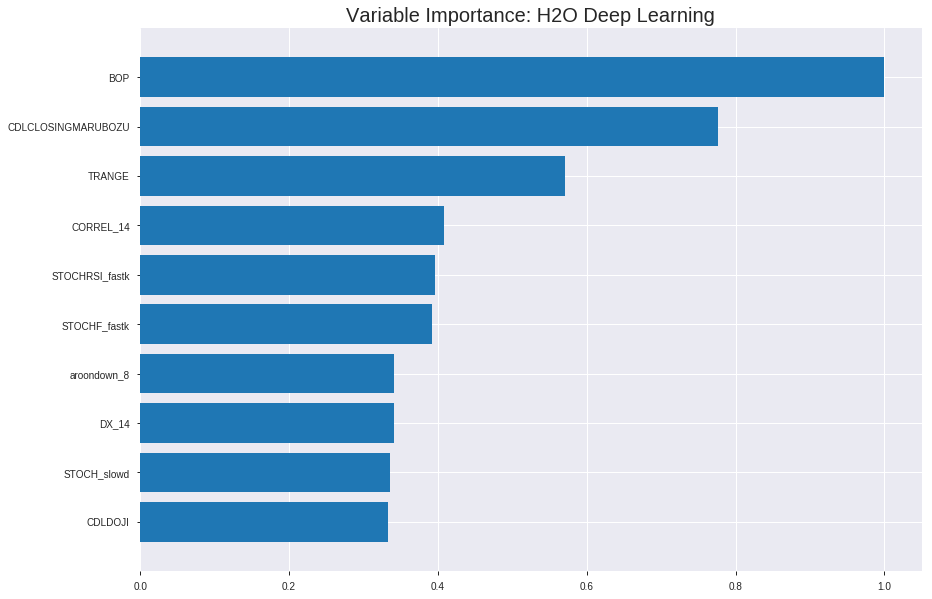

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190905_220026_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1915261476850203
RMSE: 0.43763700447405074
LogLoss: 0.5633114663551467
Mean Per-Class Error: 0.29314077227120705
AUC: 0.7793520489172663
pr_auc: 0.7818793161413556
Gini: 0.5587040978345326
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4475849522522516: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      442  383   0.4642   (383.0/825.0)
1      115  782   0.1282   (115.0/897.0)
Total  557  1165  0.2892   (498.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.447585     0.758487  241
max f2                       0.198974     0.859557  343
max f0point5                 0.580255     0.720218  166
max accuracy                 0.470119     0.712544  230
max precision                0.970997     1         0
max recall                   0.0850652    1         387
max specificity              0.970997     1         0
max absolute_mcc             0.447585     0.435227  241
max min_per_class_accuracy   0.549573     0.695758  185
max mean_per_class_accuracy  0.470119     0.706859  230

Gains/Lift Table: Avg response rate: 52.09 %, avg score: 52.60 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.93279            1.91973   1.91973            1                0.943381  1                           0.943381            0.0200669       0.0200669                  91.9732   91.9732
    2        0.0203252                   0.921705           1.80681   1.86488            0.941176         0.928544  0.971429                    0.936175            0.0178372       0.0379041                  80.6807   86.4883
    3        0.0301974                   0.910319           1.91973   1.88281            1                0.915522  0.980769                    0.929423            0.0189521       0.0568562                  91.9732   88.2815
    4        0.0400697                   0.895916           1.80681   1.86409            0.941176         0.903646  0.971014                    0.923072            0.0178372       0.0746934                  80.6807   86.4088
    5        0.0505226                   0.887007           1.70643   1.83147            0.888889         0.891958  0.954023                    0.916635            0.0178372       0.0925307                  70.6429   83.1469
    6        0.100465                    0.793473           1.49561   1.66451            0.77907          0.84035   0.867052                    0.878713            0.0746934       0.167224                   49.5606   66.4508
    7        0.150407                    0.738631           1.60722   1.64548            0.837209         0.762988  0.857143                    0.840287            0.0802676       0.247492                   60.7218   64.5485
    8        0.200348                    0.697787           1.49561   1.60812            0.77907          0.720403  0.837681                    0.810403            0.0746934       0.322185                   49.5606   60.8124
    9        0.300232                    0.63825            1.36167   1.52613            0.709302         0.666024  0.794971                    0.762369            0.136009        0.458194                   36.1671   52.6132
    10       0.400116                    0.593263           1.27238   1.46279            0.662791         0.614392  0.761974                    0.725429            0.12709         0.585284                   27.2381   46.2786
    11       0.5                         0.553251           1.04916   1.38016            0.546512         0.573411  0.718931                    0.695061            0.104794        0.690078                   4.91561   38.0156
    12       0.599884                    0.501146           1.00451   1.31761            0.523256         0.528878  0.68635                     0.66739             0.100334        0.790412                   0.451116  31.7609
    13       0.699768                    0.431222           0.926383  1.26177            0.482558         0.465366  0.657261                    0.638554            0.0925307       0.882943                   -7.36175  26.1766
    14       0.799652                    0.333947           0.63619   1.18363            0.331395         0.381618  0.616558                    0.60646             0.0635452       0.946488                   -36.381   18.3626
    15       0.899535                    0.204797           0.35716   1.09186            0.186047         0.270863  0.568754                    0.569196            0.0356745       0.982163                   -64.284   9.18556
    16       1                           0.0350435          0.177548  1                  0.0924855        0.138818  0.520906                    0.525958         



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.20399942875238256
RMSE: 0.4516629592432642
LogLoss: 0.5943507573419878
Mean Per-Class Error: 0.2905906354182216
AUC: 0.74001924001924
pr_auc: 0.7340124437610822
Gini: 0.48003848003848004
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43900039365704174: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      130  101  0.4372   (101.0/231.0)
1      41   220  0.1571   (41.0/261.0)
Total  171  321  0.2886   (142.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.439        0.756014  251
max f2                       0.209075     0.861838  356
max f0point5                 0.478563     0.720137  233
max accuracy                 0.478563     0.715447  233
max precision                0.972147     1         0
max recall                   0.0890893    1         397
max specificity              0.972147     1         0
max absolute_mcc             0.473285     0.429224  235
max min_per_class_accuracy   0.553158     0.689655  190
max mean_per_class_accuracy  0.478563     0.709409  233

Gains/Lift Table: Avg response rate: 53.05 %, avg score: 52.03 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.92494            1.88506   1.88506            1                0.946073  1                           0.946073            0.0191571       0.0191571                  88.5057   88.5057
    2        0.0203252                   0.903906           1.88506   1.88506            1                0.914679  1                           0.930376            0.0191571       0.0383142                  88.5057   88.5057
    3        0.0304878                   0.872431           1.50805   1.75939            0.8              0.888096  0.933333                    0.916283            0.0153257       0.0536398                  50.8046   75.9387
    4        0.0406504                   0.854335           0.754023  1.50805            0.4              0.862647  0.8                         0.902874            0.00766284      0.0613027                  -24.5977  50.8046
    5        0.050813                    0.83878            1.88506   1.58345            1                0.845357  0.84                        0.89137             0.0191571       0.0804598                  88.5057   58.3448
    6        0.101626                    0.757083           1.58345   1.58345            0.84             0.79822   0.84                        0.844795            0.0804598       0.16092                    58.3448   58.3448
    7        0.150407                    0.704886           1.17816   1.452              0.625            0.732394  0.77027                     0.808341            0.0574713       0.218391                   17.8161   45.2004
    8        0.20122                     0.67483            1.28184   1.40903            0.68             0.689561  0.747475                    0.778346            0.0651341       0.283525                   28.1839   40.9033
    9        0.300813                    0.634726           1.19259   1.33737            0.632653         0.653168  0.709459                    0.736902            0.118774        0.402299                   19.2587   33.7372
    10       0.400407                    0.595928           1.50035   1.37791            0.795918         0.614564  0.730964                    0.706472            0.149425        0.551724                   50.0352   37.791
    11       0.5                         0.559394           1.26953   1.35632            0.673469         0.576382  0.719512                    0.68056             0.126437        0.678161                   26.9529   35.6322
    12       0.599593                    0.487899           1.11565   1.31635            0.591837         0.526961  0.698305                    0.655047            0.111111        0.789272                   11.5646   31.6345
    13       0.699187                    0.41425            0.69247   1.22748            0.367347         0.444256  0.651163                    0.625022            0.0689655       0.858238                   -30.753   22.7479
    14       0.79878                     0.337229           0.654     1.15598            0.346939         0.385739  0.613232                    0.595187            0.0651341       0.923372                   -34.6     15.5977
    15       0.898374                    0.219189           0.538588  1.08753            0.285714         0.290589  0.576923                    0.56142             0.0536398       0.977011                   -46.1412  8.75332
    16       1                           0.0205116          0.226207  1                  0.12             0.156854  0.530488                    0.520305          


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-05 22:05:22  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-05 22:05:25  2 min 40.246 sec  854 obs/sec       1.17886   1             2030       0.522716         0.890751            -0.0948437     0.671298        0.671708           1.70643          0.424506                         0.576132           1.10601               -0.332666        0.618268          0.648067             1.88506            0.424797
    2019-09-05 22:05:34  2 min 49.481 sec  1535 obs/sec      9.60976   8             16548      0.446337         0.583058            0.201736       0.768561        0.767394           1.81308          0.324623                         0.457745           0.606813              0.158752         0.739911          0.730178             1.88506            0.308943
    2019-09-05 22:05:43  2 min 58.196 sec  1883 obs/sec      20.482    17            35270      0.437637         0.563311            0.232554       0.779352        0.781879           1.91973          0.289199                         0.451663           0.594351              0.180957         0.740019          0.734012             1.88506            0.288618
    2019-09-05 22:05:51  3 min  6.630 sec  2042 obs/sec      31.2787   26            53862      0.426899         0.540399            0.269753       0.804682        0.809021           1.91973          0.286295                         0.453673           0.598663              0.173652         0.737979          0.735543             1.88506            0.29065
    2019-09-05 22:05:59  3 min 14.838 sec  2144 obs/sec      42.1005   35            72497      0.422743         0.530372            0.2839         0.813271        0.819428           1.91973          0.29036                          0.455525           0.603507              0.166891         0.74288           0.738211             1.88506            0.288618
    2019-09-05 22:06:07  3 min 22.882 sec  2217 obs/sec      52.8868   44            91071      0.414635         0.513015            0.311108       0.82672         0.832697           1.91973          0.275261                         0.469068           0.636107              0.116616         0.718955          0.735242             1.88506            0.339431
    2019-09-05 22:06:15  3 min 30.851 sec  2273 obs/sec      63.6963   53            109685     0.404025         0.49031             0.345913       0.842393        0.847508           1.91973          0.246806                         0.467389           0.632614              0.12293          0.725614          0.72744              1.88506            0.310976
    2019-09-05 22:06:16  3 min 31.659 sec  2272 obs/sec      63.6963   53            109685     0.437637         0.563311            0.232554       0.779352        0.781879           1.91973          0.289199                         0.451663           0.594351              0.180957         0.740019          0.734012             1.88506            0.288618

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  --------------------
BOP                      1.0                    1.0                  0.03719442489153039
CDLCLOSINGMARUBOZU       0.7770470976829529     0.7770470976829529   0.028901819911950268
TRANGE                   0.5712950825691223     0.5712950825691223   0.02124899203951787
CORREL_14                0.40755462646484375    0.40755462646484375  0.015158759943242353
STOCHRSI_fastk           0.39629343152046204    0.39629343152046204  0.014739906273694666
---                      ---                    ---                  ---
ATR_14                   0.27942320704460144    0.27942320704460144  0.010392985487370972
TSF_12                   0.2789246737957001     0.2789246737957001   0.01037444282988878
BBANDS_lowerband_24_3_5  0.27886924147605896    0.27886924147605896  0.010372381056639325
BBANDS_upperband_30_0_3  0.27829623222351074    0.27829623222351074  0.010351068307033268
BBANDS_lowerband_20_2_5  0.27462905645370483    0.27462905645370483  0.010214669813299182


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7032520325203252)

('F1', 0.7634069400630915)

('auc', 0.75)

('logloss', 0.5915672056107755)

('mean_per_class_error', 0.3044429708222811)

('rmse', 0.4506397350040413)

('mse', 0.20307617076451256)

deeplearning prediction progress: |███████████████████████████████████████| 100%


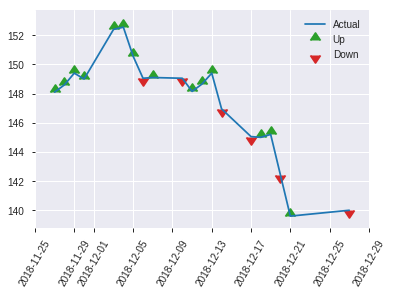


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.20307617076451256
RMSE: 0.4506397350040413
LogLoss: 0.5915672056107755
Mean Per-Class Error: 0.3044429708222811
AUC: 0.75
pr_auc: 0.7477020639481451
Gini: 0.5
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3757015710725815: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      50   66   0.569    (66.0/116.0)
1      9    121  0.0692   (9.0/130.0)
Total  59   187  0.3049   (75.0/246.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.375702     0.763407  186
max f2                       0.241349     0.867209  217
max f0point5                 0.441634     0.704961  158
max accuracy                 0.441634     0.703252  158
max precision                0.880562     1         0
max recall                   0.143185     1         240
max specificity              0.880562     1         0
max absolute_mcc             0.375702     0.422987  186
max min_per_class_accuracy   0.535586     0.663793  125
max mean_per_class_accuracy  0.441634     0.695557  158

Gains/Lift Table: Avg response rate: 52.85 %, avg score: 49.58 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121951                   0.860418           1.89231   1.89231            1                0.874794  1                           0.874794            0.0230769       0.0230769                  89.2308   89.2308
    2        0.0203252                   0.824819           1.89231   1.89231            1                0.845497  1                           0.863075            0.0153846       0.0384615                  89.2308   89.2308
    3        0.0325203                   0.804393           1.89231   1.89231            1                0.816428  1                           0.845582            0.0230769       0.0615385                  89.2308   89.2308
    4        0.0406504                   0.773628           0.946154  1.70308            0.5              0.785726  0.9                         0.833611            0.00769231      0.0692308                  -5.38462  70.3077
    5        0.0528455                   0.746555           1.89231   1.74675            1                0.765036  0.923077                    0.817786            0.0230769       0.0923077                  89.2308   74.6746
    6        0.101626                    0.681831           1.57692   1.66523            0.833333         0.6906    0.88                        0.756737            0.0769231       0.169231                   57.6923   66.5231
    7        0.150407                    0.658608           1.26154   1.5343             0.666667         0.668793  0.810811                    0.728215            0.0615385       0.230769                   26.1538   53.4304
    8        0.203252                    0.637519           1.31006   1.476              0.692308         0.648186  0.78                        0.707407            0.0692308       0.3                        31.0059   47.6
    9        0.300813                    0.608508           1.18269   1.38087            0.625            0.62098   0.72973                     0.679377            0.115385        0.415385                   18.2692   38.0873
    10       0.402439                    0.566188           1.51385   1.41445            0.8              0.588206  0.747475                    0.656354            0.153846        0.569231                   51.3846   41.4452
    11       0.5                         0.538151           0.946154  1.32308            0.5              0.549237  0.699187                    0.635453            0.0923077       0.661538                   -5.38462  32.3077
    12       0.601626                    0.469339           0.984     1.2658             0.52             0.511094  0.668919                    0.614446            0.1             0.761538                   -1.6      26.58
    13       0.699187                    0.408255           1.025     1.2322             0.541667         0.438397  0.651163                    0.589881            0.1             0.861538                   2.5       23.22
    14       0.800813                    0.337883           0.756923  1.17189            0.4              0.377922  0.619289                    0.562983            0.0769231       0.938462                   -24.3077  17.1886
    15       0.898374                    0.231128           0.473077  1.096              0.25             0.278301  0.579186                    0.532067            0.0461538       0.984615                   -52.6923  9.59972
    16       1                           0.0906505          0.151385  1                  0.08             0.174767  0.528455                    0.495756            0.01

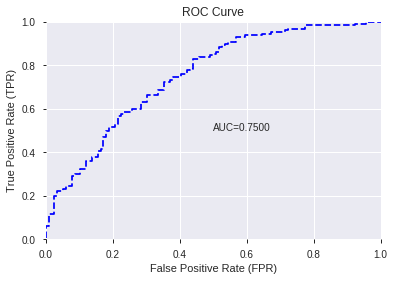

This function is available for GLM models only


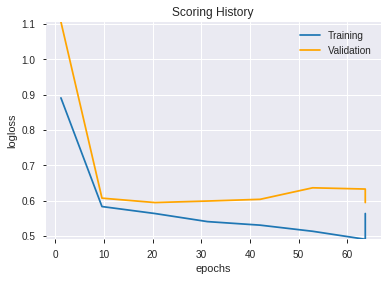

--2019-09-05 22:11:11--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.131.51
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.131.51|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


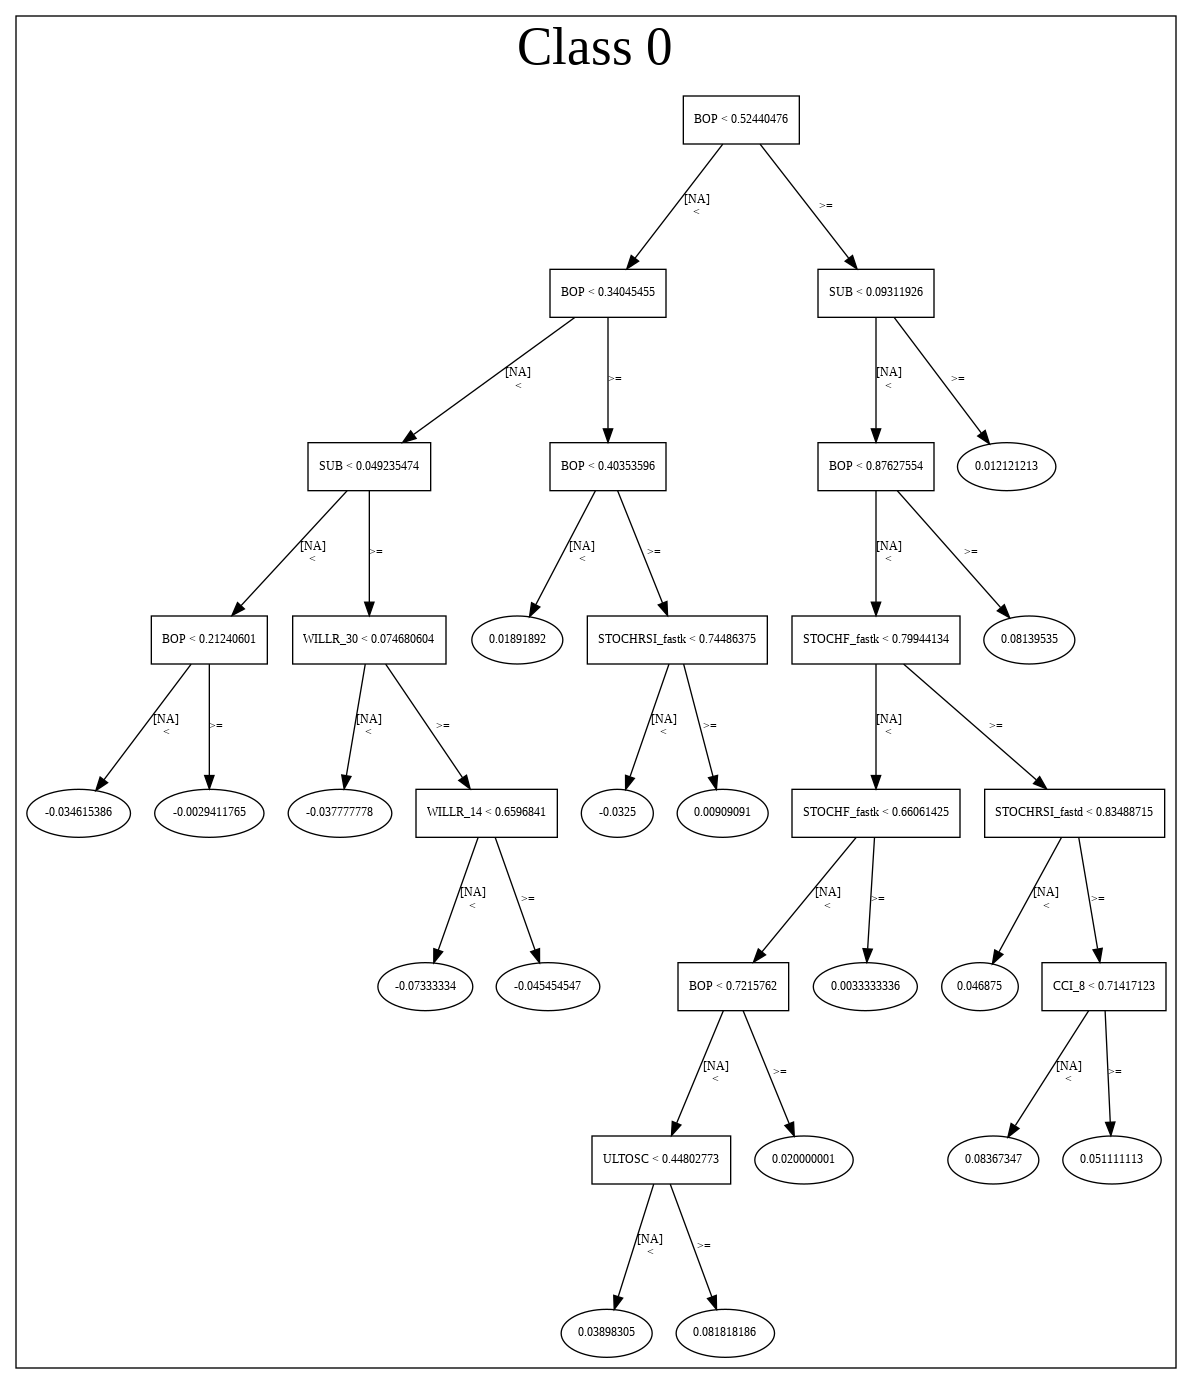

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190905_220026_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190905_220026_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_8e55',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'TRANGE',
 'CORREL_14',
 'STOCHRSI_fastk',
 'STOCHF_fastk',
 'aroondown_8',
 'DX_14',
 'STOCH_slowd',
 'CDLDOJI',
 'WILLR_20',
 'STOCH_slowk',
 'CORREL_8',
 'WILLR_8',
 'aroondown_30',
 'BETA_12',
 'CCI_14',
 'DX_24',
 'ADOSC',
 'aroonup_14',
 'AROONOSC_14',
 'DX_20',
 'aroondown_12',
 'ROCR100_24',
 'aroonup_30',
 'ROCR_30',
 'CDLHIGHWAVE',
 'ROCP_14',
 'BETA_8',
 'MFI_20',
 'AVGPRICE',
 'WILLR_12',
 'MACDFIX_signal_14',
 'MFI_8',
 'aroonup_20',
 'VAR_8',
 'ATR_12',
 'CCI_12',
 'PLUS_DM_8',
 'PLUS_DM_20',
 'MINUS_DM_8',
 'LINEARREG_ANGLE_8',
 'ROCR100_14',
 'ATR_24',
 'BBANDS_lowerband_20_3_2',
 'PLUS_DI_8',
 'PLUS_DI_20',
 'LINEARREG_INTERCEPT_12',
 'CCI_20',
 'PLUS_DM_12',
 'PLUS_DI_30',
 'MACDFIX_hist_20',
 'LINEARREG_SLOPE_12',
 'ROCR100_8',
 'BBANDS_middleband_14_6_2',
 'MACDFIX_hist_12',
 'BBANDS_lowerband_20_7_2',
 'ROC_14',
 'ROCP_24',
 'MINUS_DI_8',
 'CCI_8',
 'LINEARREG_SLOPE_8',
 'MINUS_DM_20',
 'CCI_24',
 'BBANDS_middleband_20_0_5',
 'BBANDS

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190905_221119_model_1  0.748806  0.615643              0.318634  0.459767  0.211386

variable  relative_importance  scaled_importance  percentage
0                       BOP             0.557018           1.000000    0.145788
1                    TRANGE             0.255915           0.459437    0.066980
2        CDLCLOSINGMARUBOZU             0.219557           0.394165    0.057465
3              STOCHF_fastk             0.121256           0.217688    0.031736
4            STOCHRSI_fastk             0.113543           0.203841    0.029718
..                      ...                  ...                ...         ...
79               PLUS_DM_20             0.001950           0.003500    0.000510
80             aroondown_12             0.001923           0.003452    0.000503
81  BBANDS_lowerband_24_3_5             0.001748           0.003139    0.000458
82               ROCR100_24             0.001133           0.002033    0.000296
83                  ROCP_24             0.001076           0.001932    0.000282

[84 rows x 4 columns]

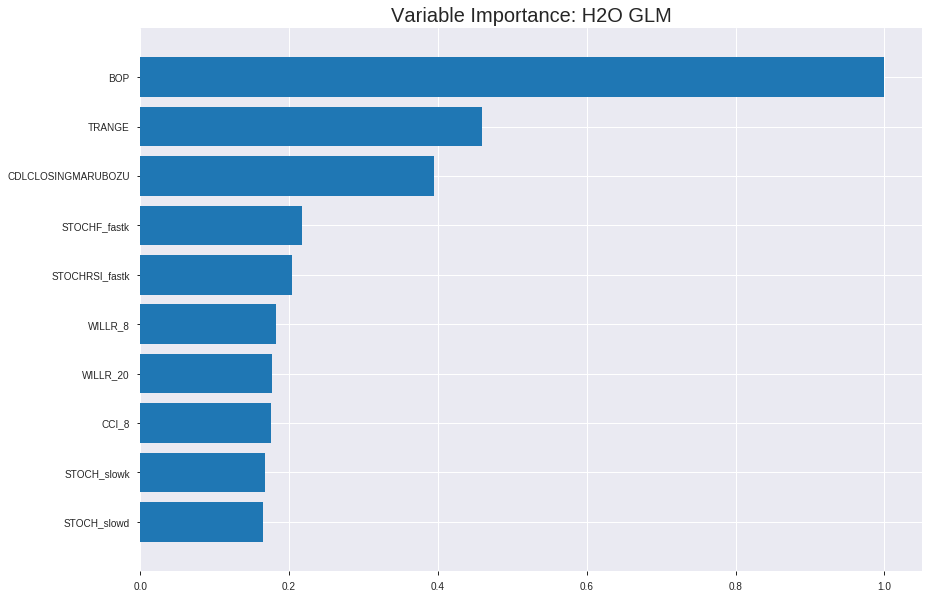

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190905_221119_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19747819391458935
RMSE: 0.44438518642568337
LogLoss: 0.5795767641643724
Null degrees of freedom: 1721
Residual degrees of freedom: 1637
Null deviance: 2384.1875591118605
Residual deviance: 1996.0623757820986
AIC: 2166.0623757820986
AUC: 0.7644863349211175
pr_auc: 0.760432612595384
Gini: 0.528972669842235
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3850436278151919: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      380  445   0.5394   (445.0/825.0)
1      100  797   0.1115   (100.0/897.0)
Total  480  1242  0.3165   (545.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.385044     0.745208  268
max f2                       0.243215     0.853635  340
max f0point5                 0.543562     0.722469  180
max accuracy                 0.516379     0.708479  197
max precision                0.90707      1         0
max recall                   0.110658     1         389
max specificity              0.90707      1         0
max absolute_mcc             0.516379     0.415387  197
max min_per_class_accuracy   0.533198     0.703456  186
max mean_per_class_accuracy  0.516379     0.707336  197

Gains/Lift Table: Avg response rate: 52.09 %, avg score: 52.09 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.878411           1.81308   1.81308            0.944444         0.889982  0.944444                    0.889982            0.0189521       0.0189521                  81.3081   81.3081
    2        0.0203252                   0.867371           1.80681   1.81003            0.941176         0.874401  0.942857                    0.882414            0.0178372       0.0367893                  80.6807   81.0033
    3        0.0301974                   0.858567           1.80681   1.80898            0.941176         0.863891  0.942308                    0.876359            0.0178372       0.0546265                  80.6807   80.8979
    4        0.0400697                   0.848048           1.58096   1.7528             0.823529         0.8537    0.913043                    0.870776            0.0156076       0.0702341                  58.0956   75.2799
    5        0.0505226                   0.838774           1.49313   1.69907            0.777778         0.84249   0.885057                    0.864924            0.0156076       0.0858417                  49.3125   69.9074
    6        0.100465                    0.776859           1.65186   1.6756             0.860465         0.80875   0.872832                    0.836999            0.0824972       0.168339                   65.1863   67.5605
    7        0.150407                    0.731926           1.33935   1.56395            0.697674         0.751049  0.814672                    0.80846             0.0668896       0.235229                   33.9348   56.3952
    8        0.200348                    0.703699           1.62954   1.5803             0.848837         0.71696   0.823188                    0.785651            0.0813824       0.316611                   62.954    58.0301
    9        0.300232                    0.657105           1.27238   1.47786            0.662791         0.680492  0.769826                    0.750666            0.12709         0.443701                   27.2381   47.786
    10       0.400116                    0.603384           1.27238   1.42656            0.662791         0.632864  0.743106                    0.721258            0.12709         0.570792                   27.2381   42.6565
    11       0.5                         0.538072           1.25006   1.3913             0.651163         0.571868  0.724739                    0.691415            0.124861        0.695652                   25.0058   39.1304
    12       0.599884                    0.471726           0.892899  1.30832            0.465116         0.505725  0.68151                     0.660497            0.0891862       0.784838                   -10.7101  30.8317
    13       0.699768                    0.398653           0.837093  1.24106            0.436047         0.435468  0.646473                    0.628376            0.083612        0.86845                    -16.2907  24.1055
    14       0.799652                    0.3232             0.602707  1.16132            0.313953         0.361214  0.604938                    0.595005            0.0602007       0.928651                   -39.7293  16.132
    15       0.899535                    0.236433           0.491094  1.0869             0.255814         0.284828  0.566172                    0.560563            0.0490524       0.977703                   -50.8906  8.68982
    16       1                           0.0640971          0.221934  1                  0.115607         0.165823  0.520906                    0.520906           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2031846149940912
RMSE: 0.450760041478935
LogLoss: 0.5966592188647912
Null degrees of freedom: 491
Residual degrees of freedom: 407
Null deviance: 680.4075335465611
Residual deviance: 587.1126713629545
AIC: 757.1126713629545
AUC: 0.7519779071503209
pr_auc: 0.7361960582682222
Gini: 0.5039558143006417
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3783995222945604: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      123  108  0.4675   (108.0/231.0)
1      34   227  0.1303   (34.0/261.0)
Total  157  335  0.2886   (142.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.3784       0.761745  266
max f2                       0.218967     0.867209  344
max f0point5                 0.414554     0.725319  243
max accuracy                 0.414554     0.723577  243
max precision                0.925199     1         0
max recall                   0.00412388   1         399
max specificity              0.925199     1         0
max absolute_mcc             0.414554     0.446794  243
max min_per_class_accuracy   0.498743     0.679654  199
max mean_per_class_accuracy  0.414554     0.716823  243

Gains/Lift Table: Avg response rate: 53.05 %, avg score: 47.78 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.859491           1.88506   1.88506            1                0.878296  1                           0.878296            0.0191571       0.0191571                  88.5057   88.5057
    2        0.0203252                   0.820519           1.50805   1.69655            0.8              0.837093  0.9                         0.857694            0.0153257       0.0344828                  50.8046   69.6552
    3        0.0304878                   0.808784           1.13103   1.50805            0.6              0.813994  0.8                         0.843127            0.0114943       0.045977                   13.1034   50.8046
    4        0.0406504                   0.79657            1.88506   1.6023             1                0.80307   0.85                        0.833113            0.0191571       0.0651341                  88.5057   60.2299
    5        0.050813                    0.773944           1.88506   1.65885            1                0.78901   0.88                        0.824292            0.0191571       0.0842912                  88.5057   65.8851
    6        0.101626                    0.721881           1.28184   1.47034            0.68             0.742895  0.78                        0.783594            0.0651341       0.149425                   28.1839   47.0345
    7        0.150407                    0.679458           1.49234   1.47748            0.791667         0.69588   0.783784                    0.755146            0.0727969       0.222222                   49.2337   47.7477
    8        0.20122                     0.651408           1.28184   1.42807            0.68             0.666409  0.757576                    0.732738            0.0651341       0.287356                   28.1839   42.8074
    9        0.300813                    0.601652           1.42341   1.42653            0.755102         0.626356  0.756757                    0.697517            0.141762        0.429119                   42.3411   42.653
    10       0.400407                    0.558652           1.11565   1.3492             0.591837         0.57974   0.715736                    0.668222            0.111111        0.54023                    11.5646   34.9204
    11       0.5                         0.504994           1.308     1.341              0.693878         0.536315  0.711382                    0.641948            0.130268        0.670498                   30.7999   34.0996
    12       0.599593                    0.433609           1.26953   1.32913            0.673469         0.468952  0.705085                    0.613213            0.126437        0.796935                   26.9529   32.9125
    13       0.699187                    0.365352           0.769411  1.2494             0.408163         0.397649  0.662791                    0.582508            0.0766284       0.873563                   -23.0589  24.9399
    14       0.79878                     0.293991           0.615529  1.17037            0.326531         0.3284    0.620865                    0.550825            0.0613027       0.934866                   -38.4471  17.0366
    15       0.898374                    0.190592           0.500117  1.09606            0.265306         0.245529  0.581448                    0.51698             0.0498084       0.984674                   -49.9883  9.60628
    16       1                           0.00412388         0.150805  1                  0.08             0.131862  0.530488                    0.477842          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-09-05 22:11:20  0.000 sec   2            21        85            1.36907           1.37044
    2019-09-05 22:11:20  0.027 sec   4            13        85            1.36178           1.36439
    2019-09-05 22:11:20  0.048 sec   6            8.1       85            1.35178           1.35594
    2019-09-05 22:11:20  0.071 sec   8            5         85            1.33855           1.34453
    2019-09-05 22:11:20  0.091 sec   10           3.1       85            1.32166           1.32968
    2019-09-05 22:11:20  0.123 sec   12           1.9       85            1.30122           1.31136
    2019-09-05 22:11:20  0.145 sec   14           1.2       85            1.2781            1.29033
    2019-09-05 22:11:20  0.169 sec   16           0.75      85            1.25393           1.2681
    2019-09-05 22:11:20  0.189 sec   18           0.46      85            1.23047           1.24652
    2019-09-05 22:11:20  0.225 sec   20           0.29      85            1.2093            1.22736
    2019-09-05 22:11:20  0.253 sec   22           0.18      85            1.19142           1.21201
    2019-09-05 22:11:20  0.287 sec   24           0.11      85            1.17724           1.20124
    2019-09-05 22:11:20  0.307 sec   26           0.069     85            1.16666           1.19517
    2019-09-05 22:11:20  0.327 sec   28           0.043     85            1.15915           1.19332
    2019-09-05 22:11:20  0.353 sec   30           0.027     85            1.15398           1.1947
    2019-09-05 22:11:20  0.388 sec   32           0.017     85            1.15027           1.19826
    2019-09-05 22:11:20  0.414 sec   34           0.01      85            1.14745           1.20318
    2019-09-05 22:11:20  0.439 sec   36           0.0064    85            1.14504           1.20873
    2019-09-05 22:11:20  0.462 sec   38           0.004     85            1.14281           1.21464

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6951219512195121)

('F1', 0.7619047619047619)

('auc', 0.7488063660477453)

('logloss', 0.6156430867706886)

('mean_per_class_error', 0.3107427055702918)

('rmse', 0.4597671908702786)

('mse', 0.21138586980074722)

glm prediction progress: |████████████████████████████████████████████████| 100%


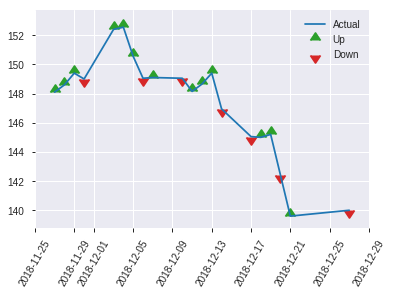


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.21138586980074722
RMSE: 0.4597671908702786
LogLoss: 0.6156430867706886
Null degrees of freedom: 245
Residual degrees of freedom: 161
Null deviance: 340.2874392490048
Residual deviance: 302.8963986911788
AIC: 472.8963986911788
AUC: 0.7488063660477453
pr_auc: 0.7530268690946837
Gini: 0.4976127320954906
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2822743371553244: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      51   65   0.5603   (65.0/116.0)
1      10   120  0.0769   (10.0/130.0)
Total  61   185  0.3049   (75.0/246.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.282274     0.761905  184
max f2                       0.213273     0.860656  211
max f0point5                 0.386401     0.701635  150
max accuracy                 0.386401     0.695122  150
max precision                0.837385     1         0
max recall                   0.0211084    1         245
max specificity              0.837385     1         0
max absolute_mcc             0.282274     0.419311  184
max min_per_class_accuracy   0.44936      0.655172  125
max mean_per_class_accuracy  0.386401     0.689257  150

Gains/Lift Table: Avg response rate: 52.85 %, avg score: 44.15 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121951                   0.823741           1.89231   1.89231            1                0.835054  1                           0.835054            0.0230769       0.0230769                  89.2308   89.2308
    2        0.0203252                   0.787258           1.89231   1.89231            1                0.800549  1                           0.821252            0.0153846       0.0384615                  89.2308   89.2308
    3        0.0325203                   0.779065           1.26154   1.65577            0.666667         0.783544  0.875                       0.807111            0.0153846       0.0538462                  26.1538   65.5769
    4        0.0406504                   0.770887           1.89231   1.70308            1                0.774028  0.9                         0.800495            0.0153846       0.0692308                  89.2308   70.3077
    5        0.0528455                   0.753548           1.89231   1.74675            1                0.765343  0.923077                    0.792383            0.0230769       0.0923077                  89.2308   74.6746
    6        0.101626                    0.6675             1.57692   1.66523            0.833333         0.701173  0.88                        0.748602            0.0769231       0.169231                   57.6923   66.5231
    7        0.150407                    0.642579           1.26154   1.5343             0.666667         0.654743  0.810811                    0.718161            0.0615385       0.230769                   26.1538   53.4304
    8        0.203252                    0.61763            1.45562   1.51385            0.769231         0.627512  0.8                         0.694593            0.0769231       0.307692                   45.5621   51.3846
    9        0.300813                    0.573842           1.49808   1.50873            0.791667         0.595137  0.797297                    0.662337            0.146154        0.453846                   49.8077   50.8732
    10       0.402439                    0.51068            0.832615  1.338              0.44             0.543633  0.707071                    0.632361            0.0846154       0.538462                   -16.7385  33.7995
    11       0.5                         0.452504           1.18269   1.30769            0.625            0.481391  0.691057                    0.602903            0.115385        0.653846                   18.2692   30.7692
    12       0.601626                    0.387898           1.21108   1.29137            0.64             0.419901  0.682432                    0.571991            0.123077        0.776923                   21.1077   29.1372
    13       0.699187                    0.311877           0.867308  1.2322             0.458333         0.356857  0.651163                    0.541972            0.0846154       0.861538                   -13.2692  23.22
    14       0.800813                    0.255949           0.756923  1.17189            0.4              0.281471  0.619289                    0.508914            0.0769231       0.938462                   -24.3077  17.1886
    15       0.898374                    0.170886           0.394231  1.08743            0.208333         0.220923  0.574661                    0.477639            0.0384615       0.976923                   -60.5769  8.74347
    16       1                           0.0211084          0.227077  1                  0.12             0.122339  0.528455                    0.441531           

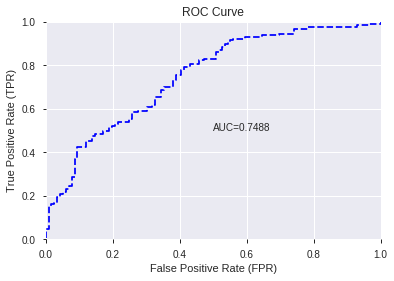

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


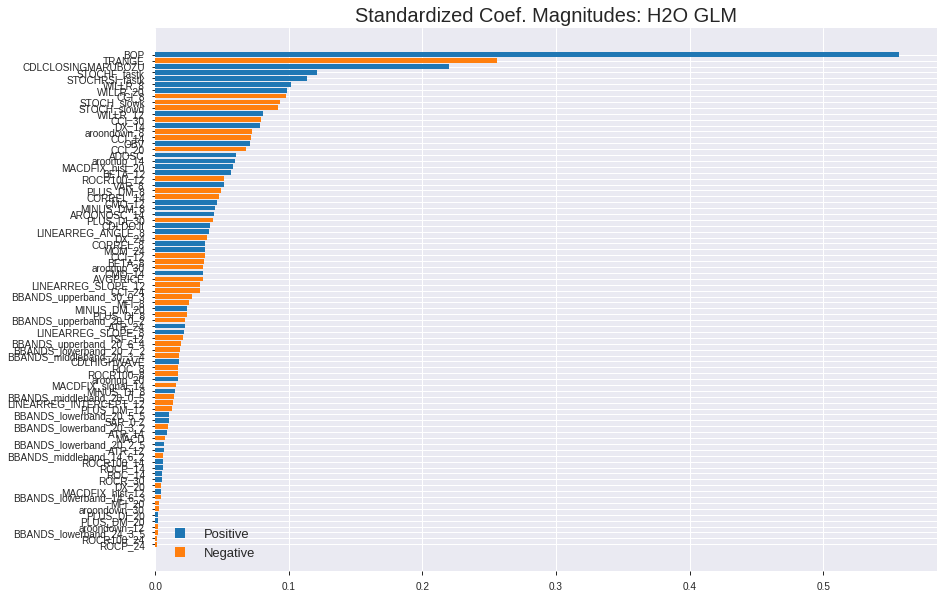

'log_likelihood'
--2019-09-05 22:11:25--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.170.251
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.170.251|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


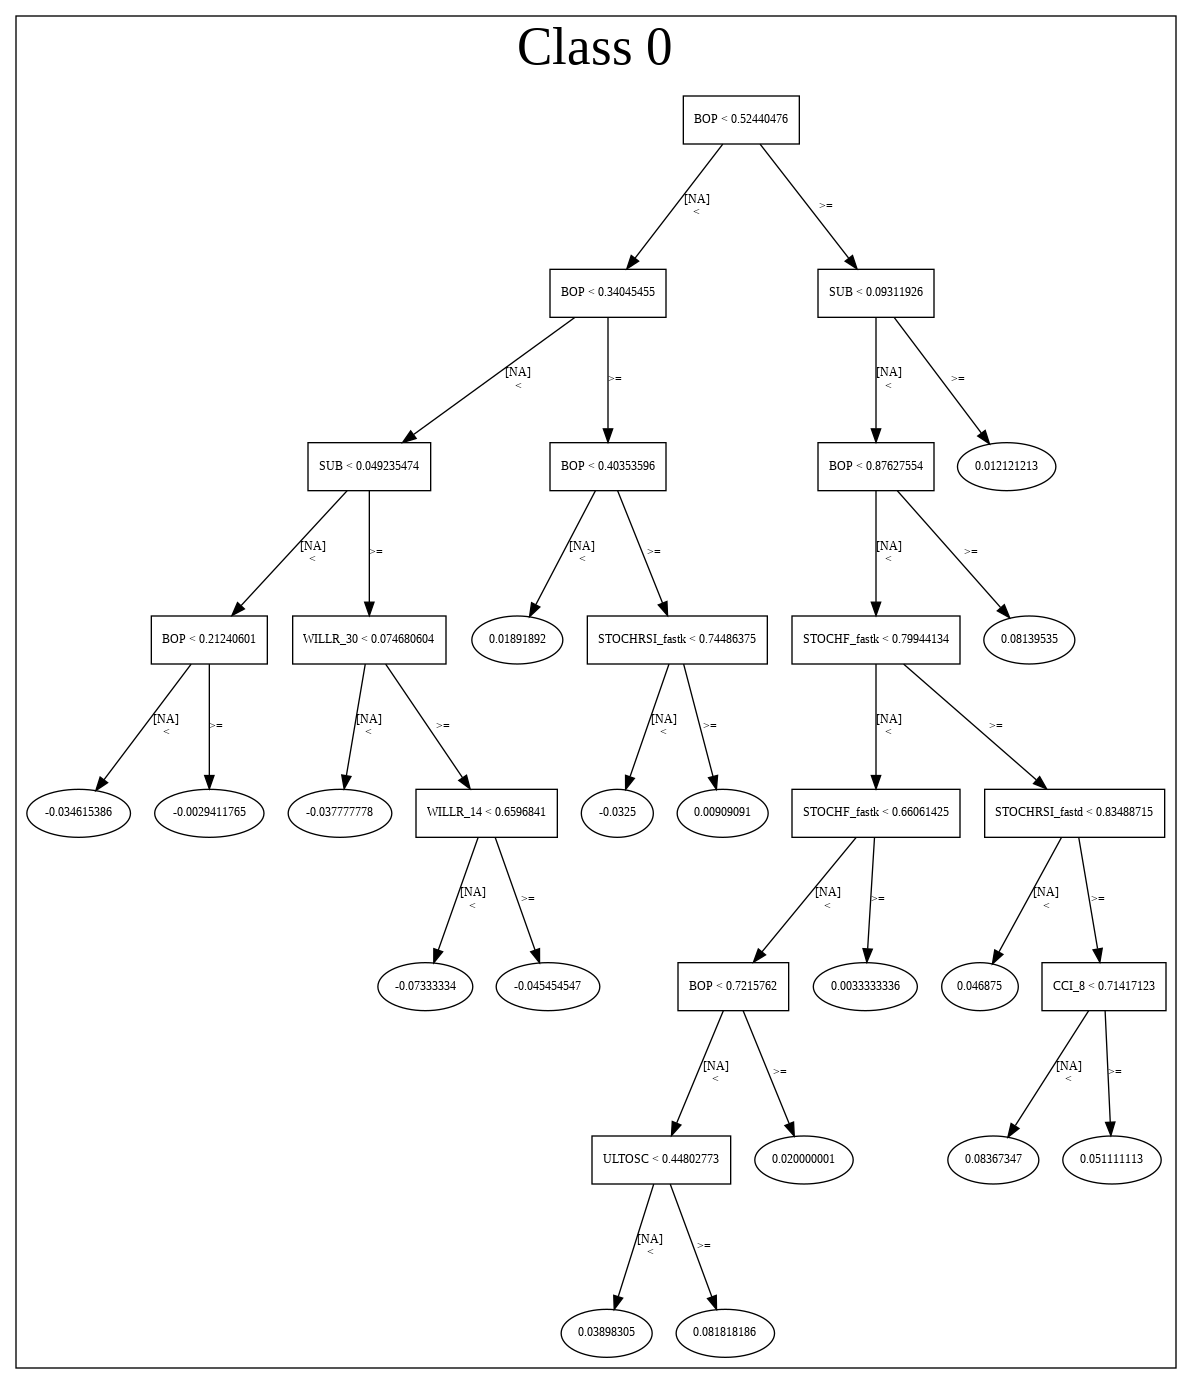

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190905_221119_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190905_221119_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_8e55',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['BOP',
 'TRANGE',
 'CDLCLOSINGMARUBOZU',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'WILLR_8',
 'WILLR_20',
 'CCI_8',
 'STOCH_slowk',
 'STOCH_slowd',
 'WILLR_12',
 'CCI_30',
 'DX_14',
 'aroondown_8',
 'CCI_14',
 'OBV',
 'CCI_20',
 'ADOSC',
 'aroonup_14',
 'MACDFIX_hist_20',
 'BETA_12',
 'ROCR100_12',
 'VAR_8',
 'PLUS_DM_8',
 'CORREL_14',
 'CMO_12',
 'MINUS_DM_8',
 'AROONOSC_14',
 'PLUS_DI_30',
 'CDLDOJI',
 'LINEARREG_ANGLE_8',
 'DX_24',
 'CORREL_8',
 'MOM_24',
 'CCI_12',
 'BETA_8',
 'aroonup_30',
 'CMO_14',
 'AVGPRICE',
 'LINEARREG_SLOPE_12',
 'CCI_24',
 'BBANDS_upperband_30_0_3',
 'MFI_8',
 'MINUS_DM_20',
 'PLUS_DI_8',
 'BBANDS_upperband_20_0_2',
 'ATR_24',
 'LINEARREG_SLOPE_8',
 'TSF_12',
 'BBANDS_upperband_20_6_4',
 'BBANDS_lowerband_20_7_2',
 'BBANDS_middleband_20_3_4',
 'CDLHIGHWAVE',
 'ROC_8',
 'ROCR100_8',
 'aroonup_20',
 'MACDFIX_signal_14',
 'MINUS_DI_8',
 'BBANDS_middleband_20_0_5',
 'LINEARREG_INTERCEPT_12',
 'PLUS_DM_12',
 'BBANDS_lowerband_20_5_5',
 'SAR_0.2',
 'BBANDS_lowerban

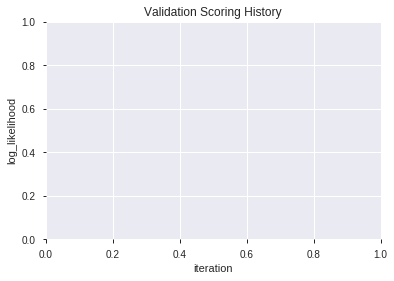

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_2_AutoML_20190905_221133  0.763263  0.606312              0.314324  0.458231  0.209976
1  XGBoost_grid_1_AutoML_20190905_221133_model_2  0.755637  0.615080              0.332958  0.462067  0.213506
2  XGBoost_grid_1_AutoML_20190905_221133_model_1  0.755504  0.599406              0.337732  0.455476  0.207458
3               XGBoost_3_AutoML_20190905_221133  0.751326  0.609093              0.302454  0.459863  0.211474
4  XGBoost_grid_1_AutoML_20190905_221133_model_7  0.749801  0.614652              0.341114  0.462629  0.214026
5  XGBoost_grid_1_AutoML_20190905_221133_model_6  0.748806  0.613526              0.319695  0.460709  0.212253
6  XGBoost_grid_1_AutoML_20190905_221133_model_5  0.747878  0.609692              0.368833  0.459519  0.211157
7  XGBoost_grid_1_AutoML_20190905_221133_model_3  0.747347  0.608291              0.305371  0.459389  0.211038
8  XGBoost_grid_1_AutoML_20190905_221133_model_4  0.738329  0.613241              0.321088  0.461404  0.212893
9               XGBoost_1_AutoML_20190905_221133  0.731698  0.618407              0.332162  0.464245  0.215523

variable  relative_importance  scaled_importance  percentage
0                       BOP          1969.338867           1.000000    0.279865
1                    TRANGE           327.427673           0.166263    0.046531
2              STOCHF_fastk           303.887695           0.154309    0.043186
3            STOCHRSI_fastk           169.609360           0.086125    0.024103
4        CDLCLOSINGMARUBOZU           141.038635           0.071617    0.020043
..                      ...                  ...                ...         ...
77              CDLHIGHWAVE            18.499231           0.009394    0.002629
78                  ROCP_14            17.664658           0.008970    0.002510
79             aroondown_12            15.357114           0.007798    0.002182
80  BBANDS_lowerband_20_7_2            12.523228           0.006359    0.001780
81              aroondown_8             5.061495           0.002570    0.000719

[82 rows x 4 columns]

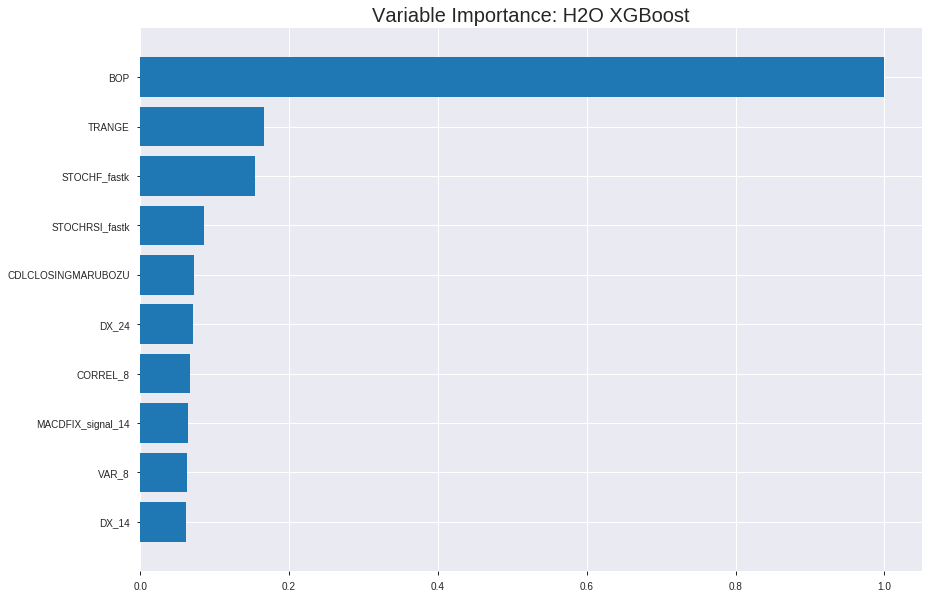

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_2_AutoML_20190905_221133


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.14731846055669182
RMSE: 0.3838208704027073
LogLoss: 0.4650309596698142
Mean Per-Class Error: 0.19336779162866113
AUC: 0.8955042059389886
pr_auc: 0.908990285150034
Gini: 0.7910084118779772
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5209645628929138: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      650  175  0.2121   (175.0/825.0)
1      158  739  0.1761   (158.0/897.0)
Total  808  914  0.1934   (333.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.520965     0.816124  195
max f2                       0.294466     0.886983  303
max f0point5                 0.643789     0.844464  131
max accuracy                 0.527226     0.80662   192
max precision                0.9101       1         0
max recall                   0.196384     1         352
max specificity              0.9101       1         0
max absolute_mcc             0.586019     0.616736  161
max min_per_class_accuracy   0.537725     0.804848  188
max mean_per_class_accuracy  0.586019     0.806632  161

Gains/Lift Table: Avg response rate: 52.09 %, avg score: 52.19 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.874223           1.91973    1.91973            1                0.892603  1                           0.892603            0.0200669       0.0200669                  91.9732   91.9732
    2        0.0203252                   0.863865           1.91973    1.91973            1                0.867868  1                           0.880589            0.0189521       0.039019                   91.9732   91.9732
    3        0.0301974                   0.85674            1.91973    1.91973            1                0.860324  1                           0.873964            0.0189521       0.057971                   91.9732   91.9732
    4        0.0400697                   0.846948           1.91973    1.91973            1                0.852119  1                           0.868582            0.0189521       0.0769231                  91.9732   91.9732
    5        0.0505226                   0.839359           1.91973    1.91973            1                0.842933  1                           0.863275            0.0200669       0.09699                    91.9732   91.9732
    6        0.100465                    0.807371           1.89741    1.90864            0.988372         0.822728  0.99422                     0.843119            0.0947603       0.19175                    89.741    90.8636
    7        0.150407                    0.779239           1.87509    1.8975             0.976744         0.793907  0.988417                    0.826778            0.0936455       0.285396                   87.5088   89.7496
    8        0.200348                    0.751594           1.89741    1.89747            0.988372         0.766544  0.988406                    0.811763            0.0947603       0.380156                   89.741    89.7475
    9        0.300232                    0.684969           1.68535    1.8269             0.877907         0.718118  0.951644                    0.780609            0.168339        0.548495                   68.5347   82.6902
    10       0.400116                    0.617876           1.33935    1.70519            0.697674         0.650597  0.888244                    0.748153            0.133779        0.682274                   33.9348   70.519
    11       0.5                         0.546391           1.06032    1.57637            0.552326         0.5814    0.821138                    0.714841            0.105909        0.788183                   6.03173   57.6366
    12       0.599884                    0.461599           0.859415   1.45699            0.447674         0.503763  0.758955                    0.679695            0.0858417       0.874025                   -14.0585  45.699
    13       0.699768                    0.36865            0.569223   1.33027            0.296512         0.413481  0.692946                    0.641696            0.0568562       0.930881                   -43.0777  33.0271
    14       0.799652                    0.28853            0.491094   1.22545            0.255814         0.329646  0.638344                    0.602718            0.0490524       0.979933                   -50.8906  22.545
    15       0.899535                    0.201909           0.189741   1.11045            0.0988372        0.243229  0.578438                    0.562801            0.0189521       0.998885                   -81.0259  11.0446
    16       1                           0.073767           0.0110967  1                  0.00578035       0.155804  0.520906                    0.



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.20649266137943123
RMSE: 0.4544146359652506
LogLoss: 0.5991202501733736
Mean Per-Class Error: 0.2872568044981838
AUC: 0.7328622845864224
pr_auc: 0.7250086221929367
Gini: 0.4657245691728449
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42367592453956604: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      139  92   0.3983   (92.0/231.0)
1      46   215  0.1762   (46.0/261.0)
Total  185  307  0.2805   (138.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.423676     0.757042  247
max f2                       0.173727     0.860927  375
max f0point5                 0.423676     0.721961  247
max accuracy                 0.423676     0.719512  247
max precision                0.857697     1         0
max recall                   0.157054     1         383
max specificity              0.857697     1         0
max absolute_mcc             0.423676     0.438386  247
max min_per_class_accuracy   0.521196     0.666667  200
max mean_per_class_accuracy  0.423676     0.712743  247

Gains/Lift Table: Avg response rate: 53.05 %, avg score: 48.83 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.828204           1.88506   1.88506            1                0.8361    1                           0.8361              0.0191571       0.0191571                  88.5057   88.5057
    2        0.0203252                   0.795716           1.88506   1.88506            1                0.811902  1                           0.824001            0.0191571       0.0383142                  88.5057   88.5057
    3        0.0304878                   0.786118           1.13103   1.63372            0.6              0.791734  0.866667                    0.813245            0.0114943       0.0498084                  13.1034   63.3716
    4        0.0406504                   0.770771           1.50805   1.6023             0.8              0.778435  0.85                        0.804543            0.0153257       0.0651341                  50.8046   60.2299
    5        0.050813                    0.762102           1.50805   1.58345            0.8              0.766986  0.84                        0.797031            0.0153257       0.0804598                  50.8046   58.3448
    6        0.101626                    0.719343           1.50805   1.54575            0.8              0.740185  0.82                        0.768608            0.0766284       0.157088                   50.8046   54.5747
    7        0.150407                    0.680927           1.17816   1.42653            0.625            0.69804   0.756757                    0.745721            0.0574713       0.214559                   17.8161   42.653
    8        0.20122                     0.654978           1.43264   1.42807            0.76             0.666471  0.757576                    0.725709            0.0727969       0.287356                   43.2644   42.8074
    9        0.300813                    0.623327           1.03871   1.29916            0.55102          0.639492  0.689189                    0.697164            0.103448        0.390805                   3.87051   29.9161
    10       0.400407                    0.580541           1.38494   1.3205             0.734694         0.604354  0.700508                    0.674079            0.137931        0.528736                   38.494    32.0497
    11       0.5                         0.526231           1.19259   1.29502            0.632653         0.552731  0.686992                    0.649908            0.118774        0.64751                    19.2587   29.5019
    12       0.599593                    0.444728           1.38494   1.30996            0.734694         0.484629  0.694915                    0.622455            0.137931        0.785441                   38.494    30.9955
    13       0.699187                    0.371243           0.769411  1.23296            0.408163         0.40581   0.65407                     0.591596            0.0766284       0.862069                   -23.0589  23.2959
    14       0.79878                     0.28334            0.807882  1.17996            0.428571         0.334551  0.625954                    0.559547            0.0804598       0.942529                   -19.2118  17.996
    15       0.898374                    0.202338           0.307764  1.08327            0.163265         0.247006  0.574661                    0.524899            0.0306513       0.97318                    -69.2236  8.32683
    16       1                           0.0924867          0.263908  1                  0.14             0.164356  0.530488                    0.488258           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-05 22:11:35  0.003 sec   0                  0.5              0.693147            0.5             0                  1                0.479094                         0.5                0.693147              0.5               0                    1                  0.469512
    2019-09-05 22:11:35  0.071 sec   5                  0.475729         0.645509            0.813518        0.81921            1.91973          0.279907                         0.484668           0.662794              0.730524          0.7083               1.88506            0.304878
    2019-09-05 22:11:35  0.127 sec   10                 0.457808         0.610982            0.8302          0.848302           1.91973          0.249129                         0.473371           0.640511              0.743618          0.734005             1.88506            0.300813
    2019-09-05 22:11:35  0.184 sec   15                 0.443369         0.583148            0.84175         0.860012           1.91973          0.254936                         0.467167           0.628009              0.744365          0.738358             1.88506            0.280488
    2019-09-05 22:11:35  0.247 sec   20                 0.432118         0.561073            0.847712        0.866109           1.91973          0.256678                         0.46145            0.616217              0.744406          0.742544             1.88506            0.280488
    2019-09-05 22:11:35  0.305 sec   25                 0.423348         0.543622            0.853473        0.870751           1.91973          0.247387                         0.458701           0.610155              0.739978          0.734302             1.88506            0.28252
    2019-09-05 22:11:35  0.364 sec   30                 0.415848         0.5286              0.859437        0.876527           1.91973          0.242741                         0.456918           0.606115              0.735922          0.728101             1.88506            0.280488
    2019-09-05 22:11:35  0.440 sec   35                 0.409863         0.516361            0.86424         0.880631           1.91973          0.237515                         0.455945           0.603435              0.735309          0.728767             1.88506            0.272358
    2019-09-05 22:11:35  0.506 sec   40                 0.403913         0.504368            0.870219        0.886707           1.91973          0.228804                         0.456276           0.603665              0.732954          0.725662             1.88506            0.278455
    2019-09-05 22:11:35  0.567 sec   45                 0.398443         0.493533            0.87696         0.892589           1.91973          0.211382                         0.455944           0.602747              0.734098          0.724327             1.88506            0.28252
    2019-09-05 22:11:35  0.636 sec   50                 0.393171         0.483363            0.884444        0.899017           1.91973          0.212544                         0.454923           0.600633              0.735433          0.722726             1.88506            0.27439
    2019-09-05 22:11:35  0.702 sec   55                 0.388217         0.473715            0.890552        0.902811           1.91973          0.202091                         0.455154           0.600901              0.734023          0.72

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ---------------------
BOP                      1969.3388671875        1.0                    0.27986454300682256
TRANGE                   327.42767333984375     0.16626273862530205    0.04653104536443295
STOCHF_fastk             303.8876953125         0.15430949968833726    0.04318575761188794
STOCHRSI_fastk           169.60935974121094     0.08612502529005461    0.024103340844252173
CDLCLOSINGMARUBOZU       141.03863525390625     0.07161725064378066    0.020043129122826745
---                      ---                    ---                    ---
CDLHIGHWAVE              18.499231338500977     0.00939362526517366    0.0026289426420151693
ROCP_14                  17.664657592773438     0.008969841547890189   0.002510340605643898
aroondown_12             15.3571138381958       0.007798106305659815   0.002182413457552106
BBANDS_lowerband_20_7_2  12.52322769165039      0.00635910248881411    0.0017796873119655088
aroondown_8              5.061494827270508      0.0025701492575013526  0.0007192936474099404


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6991869918699187)

('F1', 0.7643312101910829)

('auc', 0.7632625994694959)

('logloss', 0.6063120215149156)

('mean_per_class_error', 0.30742705570291773)

('rmse', 0.4582308623533504)

('mse', 0.20997552321309518)

xgboost prediction progress: |████████████████████████████████████████████| 100%


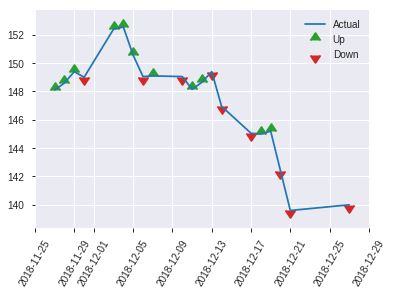


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.20997552321309518
RMSE: 0.4582308623533504
LogLoss: 0.6063120215149156
Mean Per-Class Error: 0.30742705570291773
AUC: 0.7632625994694959
pr_auc: 0.7772368322184344
Gini: 0.5265251989389919
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23653468489646912: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      52   64   0.5517   (64.0/116.0)
1      10   120  0.0769   (10.0/130.0)
Total  62   184  0.3008   (74.0/246.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.236535     0.764331  183
max f2                       0.192935     0.868966  204
max f0point5                 0.568403     0.729614  83
max accuracy                 0.249082     0.699187  175
max precision                0.79562      1         0
max recall                   0.14779      1         232
max specificity              0.79562      1         0
max absolute_mcc             0.236535     0.426955  183
max min_per_class_accuracy   0.456906     0.676923  123
max mean_per_class_accuracy  0.568403     0.692573  83

Gains/Lift Table: Avg response rate: 52.85 %, avg score: 43.46 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121951                   0.75773            1.89231   1.89231            1                0.775787  1                           0.775787            0.0230769       0.0230769                  89.2308   89.2308
    2        0.0203252                   0.751576           1.89231   1.89231            1                0.755012  1                           0.767477            0.0153846       0.0384615                  89.2308   89.2308
    3        0.0325203                   0.728795           1.89231   1.89231            1                0.743804  1                           0.7586              0.0230769       0.0615385                  89.2308   89.2308
    4        0.0406504                   0.724856           1.89231   1.89231            1                0.726797  1                           0.752239            0.0153846       0.0769231                  89.2308   89.2308
    5        0.0528455                   0.700086           1.89231   1.89231            1                0.71413   1                           0.743445            0.0230769       0.1                        89.2308   89.2308
    6        0.101626                    0.678382           1.57692   1.74092            0.833333         0.689521  0.92                        0.717562            0.0769231       0.176923                   57.6923   74.0923
    7        0.150407                    0.663141           1.41923   1.63659            0.75             0.670344  0.864865                    0.702248            0.0692308       0.246154                   41.9231   63.659
    8        0.203252                    0.633161           1.45562   1.58954            0.769231         0.6488    0.84                        0.688351            0.0769231       0.323077                   45.5621   58.9538
    9        0.300813                    0.582947           1.34038   1.50873            0.708333         0.606442  0.797297                    0.661786            0.130769        0.453846                   34.0385   50.8732
    10       0.402439                    0.534596           0.984     1.37622            0.52             0.562247  0.727273                    0.63665             0.1             0.553846                   -1.6      37.6224
    11       0.5                         0.462053           1.18269   1.33846            0.625            0.500952  0.707317                    0.610172            0.115385        0.669231                   18.2692   33.8462
    12       0.601626                    0.379567           0.908308  1.2658             0.48             0.421954  0.668919                    0.578379            0.0923077       0.761538                   -9.16923  26.58
    13       0.699187                    0.257048           1.10385   1.2432             0.583333         0.308605  0.656977                    0.540736            0.107692        0.869231                   10.3846   24.3202
    14       0.800813                    0.212637           0.832615  1.1911             0.44             0.232238  0.629442                    0.501586            0.0846154       0.953846                   -16.7385  19.1097
    15       0.898374                    0.171156           0.236538  1.08743            0.125            0.191529  0.574661                    0.467915            0.0230769       0.976923                   -76.3462  8.74347
    16       1                           0.0905097          0.227077  1                  0.12             0.140373  0.528455                    0.434628            

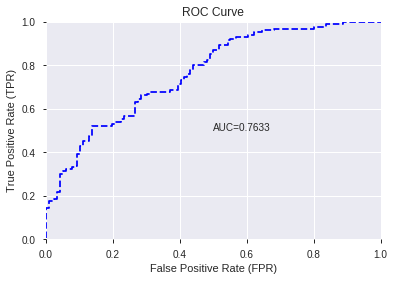

This function is available for GLM models only


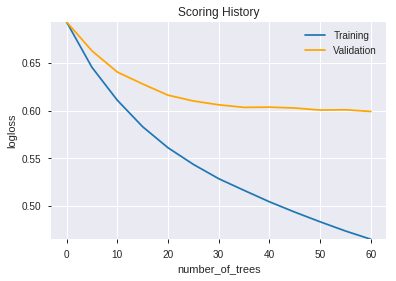

--2019-09-05 22:11:50--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.96.171
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.96.171|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip


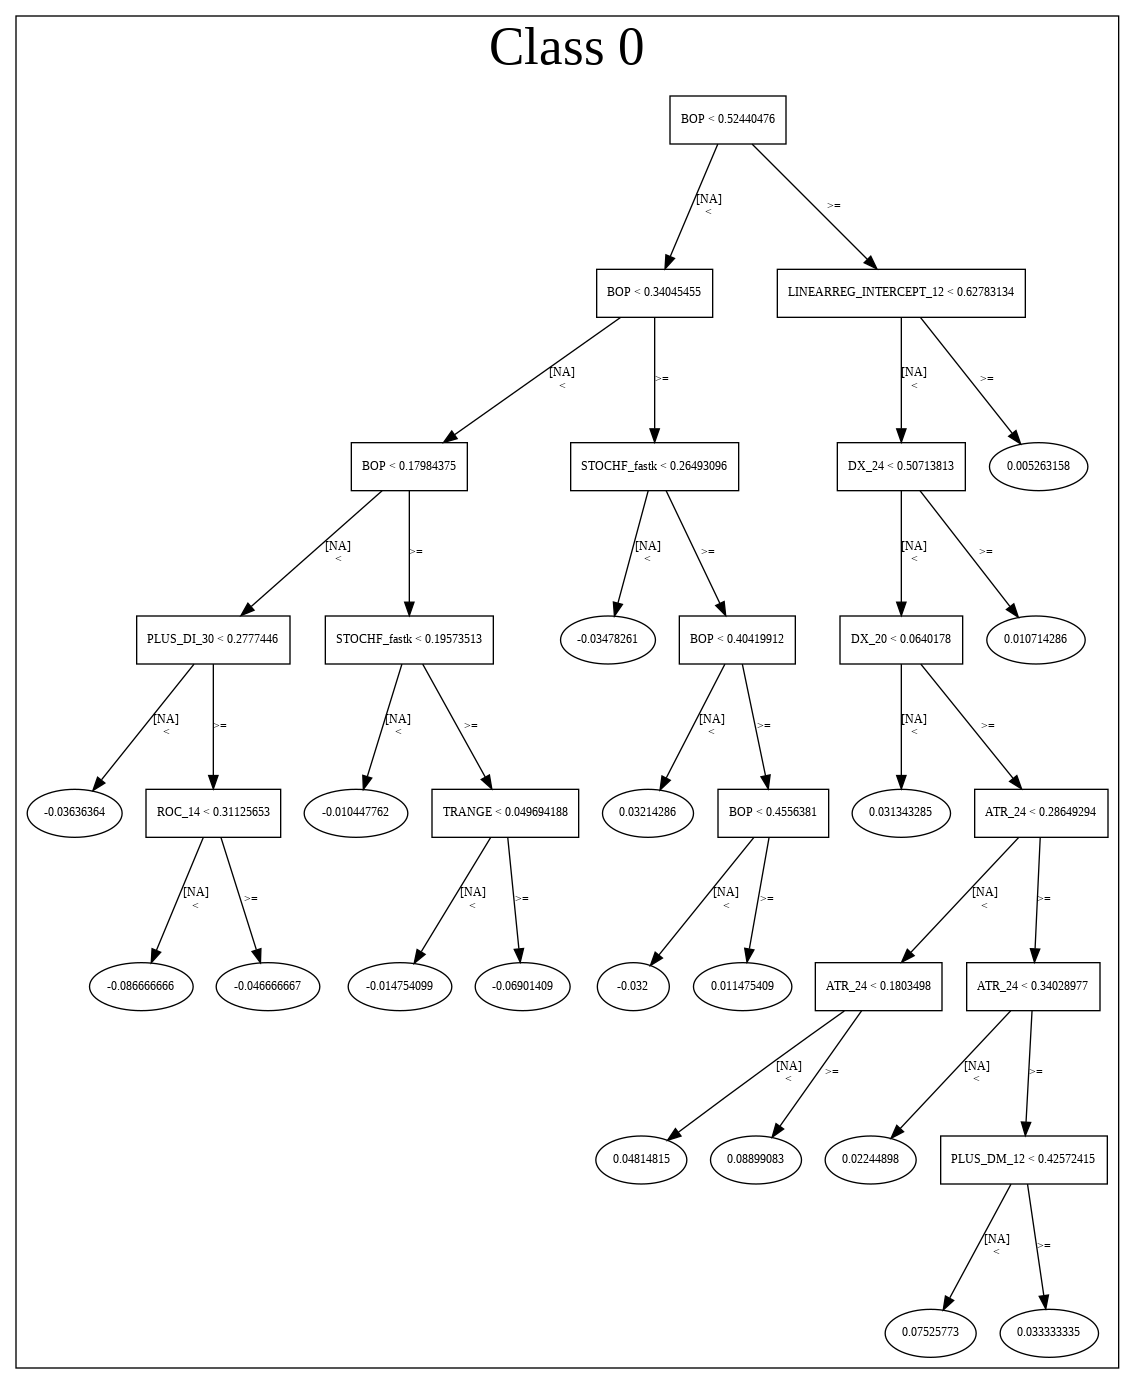

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_2_AutoML_20190905_221133',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_2_AutoML_20190905_221133',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_8e55',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_114_sid_8e55',
   'ty

['BOP',
 'TRANGE',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'CDLCLOSINGMARUBOZU',
 'DX_24',
 'CORREL_8',
 'MACDFIX_signal_14',
 'VAR_8',
 'DX_14',
 'BETA_8',
 'STOCH_slowk',
 'CCI_8',
 'PLUS_DI_8',
 'ATR_24',
 'CORREL_14',
 'ADOSC',
 'BETA_12',
 'STOCH_slowd',
 'ROCR100_12',
 'WILLR_8',
 'PLUS_DM_20',
 'WILLR_12',
 'ATR_14',
 'ATR_12',
 'MFI_20',
 'MACD',
 'LINEARREG_SLOPE_12',
 'MINUS_DM_20',
 'LINEARREG_INTERCEPT_12',
 'PLUS_DM_12',
 'DX_20',
 'ROC_8',
 'OBV',
 'MFI_8',
 'LINEARREG_ANGLE_8',
 'CCI_12',
 'CCI_14',
 'CCI_24',
 'ROC_14',
 'CCI_20',
 'MACDFIX_hist_12',
 'ROCR_30',
 'BBANDS_upperband_20_0_2',
 'aroonup_14',
 'aroonup_30',
 'PLUS_DM_8',
 'MOM_24',
 'BBANDS_lowerband_20_5_5',
 'MACDFIX_hist_20',
 'ROCR100_8',
 'ROCR100_24',
 'TSF_12',
 'BBANDS_lowerband_20_3_2',
 'SAR_0.2',
 'PLUS_DI_30',
 'BBANDS_middleband_20_0_5',
 'aroondown_30',
 'LINEARREG_SLOPE_8',
 'AROONOSC_14',
 'PLUS_DI_20',
 'ROCP_24',
 'BBANDS_lowerband_14_6_3',
 'BBANDS_upperband_30_0_3',
 'CCI_30',
 'WILLR_20',
 

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.740
GLM             0.703
XGBoost         0.699
dtype: float64

DeepLearning    GLM  XGBoost
All          0.541  0.528    0.699
DLF          0.687  0.703    0.695
Fwe          0.740  0.695    0.695
RFE          0.703  0.695    0.699
XGBF         0.707  0.703    0.695





F1


DeepLearning    0.763
GLM             0.762
XGBoost         0.764
dtype: float64

DeepLearning    GLM  XGBoost
All          0.694  0.691    0.755
DLF          0.748  0.754    0.747
Fwe          0.758  0.759    0.745
RFE          0.763  0.762    0.764
XGBF         0.763  0.754    0.747





auc


DeepLearning    0.766
GLM             0.750
XGBoost         0.763
dtype: float64

DeepLearning    GLM  XGBoost
All          0.514  0.487    0.746
DLF          0.738  0.740    0.747
Fwe          0.766  0.750    0.761
RFE          0.750  0.749    0.763
XGBF         0.743  0.740    0.747





logloss


DeepLearning     0.697
GLM             17.106
XGBoost          0.609
dtype: float64

DeepLearning     GLM  XGBoost
All          0.697  17.106    0.609
DLF          0.607   0.608    0.596
Fwe          0.611   0.594    0.587
RFE          0.592   0.616    0.606
XGBF         0.601   0.608    0.596





mean_per_class_error


DeepLearning    0.486
GLM             0.496
XGBoost         0.311
dtype: float64

DeepLearning    GLM  XGBoost
All          0.486  0.496    0.311
DLF          0.309  0.306    0.309
Fwe          0.262  0.311    0.298
RFE          0.304  0.311    0.307
XGBF         0.300  0.306    0.309





rmse


DeepLearning    0.501
GLM             0.722
XGBoost         0.460
dtype: float64

DeepLearning    GLM  XGBoost
All          0.501  0.722    0.460
DLF          0.457  0.456    0.453
Fwe          0.447  0.451    0.449
RFE          0.451  0.460    0.458
XGBF         0.451  0.456    0.453





mse


DeepLearning    0.251
GLM             0.522
XGBoost         0.211
dtype: float64

DeepLearning    GLM  XGBoost
All          0.251  0.522    0.211
DLF          0.209  0.208    0.205
Fwe          0.200  0.203    0.201
RFE          0.203  0.211    0.210
XGBF         0.203  0.208    0.205

{'F1':       DeepLearning    GLM  XGBoost
 All          0.694    NaN      NaN
 DLF          0.748    NaN      NaN
 DLF            NaN  0.754      NaN
 DLF            NaN    NaN    0.747
 All            NaN  0.691      NaN
 All            NaN    NaN    0.755
 XGBF         0.763    NaN      NaN
 XGBF           NaN  0.754      NaN
 XGBF           NaN    NaN    0.747
 Fwe          0.758    NaN      NaN
 Fwe            NaN  0.759      NaN
 Fwe            NaN    NaN    0.745
 RFE          0.763    NaN      NaN
 RFE            NaN  0.762      NaN
 RFE            NaN    NaN    0.764,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.541    NaN      NaN
 DLF          0.687    NaN      NaN
 DLF            NaN  0.703      NaN
 DLF            NaN    NaN    0.695
 All            NaN  0.528      NaN
 All            NaN    NaN    0.699
 XGBF         0.707    NaN      NaN
 XGBF           NaN  0.703      NaN
 XGBF           NaN    NaN    0.695
 Fwe          0.740    NaN      NaN
 Fwe     